## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


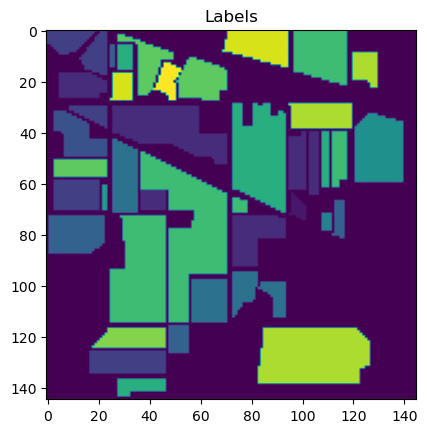

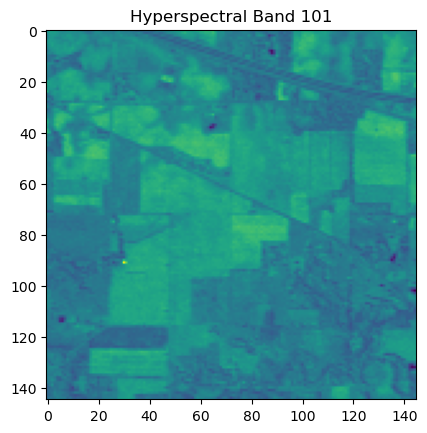

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(320, 5, 5, 200)
(75, 5, 5, 200)
(9854, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0772, PSNR: 10.7484


Epoch [1/50] Training Loss: 0.0634, PSNR: 11.5654
	[Val]   Batch [1/33] Loss: 0.0486, PSNR: 12.7970
	[Val]   Batch [10/33] Loss: 0.0479, PSNR: 12.4591
	[Val]   Batch [20/33] Loss: 0.0476, PSNR: 12.0497
	[Val]   Batch [30/33] Loss: 0.0461, PSNR: 12.4354
Epoch [1/50] Validation Loss: 0.0482, PSNR: 12.6270

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0462, PSNR: 12.6225


Epoch [2/50] Training Loss: 0.0382, PSNR: 13.7752
	[Val]   Batch [1/33] Loss: 0.0275, PSNR: 15.2644
	[Val]   Batch [10/33] Loss: 0.0270, PSNR: 14.9506
	[Val]   Batch [20/33] Loss: 0.0267, PSNR: 14.5581
	[Val]   Batch [30/33] Loss: 0.0261, PSNR: 14.9051
Epoch [2/50] Validation Loss: 0.0274, PSNR: 15.0766

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0283, PSNR: 15.4746


Epoch [3/50] Training Loss: 0.0222, PSNR: 16.1306
	[Val]   Batch [1/33] Loss: 0.0169, PSNR: 17.3779
	[Val]   Batch [10/33] Loss: 0.0165, PSNR: 17.1038
	[Val]   Batch [20/33] Loss: 0.0162, PSNR: 16.7413
	[Val]   Batch [30/33] Loss: 0.0158, PSNR: 17.1005
Epoch [3/50] Validation Loss: 0.0169, PSNR: 17.1880

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0180, PSNR: 17.0737


Epoch [4/50] Training Loss: 0.0137, PSNR: 18.2346
	[Val]   Batch [1/33] Loss: 0.0111, PSNR: 19.2063
	[Val]   Batch [10/33] Loss: 0.0107, PSNR: 18.9865
	[Val]   Batch [20/33] Loss: 0.0104, PSNR: 18.6620
	[Val]   Batch [30/33] Loss: 0.0101, PSNR: 19.0302
Epoch [4/50] Validation Loss: 0.0111, PSNR: 19.0175

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0103, PSNR: 18.7123


Epoch [5/50] Training Loss: 0.0093, PSNR: 19.8942
	[Val]   Batch [1/33] Loss: 0.0081, PSNR: 20.5660
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.4166
	[Val]   Batch [20/33] Loss: 0.0074, PSNR: 20.1329
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.5029
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.3839

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0100, PSNR: 19.2559


Epoch [6/50] Training Loss: 0.0069, PSNR: 21.1575
	[Val]   Batch [1/33] Loss: 0.0062, PSNR: 21.7540
	[Val]   Batch [10/33] Loss: 0.0057, PSNR: 21.6861
	[Val]   Batch [20/33] Loss: 0.0055, PSNR: 21.4424
	[Val]   Batch [30/33] Loss: 0.0053, PSNR: 21.7993
Epoch [6/50] Validation Loss: 0.0062, PSNR: 21.5780

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0053, PSNR: 21.8560


Epoch [7/50] Training Loss: 0.0055, PSNR: 22.1525
	[Val]   Batch [1/33] Loss: 0.0050, PSNR: 22.6460
	[Val]   Batch [10/33] Loss: 0.0046, PSNR: 22.6501
	[Val]   Batch [20/33] Loss: 0.0044, PSNR: 22.4425
	[Val]   Batch [30/33] Loss: 0.0042, PSNR: 22.8312
Epoch [7/50] Validation Loss: 0.0050, PSNR: 22.4851

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0049, PSNR: 22.7397


Epoch [8/50] Training Loss: 0.0046, PSNR: 22.9739
	[Val]   Batch [1/33] Loss: 0.0042, PSNR: 23.3986
	[Val]   Batch [10/33] Loss: 0.0038, PSNR: 23.4806
	[Val]   Batch [20/33] Loss: 0.0036, PSNR: 23.2967
	[Val]   Batch [30/33] Loss: 0.0035, PSNR: 23.6908
Epoch [8/50] Validation Loss: 0.0042, PSNR: 23.2558

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0039, PSNR: 23.5702


Epoch [9/50] Training Loss: 0.0039, PSNR: 23.6722
	[Val]   Batch [1/33] Loss: 0.0036, PSNR: 24.0958
	[Val]   Batch [10/33] Loss: 0.0032, PSNR: 24.2783
	[Val]   Batch [20/33] Loss: 0.0029, PSNR: 24.1374
	[Val]   Batch [30/33] Loss: 0.0028, PSNR: 24.5604
Epoch [9/50] Validation Loss: 0.0036, PSNR: 23.9971

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0032, PSNR: 24.0789


Epoch [10/50] Training Loss: 0.0034, PSNR: 24.2979
	[Val]   Batch [1/33] Loss: 0.0032, PSNR: 24.6420
	[Val]   Batch [10/33] Loss: 0.0027, PSNR: 24.9163
	[Val]   Batch [20/33] Loss: 0.0025, PSNR: 24.8081
	[Val]   Batch [30/33] Loss: 0.0024, PSNR: 25.2708
Epoch [10/50] Validation Loss: 0.0031, PSNR: 24.6009

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0033, PSNR: 24.4342


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.8723
	[Val]   Batch [1/33] Loss: 0.0028, PSNR: 25.1762
	[Val]   Batch [10/33] Loss: 0.0024, PSNR: 25.5383
	[Val]   Batch [20/33] Loss: 0.0022, PSNR: 25.4701
	[Val]   Batch [30/33] Loss: 0.0020, PSNR: 25.9746
Epoch [11/50] Validation Loss: 0.0027, PSNR: 25.1868

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0027, PSNR: 25.0457


Epoch [12/50] Training Loss: 0.0026, PSNR: 25.3568
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5788
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 25.9884
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 25.9441
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.4624
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.6232

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.7528


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.7698
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.9180
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.3983
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.3903
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 26.9124
Epoch [13/50] Validation Loss: 0.0023, PSNR: 26.0127

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.6746


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1658
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.3646
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.8481
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.8483
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.4167
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.4601

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.7142


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.4978
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.8128
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.2819
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.2923
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 27.8829
Epoch [15/50] Validation Loss: 0.0018, PSNR: 26.9145

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.5602


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.8665
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.3588
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.8263
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.8499
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.4390
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.4497

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.7512


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2455
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8356
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.2642
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.3004
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.9129
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.9112

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.5303


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.5983
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2360
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6150
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6622
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.2686
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.2878

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.4075


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9207
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.4432
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7932
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.8202
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.4886
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.4916

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.1768


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2088
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.8917
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1942
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.2479
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.9677
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.9233

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 28.8938


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4475
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 29.0465
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.2866
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.3406
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.0623
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.0623

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.2068


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7180
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6525
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9060
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0249
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7676
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.6767

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.1387


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8815
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6445
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8696
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9486
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6558
Epoch [23/50] Validation Loss: 0.0010, PSNR: 29.6520

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.4098


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1023
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1975
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3848
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.5706
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2613
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.2049

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.4536


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2952
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1984
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3510
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.5370
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2000
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.2061

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.7607


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4107
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5548
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7209
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9402
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.6788
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5827

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6940


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5149
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3090
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4464
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6516
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4450
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.3387
Early stopping triggered at epoch 27. No improvement for 3 epochs.


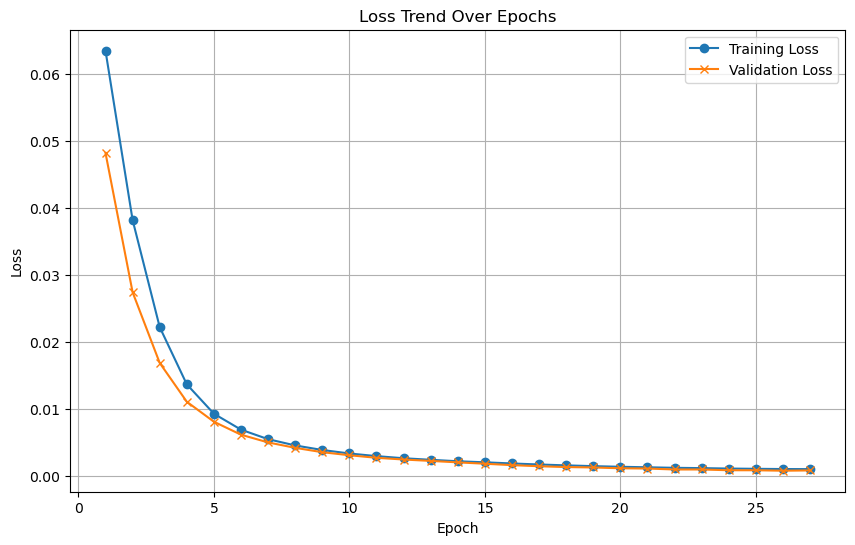

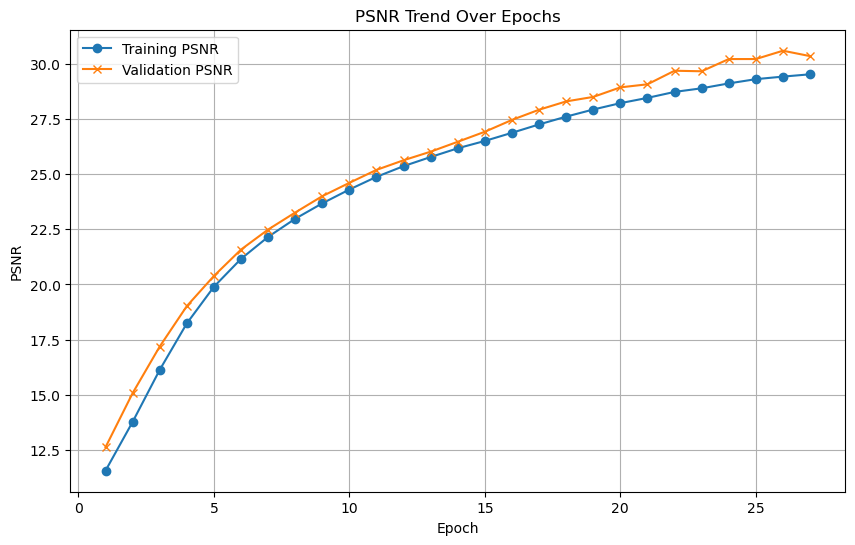

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/39 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7707
    Validation Batch [1/1], Loss: 2.7843
Validation Loss: 2.7843, Validation Accuracy: 0.00%
Validation loss improved from inf to 2.7843. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7356
    Validation Batch [1/1], Loss: 2.7843
Validation Loss: 2.7843, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7200
    Validation Batch [1/1], Loss: 2.7844
Validation Loss: 2.7844, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7025
    Validation Batch [1/1], Loss: 2.7844
Validation Loss: 2.7844, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [9/1000] completed, Average Training Loss: 2.6517
    Validation Batch [1/1], Loss: 2.7846
Validation Loss: 2.7846, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6485
    Validation Batch [1/1], Loss: 2.7846
Validation Loss: 2.7846, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6477
    Validation Batch [1/1], Loss: 2.7845
Validation Loss: 2.7845, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6231
    Validation Batch [1/1], Loss: 2.7844
Validation Loss: 2.7844, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.6135
    Validation

Epoch [15/1000] completed, Average Training Loss: 2.5955
    Validation Batch [1/1], Loss: 2.7835
Validation Loss: 2.7835, Validation Accuracy: 0.00%
Validation loss improved from 2.7839 to 2.7835. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.5875
    Validation Batch [1/1], Loss: 2.7831
Validation Loss: 2.7831, Validation Accuracy: 5.33%
Validation loss improved from 2.7835 to 2.7831. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5729
    Validation Batch [1/1], Loss: 2.7826
Validation Loss: 2.7826, Validation Accuracy: 6.67%
Validation loss improved from 2.7831 to 2.7826. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5722
    Validation Batch [1/1], Loss: 2.7821
Validation Loss: 2.7821, Validation Accuracy: 6.67%
Validation loss improved from 2.7826 to 2.7821. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/10

Epoch [32/1000] completed, Average Training Loss: 2.4656
    Validation Batch [1/1], Loss: 2.7518
Validation Loss: 2.7518, Validation Accuracy: 12.00%
Validation loss improved from 2.7559 to 2.7518. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4509
    Validation Batch [1/1], Loss: 2.7482
Validation Loss: 2.7482, Validation Accuracy: 12.00%
Validation loss improved from 2.7518 to 2.7482. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.4463
    Validation Batch [1/1], Loss: 2.7442
Validation Loss: 2.7442, Validation Accuracy: 12.00%
Validation loss improved from 2.7482 to 2.7442. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.4166
    Validation Batch [1/1], Loss: 2.7390
Validation Loss: 2.7390, Validation Accuracy: 12.00%
Validation loss improved from 2.7442 to 2.7390. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [3

Epoch [38/1000] completed, Average Training Loss: 2.4195
    Validation Batch [1/1], Loss: 2.7184
Validation Loss: 2.7184, Validation Accuracy: 12.00%
Validation loss improved from 2.7254 to 2.7184. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.4006
    Validation Batch [1/1], Loss: 2.7095
Validation Loss: 2.7095, Validation Accuracy: 12.00%
Validation loss improved from 2.7184 to 2.7095. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3873
    Validation Batch [1/1], Loss: 2.6985
Validation Loss: 2.6985, Validation Accuracy: 12.00%
Validation loss improved from 2.7095 to 2.6985. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3924
    Validation Batch [1/1], Loss: 2.6864
Validation Loss: 2.6864, Validation Accuracy: 12.00%
Validation loss improved from 2.6985 to 2.6864. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 2.5179
Validation Loss: 2.5179, Validation Accuracy: 21.33%
Validation loss improved from 2.5264 to 2.5179. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.2568
    Validation Batch [1/1], Loss: 2.5012
Validation Loss: 2.5012, Validation Accuracy: 20.00%
Validation loss improved from 2.5179 to 2.5012. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.2515
    Validation Batch [1/1], Loss: 2.4825
Validation Loss: 2.4825, Validation Accuracy: 20.00%
Validation loss improved from 2.5012 to 2.4825. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.2433
    Validation Batch [1/1], Loss: 2.4658
Validation Loss: 2.4658, Validation Accuracy: 21.33%
Validation loss improved from 2.4825 to 2.4658. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.2493
    Vali

Epoch [61/1000] completed, Average Training Loss: 2.2162
    Validation Batch [1/1], Loss: 2.3918
Validation Loss: 2.3918, Validation Accuracy: 30.67%
Validation loss improved from 2.4131 to 2.3918. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.2157
    Validation Batch [1/1], Loss: 2.3779
Validation Loss: 2.3779, Validation Accuracy: 34.67%
Validation loss improved from 2.3918 to 2.3779. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.2244
    Validation Batch [1/1], Loss: 2.3690
Validation Loss: 2.3690, Validation Accuracy: 30.67%
Validation loss improved from 2.3779 to 2.3690. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.1963
    Validation Batch [1/1], Loss: 2.3597
Validation Loss: 2.3597, Validation Accuracy: 30.67%
Validation loss improved from 2.3690 to 2.3597. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [6

Epoch [79/1000] completed, Average Training Loss: 2.0478
    Validation Batch [1/1], Loss: 2.2109
Validation Loss: 2.2109, Validation Accuracy: 44.00%
Validation loss improved from 2.2334 to 2.2109. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 2.0507
    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 40.00%
Validation loss improved from 2.2109 to 2.2036. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 2.0296
    Validation Batch [1/1], Loss: 2.1982
Validation Loss: 2.1982, Validation Accuracy: 42.67%
Validation loss improved from 2.2036 to 2.1982. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 2.0234
    Validation Batch [1/1], Loss: 2.1977
Validation Loss: 2.1977, Validation Accuracy: 45.33%
Validation loss improved from 2.1982 to 2.1977. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [8

Epoch [86/1000] completed, Average Training Loss: 1.9925
    Validation Batch [1/1], Loss: 2.1915
Validation Loss: 2.1915, Validation Accuracy: 41.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.0081
    Validation Batch [1/1], Loss: 2.1810
Validation Loss: 2.1810, Validation Accuracy: 48.00%
Validation loss improved from 2.1913 to 2.1810. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.9728
    Validation Batch [1/1], Loss: 2.1581
Validation Loss: 2.1581, Validation Accuracy: 52.00%
Validation loss improved from 2.1810 to 2.1581. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.9841
    Validation Batch [1/1], Loss: 2.1530
Validation Loss: 2.1530, Validation Accuracy: 52.00%
Validation loss improved from 2.1581 to 2.1530. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] complet

Epoch [102/1000] completed, Average Training Loss: 1.8386
    Validation Batch [1/1], Loss: 2.0315
Validation Loss: 2.0315, Validation Accuracy: 53.33%
Validation loss improved from 2.0365 to 2.0315. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.8529
    Validation Batch [1/1], Loss: 2.0483
Validation Loss: 2.0483, Validation Accuracy: 49.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.8257
    Validation Batch [1/1], Loss: 2.0659
Validation Loss: 2.0659, Validation Accuracy: 48.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.8077
    Validation Batch [1/1], Loss: 2.0902
Validation Loss: 2.0902, Validation Accuracy: 44.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training 

Epoch [109/1000] completed, Average Training Loss: 1.7871
    Validation Batch [1/1], Loss: 2.0249
Validation Loss: 2.0249, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.7443
    Validation Batch [1/1], Loss: 2.0257
Validation Loss: 2.0257, Validation Accuracy: 52.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.7600
    Validation Batch [1/1], Loss: 2.0028
Validation Loss: 2.0028, Validation Accuracy: 53.33%
Validation loss improved from 2.0066 to 2.0028. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7675
    Validation Batch [1/1], Loss: 1.9853
Validation Loss: 1.9853, Validation Accuracy: 52.00%
Validation loss improved from 2.0028 to 1.9853. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Av

Epoch [125/1000] completed, Average Training Loss: 1.6295
    Validation Batch [1/1], Loss: 1.8549
Validation Loss: 1.8549, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6161
    Validation Batch [1/1], Loss: 1.8517
Validation Loss: 1.8517, Validation Accuracy: 52.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6022
    Validation Batch [1/1], Loss: 1.8486
Validation Loss: 1.8486, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.6030
    Validation Batch [1/1], Loss: 1.8587
Validation Loss: 1.8587, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.5647


    Validation Batch [1/1], Loss: 1.8304
Validation Loss: 1.8304, Validation Accuracy: 56.00%
Validation loss improved from 1.8461 to 1.8304. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.5563
    Validation Batch [1/1], Loss: 1.8213
Validation Loss: 1.8213, Validation Accuracy: 50.67%
Validation loss improved from 1.8304 to 1.8213. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.5531
    Validation Batch [1/1], Loss: 1.8089
Validation Loss: 1.8089, Validation Accuracy: 56.00%
Validation loss improved from 1.8213 to 1.8089. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.5751
    Validation Batch [1/1], Loss: 1.8145
Validation Loss: 1.8145, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.5421
    Validation 

Epoch [147/1000] completed, Average Training Loss: 1.4297
    Validation Batch [1/1], Loss: 1.7066
Validation Loss: 1.7066, Validation Accuracy: 56.00%
Validation loss improved from 1.7141 to 1.7066. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.3924
    Validation Batch [1/1], Loss: 1.7342
Validation Loss: 1.7342, Validation Accuracy: 52.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4267
    Validation Batch [1/1], Loss: 1.7242
Validation Loss: 1.7242, Validation Accuracy: 52.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.3866
    Validation Batch [1/1], Loss: 1.6866
Validation Loss: 1.6866, Validation Accuracy: 58.67%
Validation loss improved from 1.7066 to 1.6866. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Av

    Validation Batch [1/1], Loss: 1.7032
Validation Loss: 1.7032, Validation Accuracy: 56.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.3656
    Validation Batch [1/1], Loss: 1.6947
Validation Loss: 1.6947, Validation Accuracy: 54.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.3582
    Validation Batch [1/1], Loss: 1.6536
Validation Loss: 1.6536, Validation Accuracy: 56.00%
Validation loss improved from 1.6866 to 1.6536. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3640
    Validation Batch [1/1], Loss: 1.6738
Validation Loss: 1.6738, Validation Accuracy: 61.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.3325
    Validation Batch [1/1], Loss: 1.6939
Vali

    Validation Batch [1/1], Loss: 1.5712
Validation Loss: 1.5712, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.1859
    Validation Batch [1/1], Loss: 1.5502
Validation Loss: 1.5502, Validation Accuracy: 54.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2102
    Validation Batch [1/1], Loss: 1.5092
Validation Loss: 1.5092, Validation Accuracy: 60.00%
Validation loss improved from 1.5288 to 1.5092. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.1979
    Validation Batch [1/1], Loss: 1.5011
Validation Loss: 1.5011, Validation Accuracy: 61.33%
Validation loss improved from 1.5092 to 1.5011. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.2011
    Validation Batch [1/1], Lo

Epoch [174/1000] completed, Average Training Loss: 1.1687
    Validation Batch [1/1], Loss: 1.5317
Validation Loss: 1.5317, Validation Accuracy: 62.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.1800
    Validation Batch [1/1], Loss: 1.5302
Validation Loss: 1.5302, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.1311
    Validation Batch [1/1], Loss: 1.4887
Validation Loss: 1.4887, Validation Accuracy: 62.67%
Validation loss improved from 1.4983 to 1.4887. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.1506
    Validation Batch [1/1], Loss: 1.4663
Validation Loss: 1.4663, Validation Accuracy: 62.67%
Validation loss improved from 1.4887 to 1.4663. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Av

    Validation Batch [1/1], Loss: 1.3756
Validation Loss: 1.3756, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 1.0340
    Validation Batch [1/1], Loss: 1.3878
Validation Loss: 1.3878, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 1.0124
    Validation Batch [1/1], Loss: 1.3850
Validation Loss: 1.3850, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.9894
    Validation Batch [1/1], Loss: 1.3995
Validation Loss: 1.3995, Validation Accuracy: 64.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.0181
    Validation Batch [1/1], Loss: 1.3731
Validation Loss: 1.

Epoch [199/1000] completed, Average Training Loss: 0.9772
    Validation Batch [1/1], Loss: 1.3376
Validation Loss: 1.3376, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9783
    Validation Batch [1/1], Loss: 1.3090
Validation Loss: 1.3090, Validation Accuracy: 69.33%
Validation loss improved from 1.3297 to 1.3090. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.9771
    Validation Batch [1/1], Loss: 1.3104
Validation Loss: 1.3104, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.9400
    Validation Batch [1/1], Loss: 1.3101
Validation Loss: 1.3101, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.3322
Validation Loss: 1.3322, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.8800
    Validation Batch [1/1], Loss: 1.2503
Validation Loss: 1.2503, Validation Accuracy: 70.67%
Validation loss improved from 1.2890 to 1.2503. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.8328
    Validation Batch [1/1], Loss: 1.2239
Validation Loss: 1.2239, Validation Accuracy: 72.00%
Validation loss improved from 1.2503 to 1.2239. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.8724
    Validation Batch [1/1], Loss: 1.2708
Validation Loss: 1.2708, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.8603
    Validation Batch [1/1], Lo

Epoch [221/1000] completed, Average Training Loss: 0.8148
    Validation Batch [1/1], Loss: 1.2398
Validation Loss: 1.2398, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.8349
    Validation Batch [1/1], Loss: 1.2259
Validation Loss: 1.2259, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.8328
    Validation Batch [1/1], Loss: 1.2295
Validation Loss: 1.2295, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.7822
    Validation Batch [1/1], Loss: 1.2319
Validation Loss: 1.2319, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.8139
  

    Validation Batch [1/1], Loss: 1.1705
Validation Loss: 1.1705, Validation Accuracy: 70.67%
Validation loss improved from 1.1758 to 1.1705. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7661
    Validation Batch [1/1], Loss: 1.1524
Validation Loss: 1.1524, Validation Accuracy: 70.67%
Validation loss improved from 1.1705 to 1.1524. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7404
    Validation Batch [1/1], Loss: 1.1693
Validation Loss: 1.1693, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.7162
    Validation Batch [1/1], Loss: 1.1547
Validation Loss: 1.1547, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.7345
    Validation Batch [1/1], Lo

Epoch [245/1000] completed, Average Training Loss: 0.6807
    Validation Batch [1/1], Loss: 1.1111
Validation Loss: 1.1111, Validation Accuracy: 74.67%
Validation loss improved from 1.1152 to 1.1111. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.6687
    Validation Batch [1/1], Loss: 1.1023
Validation Loss: 1.1023, Validation Accuracy: 74.67%
Validation loss improved from 1.1111 to 1.1023. Saving model...

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.6701
    Validation Batch [1/1], Loss: 1.0988
Validation Loss: 1.0988, Validation Accuracy: 76.00%
Validation loss improved from 1.1023 to 1.0988. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.6567
    Validation Batch [1/1], Loss: 1.1001
Validation Loss: 1.1001, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000

Epoch [257/1000] completed, Average Training Loss: 0.6300
    Validation Batch [1/1], Loss: 1.0868
Validation Loss: 1.0868, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5866
    Validation Batch [1/1], Loss: 1.0115
Validation Loss: 1.0115, Validation Accuracy: 76.00%
Validation loss improved from 1.0415 to 1.0115. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5852
    Validation Batch [1/1], Loss: 1.0271
Validation Loss: 1.0271, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5713
    Validation Batch [1/1], Loss: 1.1303
Validation Loss: 1.1303, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training 

Epoch [269/1000] completed, Average Training Loss: 0.5509
    Validation Batch [1/1], Loss: 0.9690
Validation Loss: 0.9690, Validation Accuracy: 82.67%
Validation loss improved from 1.0115 to 0.9690. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.5235
    Validation Batch [1/1], Loss: 0.9635
Validation Loss: 0.9635, Validation Accuracy: 81.33%
Validation loss improved from 0.9690 to 0.9635. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.5595
    Validation Batch [1/1], Loss: 1.0680
Validation Loss: 1.0680, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.5422
    Validation Batch [1/1], Loss: 1.0366
Validation Loss: 1.0366, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Av

    Validation Batch [1/1], Loss: 0.9413
Validation Loss: 0.9413, Validation Accuracy: 77.33%
Validation loss improved from 0.9635 to 0.9413. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4887
    Validation Batch [1/1], Loss: 1.0379
Validation Loss: 1.0379, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4683
    Validation Batch [1/1], Loss: 1.0093
Validation Loss: 1.0093, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.5004
    Validation Batch [1/1], Loss: 1.0035
Validation Loss: 1.0035, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.4834
    Validation Batch [1/1], Loss: 1.0794
Vali

Epoch [291/1000] completed, Average Training Loss: 0.4367
    Validation Batch [1/1], Loss: 0.9246
Validation Loss: 0.9246, Validation Accuracy: 81.33%
Validation loss improved from 0.9334 to 0.9246. Saving model...

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4422
    Validation Batch [1/1], Loss: 0.9025
Validation Loss: 0.9025, Validation Accuracy: 85.33%
Validation loss improved from 0.9246 to 0.9025. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4598
    Validation Batch [1/1], Loss: 0.9351
Validation Loss: 0.9351, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.4281
    Validation Batch [1/1], Loss: 0.9762
Validation Loss: 0.9762, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Av

Epoch [303/1000] completed, Average Training Loss: 0.4116
    Validation Batch [1/1], Loss: 0.8944
Validation Loss: 0.8944, Validation Accuracy: 78.67%
Validation loss improved from 0.9025 to 0.8944. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3971
    Validation Batch [1/1], Loss: 0.9067
Validation Loss: 0.9067, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [305/1000] - Training


Epoch [305/1000] completed, Average Training Loss: 0.3857
    Validation Batch [1/1], Loss: 0.8908
Validation Loss: 0.8908, Validation Accuracy: 82.67%
Validation loss improved from 0.8944 to 0.8908. Saving model...

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3395
    Validation Batch [1/1], Loss: 0.9455
Validation Loss: 0.9455, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3834
    Validation Batch [1/1], Loss: 0.9370
Validation Loss: 0.9370, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.3911
    Validation Batch [1/1], Loss: 0.9527
Validation Loss: 0.9527, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training 

Epoch [314/1000] completed, Average Training Loss: 0.3531
    Validation Batch [1/1], Loss: 0.8378
Validation Loss: 0.8378, Validation Accuracy: 82.67%
Validation loss improved from 0.8578 to 0.8378. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3485
    Validation Batch [1/1], Loss: 0.8440
Validation Loss: 0.8440, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3504
    Validation Batch [1/1], Loss: 0.8340
Validation Loss: 0.8340, Validation Accuracy: 84.00%
Validation loss improved from 0.8378 to 0.8340. Saving model...

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.3327
    Validation Batch [1/1], Loss: 0.8829
Validation Loss: 0.8829, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Av

Epoch [329/1000] completed, Average Training Loss: 0.2993
    Validation Batch [1/1], Loss: 0.8319
Validation Loss: 0.8319, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3072
    Validation Batch [1/1], Loss: 0.8050
Validation Loss: 0.8050, Validation Accuracy: 81.33%
Validation loss improved from 0.8264 to 0.8050. Saving model...

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3205
    Validation Batch [1/1], Loss: 0.7910
Validation Loss: 0.7910, Validation Accuracy: 82.67%
Validation loss improved from 0.8050 to 0.7910. Saving model...

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.2899
    Validation Batch [1/1], Loss: 0.8827
Validation Loss: 0.8827, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Av

Epoch [337/1000] completed, Average Training Loss: 0.3111
    Validation Batch [1/1], Loss: 0.7902
Validation Loss: 0.7902, Validation Accuracy: 82.67%
Validation loss improved from 0.7910 to 0.7902. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2846
    Validation Batch [1/1], Loss: 0.8623
Validation Loss: 0.8623, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2659
    Validation Batch [1/1], Loss: 0.8902
Validation Loss: 0.8902, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2688
    Validation Batch [1/1], Loss: 0.8398
Validation Loss: 0.8398, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training 

Epoch [352/1000] completed, Average Training Loss: 0.2388
    Validation Batch [1/1], Loss: 0.8198
Validation Loss: 0.8198, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2604
    Validation Batch [1/1], Loss: 0.7989
Validation Loss: 0.7989, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2458
    Validation Batch [1/1], Loss: 0.8677
Validation Loss: 0.8677, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2422
    Validation Batch [1/1], Loss: 0.8565
Validation Loss: 0.8565, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2309
  

    Validation Batch [1/1], Loss: 0.7901
Validation Loss: 0.7901, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.2341
    Validation Batch [1/1], Loss: 0.8547
Validation Loss: 0.8547, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.2173
    Validation Batch [1/1], Loss: 0.7767
Validation Loss: 0.7767, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.2292
    Validation Batch [1/1], Loss: 0.7869
Validation Loss: 0.7869, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2277
    Validation Batch [1/1], Loss: 0.7816
Validation Loss: 0.

Epoch [376/1000] completed, Average Training Loss: 0.2045
    Validation Batch [1/1], Loss: 0.7873
Validation Loss: 0.7873, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2033
    Validation Batch [1/1], Loss: 0.7428
Validation Loss: 0.7428, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2088
    Validation Batch [1/1], Loss: 0.7574
Validation Loss: 0.7574, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2191
    Validation Batch [1/1], Loss: 0.7237
Validation Loss: 0.7237, Validation Accuracy: 85.33%
Validation loss improved from 0.7258 to 0.7237. Saving model...

LOG: Epoch [380/1000] - Training


Epoch [380/1000] completed, Average Training Loss: 0.2010
    Validation Batch [1/1], Loss: 0.7309
Validation Loss: 0.7309, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2021
    Validation Batch [1/1], Loss: 0.7129
Validation Loss: 0.7129, Validation Accuracy: 78.67%
Validation loss improved from 0.7237 to 0.7129. Saving model...

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2048
    Validation Batch [1/1], Loss: 0.7190
Validation Loss: 0.7190, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1646
    Validation Batch [1/1], Loss: 0.7398
Validation Loss: 0.7398, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training 

Epoch [398/1000] completed, Average Training Loss: 0.1678
    Validation Batch [1/1], Loss: 0.8722
Validation Loss: 0.8722, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1688
    Validation Batch [1/1], Loss: 0.7597
Validation Loss: 0.7597, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1824
    Validation Batch [1/1], Loss: 0.7340
Validation Loss: 0.7340, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1770
    Validation Batch [1/1], Loss: 0.7691
Validation Loss: 0.7691, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.160

Epoch [422/1000] completed, Average Training Loss: 0.1524
    Validation Batch [1/1], Loss: 0.7070
Validation Loss: 0.7070, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1630
    Validation Batch [1/1], Loss: 0.8845
Validation Loss: 0.8845, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1493
    Validation Batch [1/1], Loss: 0.7765
Validation Loss: 0.7765, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1325
    Validation Batch [1/1], Loss: 0.7077
Validation Loss: 0.7077, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1401
  

    Validation Batch [1/1], Loss: 0.7949
Validation Loss: 0.7949, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1216
    Validation Batch [1/1], Loss: 0.7279
Validation Loss: 0.7279, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1184
    Validation Batch [1/1], Loss: 0.6881
Validation Loss: 0.6881, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1243
    Validation Batch [1/1], Loss: 0.6785
Validation Loss: 0.6785, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1223
    Validation Batch [1/1], Loss: 0.7045
Validation Loss:

Epoch [469/1000] completed, Average Training Loss: 0.1100
    Validation Batch [1/1], Loss: 0.7120
Validation Loss: 0.7120, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0962
    Validation Batch [1/1], Loss: 0.6678
Validation Loss: 0.6678, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1184
    Validation Batch [1/1], Loss: 0.6966
Validation Loss: 0.6966, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1228
    Validation Batch [1/1], Loss: 0.7805
Validation Loss: 0.7805, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.103

Epoch [492/1000] completed, Average Training Loss: 0.0893
    Validation Batch [1/1], Loss: 0.7037
Validation Loss: 0.7037, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0877
    Validation Batch [1/1], Loss: 0.7828
Validation Loss: 0.7828, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0916
    Validation Batch [1/1], Loss: 0.7036
Validation Loss: 0.7036, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0935
    Validation Batch [1/1], Loss: 0.7239
Validation Loss: 0.7239, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.097

    Validation Batch [1/1], Loss: 0.7653
Validation Loss: 0.7653, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0816
    Validation Batch [1/1], Loss: 0.7032
Validation Loss: 0.7032, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0858
    Validation Batch [1/1], Loss: 0.6821
Validation Loss: 0.6821, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.6660
Validation Loss: 0.6660, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0963
    Validation Batch [1/1], Loss: 0.6835
Validation Loss

Epoch [538/1000] completed, Average Training Loss: 0.0693
    Validation Batch [1/1], Loss: 0.6684
Validation Loss: 0.6684, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0767
    Validation Batch [1/1], Loss: 0.6391
Validation Loss: 0.6391, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.6673
Validation Loss: 0.6673, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0650
    Validation Batch [1/1], Loss: 0.6835
Validation Loss: 0.6835, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.074

Epoch [560/1000] completed, Average Training Loss: 0.0821
    Validation Batch [1/1], Loss: 0.7144
Validation Loss: 0.7144, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0646
    Validation Batch [1/1], Loss: 0.7183
Validation Loss: 0.7183, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.6731
Validation Loss: 0.6731, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0777
    Validation Batch [1/1], Loss: 0.6642
Validation Loss: 0.6642, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.063

Epoch [584/1000] completed, Average Training Loss: 0.0596
    Validation Batch [1/1], Loss: 0.7222
Validation Loss: 0.7222, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.7666
Validation Loss: 0.7666, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0681
    Validation Batch [1/1], Loss: 0.7331
Validation Loss: 0.7331, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0609
    Validation Batch [1/1], Loss: 0.7155
Validation Loss: 0.7155, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0553
  

Epoch [607/1000] completed, Average Training Loss: 0.0631
    Validation Batch [1/1], Loss: 0.8202
Validation Loss: 0.8202, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.7946
Validation Loss: 0.7946, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.7171
Validation Loss: 0.7171, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.7041
Validation Loss: 0.7041, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.051

    Validation Batch [1/1], Loss: 0.7175
Validation Loss: 0.7175, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0499
    Validation Batch [1/1], Loss: 0.7525
Validation Loss: 0.7525, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.6428
Validation Loss: 0.6428, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0544
    Validation Batch [1/1], Loss: 0.7846
Validation Loss: 0.7846, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.9552
Validation Loss

Epoch [652/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.6658
Validation Loss: 0.6658, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [653/1000] - Training
Epoch [653/1000] completed, Average Training Loss: 0.0416
    Validation Batch [1/1], Loss: 0.6554
Validation Loss: 0.6554, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [654/1000] - Training
Epoch [654/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.7090
Validation Loss: 0.7090, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [655/1000] - Training
Epoch [655/1000] completed, Average Training Loss: 0.0413
    Validation Batch [1/1], Loss: 0.6606
Validation Loss: 0.6606, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.047

Epoch [675/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.6912
Validation Loss: 0.6912, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.6960
Validation Loss: 0.6960, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.6613
Validation Loss: 0.6613, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.6039
Validation Loss: 0.6039, Validation Accuracy: 86.67%
Validation loss improved from 0.6171 to 0.6039. Saving model...

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Traini

Epoch [698/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.7166
Validation Loss: 0.7166, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.7826
Validation Loss: 0.7826, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [700/1000] - Training
Epoch [700/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.6618
Validation Loss: 0.6618, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0390
    Validation Batch [1/1], Loss: 0.6791
Validation Loss: 0.6791, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.048

Epoch [721/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.6756
Validation Loss: 0.6756, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0331
    Validation Batch [1/1], Loss: 0.6650
Validation Loss: 0.6650, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.0418
    Validation Batch [1/1], Loss: 0.7038
Validation Loss: 0.7038, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [724/1000] - Training
Epoch [724/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.6678
Validation Loss: 0.6678, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [725/1000] - Training
Epoch [725/1000] completed, Average Training Loss: 0.031

Epoch [743/1000] completed, Average Training Loss: 0.0377
    Validation Batch [1/1], Loss: 0.6657
Validation Loss: 0.6657, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [744/1000] - Training
Epoch [744/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.6429
Validation Loss: 0.6429, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0308
    Validation Batch [1/1], Loss: 0.7016
Validation Loss: 0.7016, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.7606
Validation Loss: 0.7606, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.034

Epoch [766/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.6964
Validation Loss: 0.6964, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [767/1000] - Training
Epoch [767/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.6586
Validation Loss: 0.6586, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [768/1000] - Training
Epoch [768/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.6515
Validation Loss: 0.6515, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [769/1000] - Training
Epoch [769/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.7143
Validation Loss: 0.7143, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [770/1000] - Training
Epoch [770/1000] completed, Average Training Loss: 0.033

Epoch [789/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.6297
Validation Loss: 0.6297, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [790/1000] - Training
Epoch [790/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.6329
Validation Loss: 0.6329, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [791/1000] - Training
Epoch [791/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.6349
Validation Loss: 0.6349, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [792/1000] - Training
Epoch [792/1000] completed, Average Training Loss: 0.0279
    Validation Batch [1/1], Loss: 0.6595
Validation Loss: 0.6595, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [793/1000] - Training
Epoch [793/1000] completed, Average Training Loss: 0.030

Epoch [812/1000] completed, Average Training Loss: 0.0238
    Validation Batch [1/1], Loss: 0.7297
Validation Loss: 0.7297, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [813/1000] - Training
Epoch [813/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.6697
Validation Loss: 0.6697, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [814/1000] - Training
Epoch [814/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.6698
Validation Loss: 0.6698, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [815/1000] - Training
Epoch [815/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.6847
Validation Loss: 0.6847, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [816/1000] - Training
Epoch [816/1000] completed, Average Training Loss: 0.026

Epoch [835/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.6924
Validation Loss: 0.6924, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [836/1000] - Training
Epoch [836/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.7164
Validation Loss: 0.7164, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [837/1000] - Training
Epoch [837/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.7097
Validation Loss: 0.7097, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [838/1000] - Training
Epoch [838/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.6267
Validation Loss: 0.6267, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [839/1000] - Training
Epoch [839/1000] completed, Average Training Loss: 0.028

Epoch [858/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.7131
Validation Loss: 0.7131, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [859/1000] - Training
Epoch [859/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.7299
Validation Loss: 0.7299, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [860/1000] - Training
Epoch [860/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.7621
Validation Loss: 0.7621, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [861/1000] - Training
Epoch [861/1000] completed, Average Training Loss: 0.0268
    Validation Batch [1/1], Loss: 0.7577
Validation Loss: 0.7577, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [862/1000] - Training
Epoch [862/1000] completed, Average Training Loss: 0.027

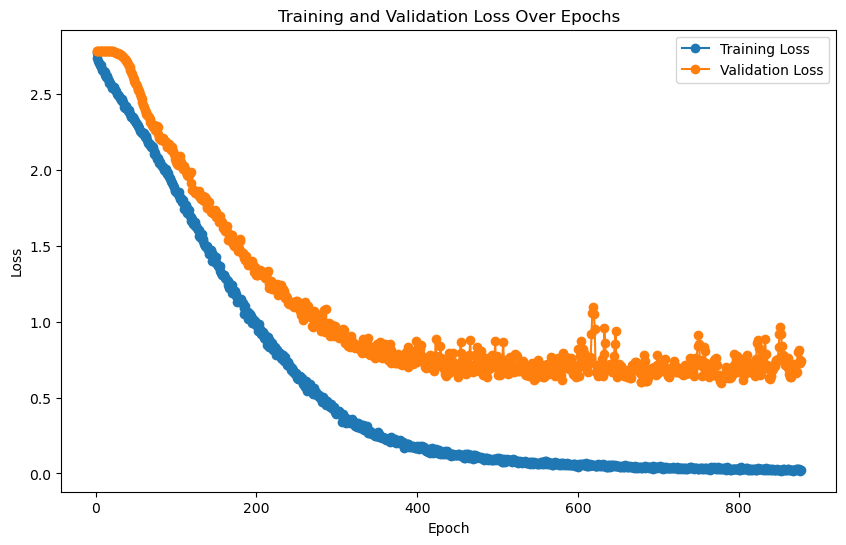

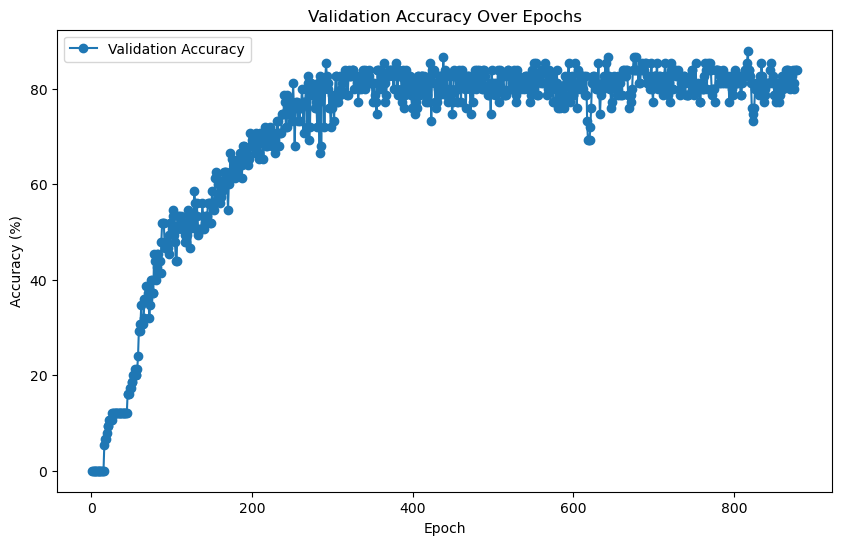


Evaluating on the test set...
    Test Batch [1/39], Loss: 2.6855

Final Test Loss: 1.1485, Test Accuracy: 68.96%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (75, 64), Validation labels shape: (75,)
LOG: Test features shape: (9854, 64), Test labels shape: (9854,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.25      0.40      0.31         5
           2       0.00      0.00      0.00         5
           3       1.00      0.80      0.89         5
           4       0.33      0.40      0.36         5
           5       0.50      0.40      0.44         5
           6       0.80      0.80      0.80         5
           7       0.50      0.40      0.44         5
           8       0.00      0.00  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklea

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (75, 64)
Val labels shape: (75,)
Test reps shape: (9854, 64)
Test labels shape: (9854,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7870  |  Val Loss: 2.7165
Validation loss improved from inf to 2.7165.
[Epoch 2/1000] Train Loss: 2.6449  |  Val Loss: 2.6384
Validation loss improved from 2.7165 to 2.6384.
[Epoch 3/1000] Train Loss: 2.5727  |  Val Loss: 2.5596
Validation loss improved from 2.6384 to 2.5596.
[Epoch 4/1000] Train Loss: 2.5065  |  Val Loss: 2.4793
Validation loss improved from 2.5596 to 2.4793.
[Epoch 5/1000] Train Loss: 2.4312  |  Val Loss: 2.4159
Validation loss improved from 2.4793 to 2.4159.
[Epoch 6/1000] Train Loss: 2.3616  |  Val Loss: 2.3378
Validation loss improved from 2.4159 to 2.3378.
[Epoch 7/1000] Train Loss: 2.2835  |  Val Loss: 2.2549
Validation loss improved from 2.3378 to 2.2549.
[Epoch 8/1000] Train Loss: 2.2035  |  Val Loss: 2.1742
Validation loss improved from 2.2549 to 2.1742.
[Epoch 9/1000] Train Loss: 2.1213  |  Val Loss: 2.0946
Validation loss improved from 2.1742 to 2.0946.
[Epoch 10/1000] Train Loss: 2.0328  |  Val Loss: 2.0116
Validation loss impr

[Epoch 16/1000] Train Loss: 1.5507  |  Val Loss: 1.6136
Validation loss improved from 1.6564 to 1.6136.
[Epoch 17/1000] Train Loss: 1.4961  |  Val Loss: 1.5549
Validation loss improved from 1.6136 to 1.5549.
[Epoch 18/1000] Train Loss: 1.4370  |  Val Loss: 1.5141
Validation loss improved from 1.5549 to 1.5141.
[Epoch 19/1000] Train Loss: 1.3844  |  Val Loss: 1.4889
Validation loss improved from 1.5141 to 1.4889.


[Epoch 20/1000] Train Loss: 1.3449  |  Val Loss: 1.4443
Validation loss improved from 1.4889 to 1.4443.
[Epoch 21/1000] Train Loss: 1.2970  |  Val Loss: 1.4253
Validation loss improved from 1.4443 to 1.4253.
[Epoch 22/1000] Train Loss: 1.2617  |  Val Loss: 1.3962
Validation loss improved from 1.4253 to 1.3962.
[Epoch 23/1000] Train Loss: 1.2323  |  Val Loss: 1.3689
Validation loss improved from 1.3962 to 1.3689.
[Epoch 24/1000] Train Loss: 1.2021  |  Val Loss: 1.3654
Validation loss improved from 1.3689 to 1.3654.
[Epoch 25/1000] Train Loss: 1.1621  |  Val Loss: 1.3491
Validation loss improved from 1.3654 to 1.3491.
[Epoch 26/1000] Train Loss: 1.1401  |  Val Loss: 1.3112
Validation loss improved from 1.3491 to 1.3112.
[Epoch 27/1000] Train Loss: 1.1076  |  Val Loss: 1.3111
Validation loss improved from 1.3112 to 1.3111.
[Epoch 28/1000] Train Loss: 1.0886  |  Val Loss: 1.2842
Validation loss improved from 1.3111 to 1.2842.
[Epoch 29/1000] Train Loss: 1.0633  |  Val Loss: 1.2639
Validati

[Epoch 35/1000] Train Loss: 0.9736  |  Val Loss: 1.2086
Validation loss improved from 1.2102 to 1.2086.
[Epoch 36/1000] Train Loss: 0.9447  |  Val Loss: 1.2398
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.9390  |  Val Loss: 1.1897
Validation loss improved from 1.2086 to 1.1897.
[Epoch 38/1000] Train Loss: 0.9408  |  Val Loss: 1.2092
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 39/1000] Train Loss: 0.9044  |  Val Loss: 1.1998
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 0.8989  |  Val Loss: 1.1578
Validation loss improved from 1.1897 to 1.1578.
[Epoch 41/1000] Train Loss: 0.8837  |  Val Loss: 1.1974
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.8647  |  Val Loss: 1.1674
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 0.8490  |  Val Loss: 1.1344
Validation loss improved from 1.1578 to 1.1344.
[Epoch 44/1000] Train Loss: 0.8329  |  Val Loss: 1.1698
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.8297  |  Val Loss: 1.1507
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 0.8103  |  Val Loss: 1.1365
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 47/1000] Train Loss: 0.8049  |  Val Loss: 1.1308
Validation loss improved from 1.1344 to 1.1308.
[Epoch 48/1000] Train Loss: 

[Epoch 53/1000] Train Loss: 0.7427  |  Val Loss: 1.1009
Validation loss improved from 1.1010 to 1.1009.
[Epoch 54/1000] Train Loss: 0.7214  |  Val Loss: 1.0909
Validation loss improved from 1.1009 to 1.0909.
[Epoch 55/1000] Train Loss: 0.7247  |  Val Loss: 1.0734
Validation loss improved from 1.0909 to 1.0734.
[Epoch 56/1000] Train Loss: 0.7201  |  Val Loss: 1.0892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.7203  |  Val Loss: 1.0776
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 58/1000] Train Loss: 0.7020  |  Val Loss: 1.0814
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.6889  |  Val Loss: 1.0660
Validation loss improved from 1.0734 to 1.0660.
[Epoch 60/1000] Train Loss: 0.6960  |  Val Loss: 1.0714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 0.6899  |  Val Loss: 1.0551
Validation loss improved from 1.0660 to 1.0551.
[Epoch 62/1000] Train Loss: 0.6852  |  Val Loss: 1.0717
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 0.6720  |  Val Loss: 1.0474
Validation loss improved from 1.0551 to 1.0474.
[Epoch 64/1000] Train Loss: 0.6587  |  Val Loss: 1.0697
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.6686  |  Val Loss: 1.0714
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.6413  |  Val Loss: 1.0476
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 67/1000] Train Loss: 

[Epoch 72/1000] Train Loss: 0.6036  |  Val Loss: 1.0384
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 0.5948  |  Val Loss: 1.0359
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 74/1000] Train Loss: 0.5948  |  Val Loss: 1.0392
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 75/1000] Train Loss: 0.5815  |  Val Loss: 1.0231
Validation loss improved from 1.0276 to 1.0231.
[Epoch 76/1000] Train Loss: 0.5925  |  Val Loss: 1.0361
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 77/1000] Train Loss: 0.5727  |  Val Loss: 1.0170
Validation loss improved from 1.0231 to 1.0170.
[Epoch 78/1000] Train Loss: 0.5670  |  Val Loss: 1.0311
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.5673  |  Val Loss: 1.0242
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 0.5647  |  Val Loss: 1.0153
Validation loss improved from 1.0170 to 1.0153.
[Epoch 81/1000] Train Loss: 0.5603  |  Val Loss: 1.0360
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 0.5427  |  Val Loss: 1.0195
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 0.5359  |  Val Loss: 1.0450
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 84/1000] Train Loss: 0.5409  |  Val Loss: 1.0102
Validation loss improved from 1.0153 to 1.0102.
[Epoch 85/1000] Train Loss: 0.5342  |  Val Loss: 1.0322
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 

[Epoch 91/1000] Train Loss: 0.5021  |  Val Loss: 1.0361
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 0.4910  |  Val Loss: 1.0203
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 93/1000] Train Loss: 0.4970  |  Val Loss: 1.0090
Validation loss improved from 1.0099 to 1.0090.
[Epoch 94/1000] Train Loss: 0.5008  |  Val Loss: 1.0465
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 0.4884  |  Val Loss: 1.0322
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 96/1000] Train Loss: 0.4971  |  Val Loss: 1.0430
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 97/1000] Train Loss: 0.4808  |  Val Loss: 1.0187
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 98/1000] Train Loss: 0.4700  |  Val Loss: 1.0396
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 99/1000] Train Loss: 0.4725  |  Val Loss: 1.0298
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 100/1000] Train Loss: 0.4612  |  Val Loss: 1.0257
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 101/1000] Train Loss: 0.4498  |  Val Loss: 1.0340
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 102/1000] Train Loss: 0.4553  |  Val Loss: 1.0174
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 103/1000] Train Loss: 0.4476  |  Val Loss: 1.0545
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 104/1000] Train Loss: 0.4442  |  Val Loss: 1.0217
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 105/1000] Train Loss: 0.4478  |  Val Loss: 1.0379
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 106/1000] Train Loss: 0.4419  |  Val Loss: 1.0523
!! Validation loss did NOT improve !! Patience: 13/100

[Epoch 110/1000] Train Loss: 0.4264  |  Val Loss: 1.0414
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 111/1000] Train Loss: 0.4126  |  Val Loss: 1.0499
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 112/1000] Train Loss: 0.4112  |  Val Loss: 1.0375
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 113/1000] Train Loss: 0.4128  |  Val Loss: 1.0931
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 114/1000] Train Loss: 0.4056  |  Val Loss: 1.0169
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 115/1000] Train Loss: 0.4026  |  Val Loss: 1.0741
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 116/1000] Train Loss: 0.4022  |  Val Loss: 1.0319
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 117/1000] Train Loss: 0.3935  |  Val Loss: 1.0412
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 118/1000] Train Loss: 0.3863  |  Val Loss: 1.0772
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 119/1000] Train Loss: 0.3831  |  Val Loss: 1.0361
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 120/1000] Train Loss: 0.3770  |  Val Loss: 1.0584
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 121/1000] Train Loss: 0.3828  |  Val Loss: 1.0591
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 122/1000] Train Loss: 0.3837  |  Val Loss: 1.0375
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 123/1000] Train Loss: 0.3925  |  Val Loss: 1.0893
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 124/1000] Train Loss: 0.3737  |  Val Loss: 1.0501
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 125/1000] Train Loss: 0.3607  |  Val Loss: 1.0777
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 126/1000] Train Loss: 0.3640  |  Val Loss: 1.0468
!! Validation loss did NOT improve !! Patience:

[Epoch 129/1000] Train Loss: 0.3593  |  Val Loss: 1.0747
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 130/1000] Train Loss: 0.3487  |  Val Loss: 1.0806
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 131/1000] Train Loss: 0.3463  |  Val Loss: 1.0648
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 132/1000] Train Loss: 0.3432  |  Val Loss: 1.0821
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 133/1000] Train Loss: 0.3407  |  Val Loss: 1.0662
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 134/1000] Train Loss: 0.3349  |  Val Loss: 1.1053
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 135/1000] Train Loss: 0.3367  |  Val Loss: 1.0811
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 136/1000] Train Loss: 0.3322  |  Val Loss: 1.1029
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 137/1000] Train Loss: 0.3338  |  Val Loss: 1.0933
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 138/1000] Train Loss: 0.3388  |  Val Loss: 1.0647
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 139/1000] Train Loss: 0.3342  |  Val Loss: 1.1569
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 140/1000] Train Loss: 0.3417  |  Val Loss: 1.0717
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 141/1000] Train Loss: 0.3215  |  Val Loss: 1.1324
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 142/1000] Train Loss: 0.3180  |  Val Loss: 1.0955
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 143/1000] Train Loss: 0.3292  |  Val Loss: 1.0835
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 144/1000] Train Loss: 0.3054  |  Val Loss: 1.1480
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 145/1000] Train Loss: 0.3147  |  Val Loss: 1.0803
!! Validation loss did NOT improve !! Patience:

[Epoch 147/1000] Train Loss: 0.3023  |  Val Loss: 1.0817
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 148/1000] Train Loss: 0.3103  |  Val Loss: 1.1415
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 149/1000] Train Loss: 0.3084  |  Val Loss: 1.1136
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 150/1000] Train Loss: 0.3063  |  Val Loss: 1.0957
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 151/1000] Train Loss: 0.2938  |  Val Loss: 1.1594
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 152/1000] Train Loss: 0.3037  |  Val Loss: 1.0967
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 153/1000] Train Loss: 0.2908  |  Val Loss: 1.1276
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 154/1000] Train Loss: 0.2930  |  Val Loss: 1.1119
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 155/1000] Train Loss: 0.2909  |  Val Loss: 1.1312
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 156/1000] Train Loss: 0.2884  |  Val Loss: 1.1384
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 157/1000] Train Loss: 0.2769  |  Val Loss: 1.1063
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 158/1000] Train Loss: 0.2847  |  Val Loss: 1.1472
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 159/1000] Train Loss: 0.2808  |  Val Loss: 1.1396
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 160/1000] Train Loss: 0.2764  |  Val Loss: 1.1443
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 161/1000] Train Loss: 0.3010  |  Val Loss: 1.1763
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 162/1000] Train Loss: 0.2876  |  Val Loss: 1.1207
!! Validation loss did NOT improve !! Patience:

[Epoch 166/1000] Train Loss: 0.2741  |  Val Loss: 1.1668
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 167/1000] Train Loss: 0.2854  |  Val Loss: 1.1529
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 168/1000] Train Loss: 0.2686  |  Val Loss: 1.2353
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 169/1000] Train Loss: 0.2790  |  Val Loss: 1.1350
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 170/1000] Train Loss: 0.2673  |  Val Loss: 1.1994
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 171/1000] Train Loss: 0.2553  |  Val Loss: 1.1358
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 172/1000] Train Loss: 0.2591  |  Val Loss: 1.1726
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 173/1000] Train Loss: 0.2571  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 174/1000] Train Loss: 0.2492  |  Val Loss: 1.1668
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 175/1000] Train Loss: 0.2559  |  Val Loss: 1.1768
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 176/1000] Train Loss: 0.2463  |  Val Loss: 1.1628
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 177/1000] Train Loss: 0.2446  |  Val Loss: 1.1783
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 178/1000] Train Loss: 0.2437  |  Val Loss: 1.1486
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 179/1000] Train Loss: 0.2374  |  Val Loss: 1.2187
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 180/1000] Train Loss: 0.2408  |  Val Loss: 1.1539
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 181/1000] Train Loss: 0.2497  |  Val Loss: 1.1846
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 182/1000] Train Loss: 0.2422  |  Val Loss: 1.1970
!! Validation loss did NOT improve !! Patience:

[Epoch 187/1000] Train Loss: 0.2380  |  Val Loss: 1.1611
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 188/1000] Train Loss: 0.2392  |  Val Loss: 1.2600
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 189/1000] Train Loss: 0.2293  |  Val Loss: 1.1676
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 190/1000] Train Loss: 0.2400  |  Val Loss: 1.2039
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 191/1000] Train Loss: 0.2240  |  Val Loss: 1.2196
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 192/1000] Train Loss: 0.2250  |  Val Loss: 1.1798
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 193/1000] Train Loss: 0.2238  |  Val Loss: 1.2221
!! Validation loss did NOT improve !! Patience: 86/100


[Epoch 194/1000] Train Loss: 0.2205  |  Val Loss: 1.2023
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 195/1000] Train Loss: 0.2229  |  Val Loss: 1.1928
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 196/1000] Train Loss: 0.2198  |  Val Loss: 1.2254
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 197/1000] Train Loss: 0.2158  |  Val Loss: 1.2291
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 198/1000] Train Loss: 0.2111  |  Val Loss: 1.2313
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 199/1000] Train Loss: 0.2119  |  Val Loss: 1.2514
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 200/1000] Train Loss: 0.2191  |  Val Loss: 1.1995
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 201/1000] Train Loss: 0.2195  |  Val Loss: 1.2885
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 202/1000] Train Loss: 0.2097  |  Val Loss: 1.1788
!! Validation loss did NOT improve !! Patience:

[Epoch 207/1000] Train Loss: 0.2072  |  Val Loss: 1.2534
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 207 !!
No improvement for 100 epochs.


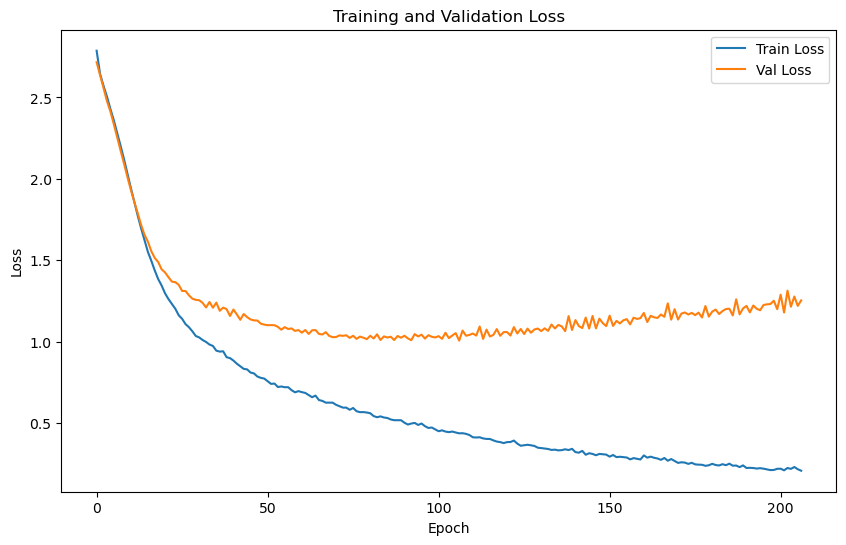

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.2135 | Test Accuracy: 53.64%


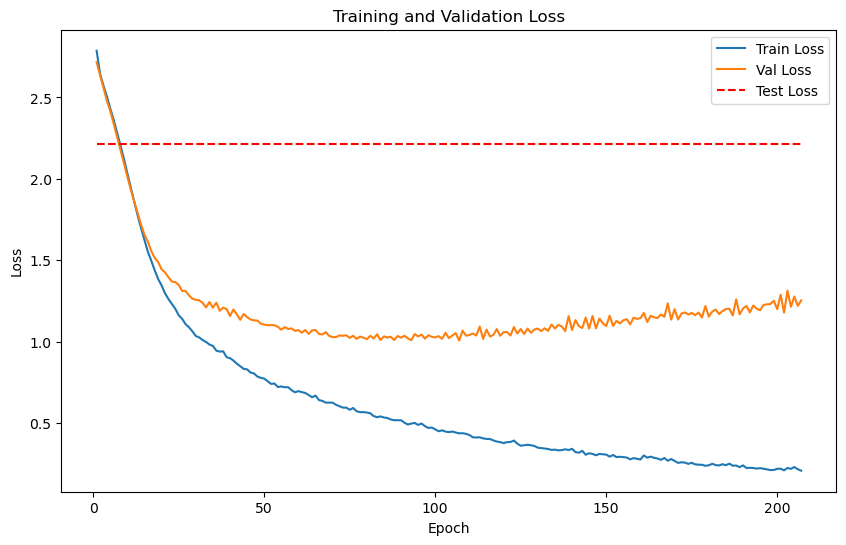

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 9.2349
Epoch [1/2000], Avg Train Loss: 9.2349


Epoch [1/2000], Avg Val Loss: 5.7276
Validation loss improved from inf to 5.7276. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.1419
Epoch [2/2000], Avg Train Loss: 9.1419
Epoch [2/2000], Avg Val Loss: 5.6607
Validation loss improved from 5.7276 to 5.6607. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.0358
Epoch [3/2000], Avg Train Loss: 9.0358
Epoch [3/2000], Avg Val Loss: 5.5958
Validation loss improved from 5.6607 to 5.5958. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.9182
Epoch [4/2000], Avg Train Loss: 8.9182
Epoch [4/2000], Avg Val Loss: 5.5323
Validation loss improved from 5.5958 to 5.5323. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8344
Epoch [5/2000], Avg Train Loss: 8.8344
Epoch [5/2000], Avg Val Loss: 5.4703
Validation loss improved from 5.5323 to 5.4703. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.7973
Ep

    Batch [1/1], Train Loss: 8.3684
Epoch [10/2000], Avg Train Loss: 8.3684
Epoch [10/2000], Avg Val Loss: 5.1800
Validation loss improved from 5.2353 to 5.1800. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 8.3343
Epoch [11/2000], Avg Train Loss: 8.3343
Epoch [11/2000], Avg Val Loss: 5.1261
Validation loss improved from 5.1800 to 5.1261. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.3569
Epoch [12/2000], Avg Train Loss: 8.3569
Epoch [12/2000], Avg Val Loss: 5.0735
Validation loss improved from 5.1261 to 5.0735. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.2166
Epoch [13/2000], Avg Train Loss: 8.2166
Epoch [13/2000], Avg Val Loss: 5.0223
Validation loss improved from 5.0735 to 5.0223. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.0954
Epoch [14/2000], Avg Train Loss: 8.0954
Epoch [14/2000], Avg Val Loss: 4.9724
Validation loss improved from 5.0223 to 4.

    Batch [1/1], Train Loss: 8.0671
Epoch [15/2000], Avg Train Loss: 8.0671
Epoch [15/2000], Avg Val Loss: 4.9237
Validation loss improved from 4.9724 to 4.9237. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.9993
Epoch [16/2000], Avg Train Loss: 7.9993
Epoch [16/2000], Avg Val Loss: 4.8762
Validation loss improved from 4.9237 to 4.8762. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.9463
Epoch [17/2000], Avg Train Loss: 7.9463
Epoch [17/2000], Avg Val Loss: 4.8301
Validation loss improved from 4.8762 to 4.8301. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.9164
Epoch [18/2000], Avg Train Loss: 7.9164
Epoch [18/2000], Avg Val Loss: 4.7852
Validation loss improved from 4.8301 to 4.7852. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.7784
Epoch [19/2000], Avg Train Loss: 7.7784
Epoch [19/2000], Avg Val Loss: 4.7416
Validation loss improved from 4.7852 to 4.

Epoch [25/2000], Avg Val Loss: 4.5064
Validation loss improved from 4.5426 to 4.5064. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.4157
Epoch [26/2000], Avg Train Loss: 7.4157
Epoch [26/2000], Avg Val Loss: 4.4712
Validation loss improved from 4.5064 to 4.4712. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.3152
Epoch [27/2000], Avg Train Loss: 7.3152
Epoch [27/2000], Avg Val Loss: 4.4370
Validation loss improved from 4.4712 to 4.4370. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.2642
Epoch [28/2000], Avg Train Loss: 7.2642
Epoch [28/2000], Avg Val Loss: 4.4040
Validation loss improved from 4.4370 to 4.4040. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.2778
Epoch [29/2000], Avg Train Loss: 7.2778
Epoch [29/2000], Avg Val Loss: 4.3720
Validation loss improved from 4.4040 to 4.3720. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.8629
Epoch [37/2000], Avg Train Loss: 6.8629
Epoch [37/2000], Avg Val Loss: 4.1530
Validation loss improved from 4.1770 to 4.1530. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.8895
Epoch [38/2000], Avg Train Loss: 6.8895
Epoch [38/2000], Avg Val Loss: 4.1299
Validation loss improved from 4.1530 to 4.1299. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.7254
Epoch [39/2000], Avg Train Loss: 6.7254
Epoch [39/2000], Avg Val Loss: 4.1076
Validation loss improved from 4.1299 to 4.1076. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.6565
Epoch [40/2000], Avg Train Loss: 6.6565
Epoch [40/2000], Avg Val Loss: 4.0861
Validation loss improved from 4.1076 to 4.0861. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.6616
Epoch [41/2000], Avg Train Loss: 6.6616
Epoch [41/2000], Avg Val Loss: 4.0655
Validation loss improved from 4.0861 to 4.

    Batch [1/1], Train Loss: 6.6107
Epoch [43/2000], Avg Train Loss: 6.6107
Epoch [43/2000], Avg Val Loss: 4.0266
Validation loss improved from 4.0457 to 4.0266. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.4699
Epoch [44/2000], Avg Train Loss: 6.4699
Epoch [44/2000], Avg Val Loss: 4.0083
Validation loss improved from 4.0266 to 4.0083. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.4665
Epoch [45/2000], Avg Train Loss: 6.4665
Epoch [45/2000], Avg Val Loss: 3.9907
Validation loss improved from 4.0083 to 3.9907. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.4189
Epoch [46/2000], Avg Train Loss: 6.4189
Epoch [46/2000], Avg Val Loss: 3.9738
Validation loss improved from 3.9907 to 3.9738. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.4960
Epoch [47/2000], Avg Train Loss: 6.4960
Epoch [47/2000], Avg Val Loss: 3.9576
Validation loss improved from 3.9738 to 3.

    Batch [1/1], Train Loss: 5.9833
Epoch [62/2000], Avg Train Loss: 5.9833
Epoch [62/2000], Avg Val Loss: 3.7779
Validation loss improved from 3.7869 to 3.7779. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.9199
Epoch [63/2000], Avg Train Loss: 5.9199
Epoch [63/2000], Avg Val Loss: 3.7694
Validation loss improved from 3.7779 to 3.7694. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 6.0184
Epoch [64/2000], Avg Train Loss: 6.0184
Epoch [64/2000], Avg Val Loss: 3.7611
Validation loss improved from 3.7694 to 3.7611. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.9067
Epoch [65/2000], Avg Train Loss: 5.9067
Epoch [65/2000], Avg Val Loss: 3.7532
Validation loss improved from 3.7611 to 3.7532. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.9008
Epoch [66/2000], Avg Train Loss: 5.9008
Epoch [66/2000], Avg Val Loss: 3.7455
Validation loss improved from 3.7532 to 3.

Epoch [71/2000], Avg Val Loss: 3.7109
Validation loss improved from 3.7173 to 3.7109. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.8249
Epoch [72/2000], Avg Train Loss: 5.8249
Epoch [72/2000], Avg Val Loss: 3.7047
Validation loss improved from 3.7109 to 3.7047. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.7345
Epoch [73/2000], Avg Train Loss: 5.7345
Epoch [73/2000], Avg Val Loss: 3.6987
Validation loss improved from 3.7047 to 3.6987. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.8059
Epoch [74/2000], Avg Train Loss: 5.8059
Epoch [74/2000], Avg Val Loss: 3.6929
Validation loss improved from 3.6987 to 3.6929. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.7639
Epoch [75/2000], Avg Train Loss: 5.7639
Epoch [75/2000], Avg Val Loss: 3.6873
Validation loss improved from 3.6929 to 3.6873. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.7368
Epoch [79/2000], Avg Train Loss: 5.7368
Epoch [79/2000], Avg Val Loss: 3.6668
Validation loss improved from 3.6717 to 3.6668. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.7054
Epoch [80/2000], Avg Train Loss: 5.7054
Epoch [80/2000], Avg Val Loss: 3.6621
Validation loss improved from 3.6668 to 3.6621. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.6934
Epoch [81/2000], Avg Train Loss: 5.6934
Epoch [81/2000], Avg Val Loss: 3.6575
Validation loss improved from 3.6621 to 3.6575. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.7000
Epoch [82/2000], Avg Train Loss: 5.7000
Epoch [82/2000], Avg Val Loss: 3.6531
Validation loss improved from 3.6575 to 3.6531. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.6920
Epoch [83/2000], Avg Train Loss: 5.6920
Epoch [83/2000], Avg Val Loss: 3.6488
Validation loss improved from 3.6531 to 3.

    Batch [1/1], Train Loss: 5.5642
Epoch [100/2000], Avg Train Loss: 5.5642
Epoch [100/2000], Avg Val Loss: 3.5898
Validation loss improved from 3.5927 to 3.5898. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 5.4656
Epoch [101/2000], Avg Train Loss: 5.4656
Epoch [101/2000], Avg Val Loss: 3.5869
Validation loss improved from 3.5898 to 3.5869. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 5.5095
Epoch [102/2000], Avg Train Loss: 5.5095
Epoch [102/2000], Avg Val Loss: 3.5841
Validation loss improved from 3.5869 to 3.5841. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.4812
Epoch [103/2000], Avg Train Loss: 5.4812
Epoch [103/2000], Avg Val Loss: 3.5813
Validation loss improved from 3.5841 to 3.5813. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.4767
Epoch [104/2000], Avg Train Loss: 5.4767
Epoch [104/2000], Avg Val Loss: 3.5786
Validation loss improved fro

    Batch [1/1], Train Loss: 5.4316
Epoch [108/2000], Avg Train Loss: 5.4316
Epoch [108/2000], Avg Val Loss: 3.5680
Validation loss improved from 3.5706 to 3.5680. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4073
Epoch [109/2000], Avg Train Loss: 5.4073
Epoch [109/2000], Avg Val Loss: 3.5654
Validation loss improved from 3.5680 to 3.5654. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.3970
Epoch [110/2000], Avg Train Loss: 5.3970
Epoch [110/2000], Avg Val Loss: 3.5628
Validation loss improved from 3.5654 to 3.5628. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.3981
Epoch [111/2000], Avg Train Loss: 5.3981
Epoch [111/2000], Avg Val Loss: 3.5603
Validation loss improved from 3.5628 to 3.5603. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.4540
Epoch [112/2000], Avg Train Loss: 5.4540
Epoch [112/2000], Avg Val Loss: 3.5579
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3978
Epoch [115/2000], Avg Train Loss: 5.3978
Epoch [115/2000], Avg Val Loss: 3.5506
Validation loss improved from 3.5530 to 3.5506. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 5.3853
Epoch [116/2000], Avg Train Loss: 5.3853
Epoch [116/2000], Avg Val Loss: 3.5482
Validation loss improved from 3.5506 to 3.5482. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 5.4343
Epoch [117/2000], Avg Train Loss: 5.4343
Epoch [117/2000], Avg Val Loss: 3.5458
Validation loss improved from 3.5482 to 3.5458. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.4037
Epoch [118/2000], Avg Train Loss: 5.4037
Epoch [118/2000], Avg Val Loss: 3.5435
Validation loss improved from 3.5458 to 3.5435. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 5.3664
Epoch [119/2000], Avg Train Loss: 5.3664
Epoch [119/2000], Avg Val Loss: 3.5412
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2713
Epoch [136/2000], Avg Train Loss: 5.2713
Epoch [136/2000], Avg Val Loss: 3.5049
Validation loss improved from 3.5069 to 3.5049. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 5.2482
Epoch [137/2000], Avg Train Loss: 5.2482
Epoch [137/2000], Avg Val Loss: 3.5030
Validation loss improved from 3.5049 to 3.5030. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 5.2933
Epoch [138/2000], Avg Train Loss: 5.2933
Epoch [138/2000], Avg Val Loss: 3.5010
Validation loss improved from 3.5030 to 3.5010. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 5.2786
Epoch [139/2000], Avg Train Loss: 5.2786
Epoch [139/2000], Avg Val Loss: 3.4991
Validation loss improved from 3.5010 to 3.4991. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 5.3046
Epoch [140/2000], Avg Train Loss: 5.3046
Epoch [140/2000], Avg Val Loss: 3.4972
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2613
Epoch [142/2000], Avg Train Loss: 5.2613
Epoch [142/2000], Avg Val Loss: 3.4933
Validation loss improved from 3.4952 to 3.4933. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 5.2453
Epoch [143/2000], Avg Train Loss: 5.2453
Epoch [143/2000], Avg Val Loss: 3.4914
Validation loss improved from 3.4933 to 3.4914. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.2992
Epoch [144/2000], Avg Train Loss: 5.2992
Epoch [144/2000], Avg Val Loss: 3.4895
Validation loss improved from 3.4914 to 3.4895. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.2363
Epoch [145/2000], Avg Train Loss: 5.2363
Epoch [145/2000], Avg Val Loss: 3.4876
Validation loss improved from 3.4895 to 3.4876. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2593
Epoch [146/2000], Avg Train Loss: 5.2593
Epoch [146/2000], Avg Val Loss: 3.4858
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2334
Epoch [148/2000], Avg Train Loss: 5.2334
Epoch [148/2000], Avg Val Loss: 3.4820
Validation loss improved from 3.4839 to 3.4820. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 5.2426
Epoch [149/2000], Avg Train Loss: 5.2426
Epoch [149/2000], Avg Val Loss: 3.4801
Validation loss improved from 3.4820 to 3.4801. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 5.2660
Epoch [150/2000], Avg Train Loss: 5.2660
Epoch [150/2000], Avg Val Loss: 3.4783
Validation loss improved from 3.4801 to 3.4783. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 5.2147
Epoch [151/2000], Avg Train Loss: 5.2147
Epoch [151/2000], Avg Val Loss: 3.4765
Validation loss improved from 3.4783 to 3.4765. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 5.2459
Epoch [152/2000], Avg Train Loss: 5.2459
Epoch [152/2000], Avg Val Loss: 3.4747
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1738
Epoch [171/2000], Avg Train Loss: 5.1738
Epoch [171/2000], Avg Val Loss: 3.4422
Validation loss improved from 3.4439 to 3.4422. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 5.1215
Epoch [172/2000], Avg Train Loss: 5.1215
Epoch [172/2000], Avg Val Loss: 3.4406
Validation loss improved from 3.4422 to 3.4406. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 5.1513
Epoch [173/2000], Avg Train Loss: 5.1513
Epoch [173/2000], Avg Val Loss: 3.4390
Validation loss improved from 3.4406 to 3.4390. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 5.1449
Epoch [174/2000], Avg Train Loss: 5.1449
Epoch [174/2000], Avg Val Loss: 3.4375
Validation loss improved from 3.4390 to 3.4375. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 5.1707
Epoch [175/2000], Avg Train Loss: 5.1707
Epoch [175/2000], Avg Val Loss: 3.4359
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1759
Epoch [176/2000], Avg Train Loss: 5.1759
Epoch [176/2000], Avg Val Loss: 3.4344
Validation loss improved from 3.4359 to 3.4344. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 5.1501
Epoch [177/2000], Avg Train Loss: 5.1501
Epoch [177/2000], Avg Val Loss: 3.4328
Validation loss improved from 3.4344 to 3.4328. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 5.1569
Epoch [178/2000], Avg Train Loss: 5.1569
Epoch [178/2000], Avg Val Loss: 3.4313
Validation loss improved from 3.4328 to 3.4313. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 5.1231
Epoch [179/2000], Avg Train Loss: 5.1231
Epoch [179/2000], Avg Val Loss: 3.4298
Validation loss improved from 3.4313 to 3.4298. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 5.1238
Epoch [180/2000], Avg Train Loss: 5.1238
Epoch [180/2000], Avg Val Loss: 3.4283
Validation loss improved fro

Epoch [183/2000], Avg Val Loss: 3.4239
Validation loss improved from 3.4254 to 3.4239. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.1558
Epoch [184/2000], Avg Train Loss: 5.1558
Epoch [184/2000], Avg Val Loss: 3.4225
Validation loss improved from 3.4239 to 3.4225. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 5.1286
Epoch [185/2000], Avg Train Loss: 5.1286
Epoch [185/2000], Avg Val Loss: 3.4211
Validation loss improved from 3.4225 to 3.4211. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 5.0726
Epoch [186/2000], Avg Train Loss: 5.0726
Epoch [186/2000], Avg Val Loss: 3.4196
Validation loss improved from 3.4211 to 3.4196. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 5.1360
Epoch [187/2000], Avg Train Loss: 5.1360
Epoch [187/2000], Avg Val Loss: 3.4182
Validation loss improved from 3.4196 to 3.4182. Saving model...

LOG: Epoch [188/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0454
Epoch [207/2000], Avg Train Loss: 5.0454
Epoch [207/2000], Avg Val Loss: 3.3913
Validation loss improved from 3.3926 to 3.3913. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 5.0353
Epoch [208/2000], Avg Train Loss: 5.0353
Epoch [208/2000], Avg Val Loss: 3.3900
Validation loss improved from 3.3913 to 3.3900. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 5.0582
Epoch [209/2000], Avg Train Loss: 5.0582
Epoch [209/2000], Avg Val Loss: 3.3887
Validation loss improved from 3.3900 to 3.3887. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 5.0579
Epoch [210/2000], Avg Train Loss: 5.0579
Epoch [210/2000], Avg Val Loss: 3.3875
Validation loss improved from 3.3887 to 3.3875. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 5.0640
Epoch [211/2000], Avg Train Loss: 5.0640
Epoch [211/2000], Avg Val Loss: 3.3862
Validation loss improved fro

Epoch [220/2000], Avg Val Loss: 3.3755
Validation loss improved from 3.3766 to 3.3755. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 5.0222
Epoch [221/2000], Avg Train Loss: 5.0222
Epoch [221/2000], Avg Val Loss: 3.3744
Validation loss improved from 3.3755 to 3.3744. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 5.0495
Epoch [222/2000], Avg Train Loss: 5.0495
Epoch [222/2000], Avg Val Loss: 3.3732
Validation loss improved from 3.3744 to 3.3732. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 5.0057
Epoch [223/2000], Avg Train Loss: 5.0057
Epoch [223/2000], Avg Val Loss: 3.3721
Validation loss improved from 3.3732 to 3.3721. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 5.0202
Epoch [224/2000], Avg Train Loss: 5.0202
Epoch [224/2000], Avg Val Loss: 3.3710
Validation loss improved from 3.3721 to 3.3710. Saving model...

LOG: Epoch [225/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9519
Epoch [244/2000], Avg Train Loss: 4.9519
Epoch [244/2000], Avg Val Loss: 3.3501
Validation loss improved from 3.3511 to 3.3501. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.9321
Epoch [245/2000], Avg Train Loss: 4.9321
Epoch [245/2000], Avg Val Loss: 3.3491
Validation loss improved from 3.3501 to 3.3491. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.9823
Epoch [246/2000], Avg Train Loss: 4.9823
Epoch [246/2000], Avg Val Loss: 3.3481
Validation loss improved from 3.3491 to 3.3481. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 4.9714
Epoch [247/2000], Avg Train Loss: 4.9714
Epoch [247/2000], Avg Val Loss: 3.3471
Validation loss improved from 3.3481 to 3.3471. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.9864
Epoch [248/2000], Avg Train Loss: 4.9864
Epoch [248/2000], Avg Val Loss: 3.3461
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9432
Epoch [258/2000], Avg Train Loss: 4.9432
Epoch [258/2000], Avg Val Loss: 3.3362
Validation loss improved from 3.3372 to 3.3362. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.9507
Epoch [259/2000], Avg Train Loss: 4.9507
Epoch [259/2000], Avg Val Loss: 3.3352
Validation loss improved from 3.3362 to 3.3352. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.9511
Epoch [260/2000], Avg Train Loss: 4.9511
Epoch [260/2000], Avg Val Loss: 3.3342
Validation loss improved from 3.3352 to 3.3342. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.9485
Epoch [261/2000], Avg Train Loss: 4.9485
Epoch [261/2000], Avg Val Loss: 3.3332
Validation loss improved from 3.3342 to 3.3332. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.9113
Epoch [262/2000], Avg Train Loss: 4.9113
Epoch [262/2000], Avg Val Loss: 3.3323
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9114
Epoch [281/2000], Avg Train Loss: 4.9114
Epoch [281/2000], Avg Val Loss: 3.3167
Validation loss improved from 3.3175 to 3.3167. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 4.8960
Epoch [282/2000], Avg Train Loss: 4.8960
Epoch [282/2000], Avg Val Loss: 3.3159
Validation loss improved from 3.3167 to 3.3159. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 4.9299
Epoch [283/2000], Avg Train Loss: 4.9299
Epoch [283/2000], Avg Val Loss: 3.3152
Validation loss improved from 3.3159 to 3.3152. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.8991
Epoch [284/2000], Avg Train Loss: 4.8991
Epoch [284/2000], Avg Val Loss: 3.3144
Validation loss improved from 3.3152 to 3.3144. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.9119
Epoch [285/2000], Avg Train Loss: 4.9119
Epoch [285/2000], Avg Val Loss: 3.3136
Validation loss improved fro

Epoch [293/2000], Avg Val Loss: 3.3075
Validation loss improved from 3.3083 to 3.3075. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.8361
Epoch [294/2000], Avg Train Loss: 4.8361
Epoch [294/2000], Avg Val Loss: 3.3068
Validation loss improved from 3.3075 to 3.3068. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.8474
Epoch [295/2000], Avg Train Loss: 4.8474
Epoch [295/2000], Avg Val Loss: 3.3061
Validation loss improved from 3.3068 to 3.3061. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.8653
Epoch [296/2000], Avg Train Loss: 4.8653
Epoch [296/2000], Avg Val Loss: 3.3054
Validation loss improved from 3.3061 to 3.3054. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.8861
Epoch [297/2000], Avg Train Loss: 4.8861
Epoch [297/2000], Avg Val Loss: 3.3047
Validation loss improved from 3.3054 to 3.3047. Saving model...

LOG: Epoch [298/2000] - Training
    Bat

Epoch [313/2000], Avg Val Loss: 3.2934
Validation loss improved from 3.2941 to 3.2934. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.8740
Epoch [314/2000], Avg Train Loss: 4.8740
Epoch [314/2000], Avg Val Loss: 3.2927
Validation loss improved from 3.2934 to 3.2927. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.8720
Epoch [315/2000], Avg Train Loss: 4.8720
Epoch [315/2000], Avg Val Loss: 3.2920
Validation loss improved from 3.2927 to 3.2920. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.8105
Epoch [316/2000], Avg Train Loss: 4.8105
Epoch [316/2000], Avg Val Loss: 3.2913
Validation loss improved from 3.2920 to 3.2913. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 4.8508
Epoch [317/2000], Avg Train Loss: 4.8508
Epoch [317/2000], Avg Val Loss: 3.2906
Validation loss improved from 3.2913 to 3.2906. Saving model...

LOG: Epoch [318/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8450
Epoch [327/2000], Avg Train Loss: 4.8450
Epoch [327/2000], Avg Val Loss: 3.2837
Validation loss improved from 3.2844 to 3.2837. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8173
Epoch [328/2000], Avg Train Loss: 4.8173
Epoch [328/2000], Avg Val Loss: 3.2830
Validation loss improved from 3.2837 to 3.2830. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.8269
Epoch [329/2000], Avg Train Loss: 4.8269
Epoch [329/2000], Avg Val Loss: 3.2824
Validation loss improved from 3.2830 to 3.2824. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.8887
Epoch [330/2000], Avg Train Loss: 4.8887
Epoch [330/2000], Avg Val Loss: 3.2817
Validation loss improved from 3.2824 to 3.2817. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.8326
Epoch [331/2000], Avg Train Loss: 4.8326
Epoch [331/2000], Avg Val Loss: 3.2811
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7848
Epoch [351/2000], Avg Train Loss: 4.7848
Epoch [351/2000], Avg Val Loss: 3.2691
Validation loss improved from 3.2697 to 3.2691. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 4.8010
Epoch [352/2000], Avg Train Loss: 4.8010
Epoch [352/2000], Avg Val Loss: 3.2685
Validation loss improved from 3.2691 to 3.2685. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 4.7764
Epoch [353/2000], Avg Train Loss: 4.7764
Epoch [353/2000], Avg Val Loss: 3.2679
Validation loss improved from 3.2685 to 3.2679. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 4.8003
Epoch [354/2000], Avg Train Loss: 4.8003
Epoch [354/2000], Avg Val Loss: 3.2673
Validation loss improved from 3.2679 to 3.2673. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.8074
Epoch [355/2000], Avg Train Loss: 4.8074
Epoch [355/2000], Avg Val Loss: 3.2667
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7950
Epoch [357/2000], Avg Train Loss: 4.7950
Epoch [357/2000], Avg Val Loss: 3.2656
Validation loss improved from 3.2661 to 3.2656. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.7754
Epoch [358/2000], Avg Train Loss: 4.7754
Epoch [358/2000], Avg Val Loss: 3.2650
Validation loss improved from 3.2656 to 3.2650. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.8059
Epoch [359/2000], Avg Train Loss: 4.8059
Epoch [359/2000], Avg Val Loss: 3.2644
Validation loss improved from 3.2650 to 3.2644. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.7624
Epoch [360/2000], Avg Train Loss: 4.7624
Epoch [360/2000], Avg Val Loss: 3.2638
Validation loss improved from 3.2644 to 3.2638. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.7847
Epoch [361/2000], Avg Train Loss: 4.7847
Epoch [361/2000], Avg Val Loss: 3.2633
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7746
Epoch [373/2000], Avg Train Loss: 4.7746
Epoch [373/2000], Avg Val Loss: 3.2569
Validation loss improved from 3.2574 to 3.2569. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.7577
Epoch [374/2000], Avg Train Loss: 4.7577
Epoch [374/2000], Avg Val Loss: 3.2564
Validation loss improved from 3.2569 to 3.2564. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.7694
Epoch [375/2000], Avg Train Loss: 4.7694
Epoch [375/2000], Avg Val Loss: 3.2560
Validation loss improved from 3.2564 to 3.2560. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.7691
Epoch [376/2000], Avg Train Loss: 4.7691
Epoch [376/2000], Avg Val Loss: 3.2556
Validation loss improved from 3.2560 to 3.2556. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.7467
Epoch [377/2000], Avg Train Loss: 4.7467
Epoch [377/2000], Avg Val Loss: 3.2551
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7140
Epoch [395/2000], Avg Train Loss: 4.7140
Epoch [395/2000], Avg Val Loss: 3.2468
Validation loss improved from 3.2473 to 3.2468. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.7160
Epoch [396/2000], Avg Train Loss: 4.7160
Epoch [396/2000], Avg Val Loss: 3.2462
Validation loss improved from 3.2468 to 3.2462. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.7580
Epoch [397/2000], Avg Train Loss: 4.7580
Epoch [397/2000], Avg Val Loss: 3.2457
Validation loss improved from 3.2462 to 3.2457. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.7518
Epoch [398/2000], Avg Train Loss: 4.7518
Epoch [398/2000], Avg Val Loss: 3.2452
Validation loss improved from 3.2457 to 3.2452. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.7236
Epoch [399/2000], Avg Train Loss: 4.7236
Epoch [399/2000], Avg Val Loss: 3.2447
Validation loss improved fro

Epoch [410/2000], Avg Val Loss: 3.2389
Validation loss improved from 3.2395 to 3.2389. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.6742
Epoch [411/2000], Avg Train Loss: 4.6742
Epoch [411/2000], Avg Val Loss: 3.2384
Validation loss improved from 3.2389 to 3.2384. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.7130
Epoch [412/2000], Avg Train Loss: 4.7130
Epoch [412/2000], Avg Val Loss: 3.2380
Validation loss improved from 3.2384 to 3.2380. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.7278
Epoch [413/2000], Avg Train Loss: 4.7278
Epoch [413/2000], Avg Val Loss: 3.2375
Validation loss improved from 3.2380 to 3.2375. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.7304
Epoch [414/2000], Avg Train Loss: 4.7304
Epoch [414/2000], Avg Val Loss: 3.2371
Validation loss improved from 3.2375 to 3.2371. Saving model...

LOG: Epoch [415/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7139
Epoch [429/2000], Avg Train Loss: 4.7139
Epoch [429/2000], Avg Val Loss: 3.2310
Validation loss improved from 3.2313 to 3.2310. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.6966
Epoch [430/2000], Avg Train Loss: 4.6966
Epoch [430/2000], Avg Val Loss: 3.2306
Validation loss improved from 3.2310 to 3.2306. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.6737
Epoch [431/2000], Avg Train Loss: 4.6737
Epoch [431/2000], Avg Val Loss: 3.2302
Validation loss improved from 3.2306 to 3.2302. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 4.6715
Epoch [432/2000], Avg Train Loss: 4.6715
Epoch [432/2000], Avg Val Loss: 3.2298
Validation loss improved from 3.2302 to 3.2298. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.7009
Epoch [433/2000], Avg Train Loss: 4.7009
Epoch [433/2000], Avg Val Loss: 3.2294
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6750
Epoch [449/2000], Avg Train Loss: 4.6750
Epoch [449/2000], Avg Val Loss: 3.2233
Validation loss improved from 3.2237 to 3.2233. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.6841
Epoch [450/2000], Avg Train Loss: 4.6841
Epoch [450/2000], Avg Val Loss: 3.2229
Validation loss improved from 3.2233 to 3.2229. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.6855
Epoch [451/2000], Avg Train Loss: 4.6855
Epoch [451/2000], Avg Val Loss: 3.2226
Validation loss improved from 3.2229 to 3.2226. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.6608
Epoch [452/2000], Avg Train Loss: 4.6608
Epoch [452/2000], Avg Val Loss: 3.2223
Validation loss improved from 3.2226 to 3.2223. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 4.6850
Epoch [453/2000], Avg Train Loss: 4.6850
Epoch [453/2000], Avg Val Loss: 3.2220
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6217
Epoch [467/2000], Avg Train Loss: 4.6217
Epoch [467/2000], Avg Val Loss: 3.2175
Validation loss improved from 3.2177 to 3.2175. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 4.6477
Epoch [468/2000], Avg Train Loss: 4.6477
Epoch [468/2000], Avg Val Loss: 3.2172
Validation loss improved from 3.2175 to 3.2172. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 4.6700
Epoch [469/2000], Avg Train Loss: 4.6700
Epoch [469/2000], Avg Val Loss: 3.2169
Validation loss improved from 3.2172 to 3.2169. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 4.6297
Epoch [470/2000], Avg Train Loss: 4.6297
Epoch [470/2000], Avg Val Loss: 3.2167
Validation loss improved from 3.2169 to 3.2167. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.6666
Epoch [471/2000], Avg Train Loss: 4.6666
Epoch [471/2000], Avg Val Loss: 3.2164
Validation loss improved fro

Epoch [489/2000], Avg Val Loss: 3.2113
Validation loss improved from 3.2116 to 3.2113. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.6546
Epoch [490/2000], Avg Train Loss: 4.6546
Epoch [490/2000], Avg Val Loss: 3.2110
Validation loss improved from 3.2113 to 3.2110. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.6484
Epoch [491/2000], Avg Train Loss: 4.6484
Epoch [491/2000], Avg Val Loss: 3.2106
Validation loss improved from 3.2110 to 3.2106. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.6497
Epoch [492/2000], Avg Train Loss: 4.6497
Epoch [492/2000], Avg Val Loss: 3.2103
Validation loss improved from 3.2106 to 3.2103. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.6508
Epoch [493/2000], Avg Train Loss: 4.6508
Epoch [493/2000], Avg Val Loss: 3.2100
Validation loss improved from 3.2103 to 3.2100. Saving model...

LOG: Epoch [494/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6376
Epoch [505/2000], Avg Train Loss: 4.6376
Epoch [505/2000], Avg Val Loss: 3.2056
Validation loss improved from 3.2060 to 3.2056. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.6284
Epoch [506/2000], Avg Train Loss: 4.6284
Epoch [506/2000], Avg Val Loss: 3.2053
Validation loss improved from 3.2056 to 3.2053. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.6280
Epoch [507/2000], Avg Train Loss: 4.6280
Epoch [507/2000], Avg Val Loss: 3.2050
Validation loss improved from 3.2053 to 3.2050. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.6625
Epoch [508/2000], Avg Train Loss: 4.6625
Epoch [508/2000], Avg Val Loss: 3.2046
Validation loss improved from 3.2050 to 3.2046. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.6228
Epoch [509/2000], Avg Train Loss: 4.6228
Epoch [509/2000], Avg Val Loss: 3.2043
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5869
Epoch [526/2000], Avg Train Loss: 4.5869
Epoch [526/2000], Avg Val Loss: 3.1990
Validation loss improved from 3.1994 to 3.1990. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.5922
Epoch [527/2000], Avg Train Loss: 4.5922
Epoch [527/2000], Avg Val Loss: 3.1987
Validation loss improved from 3.1990 to 3.1987. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.6480
Epoch [528/2000], Avg Train Loss: 4.6480
Epoch [528/2000], Avg Val Loss: 3.1984
Validation loss improved from 3.1987 to 3.1984. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.5960
Epoch [529/2000], Avg Train Loss: 4.5960
Epoch [529/2000], Avg Val Loss: 3.1981
Validation loss improved from 3.1984 to 3.1981. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.6012
Epoch [530/2000], Avg Train Loss: 4.6012
Epoch [530/2000], Avg Val Loss: 3.1978
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5887
Epoch [542/2000], Avg Train Loss: 4.5887
Epoch [542/2000], Avg Val Loss: 3.1948
Validation loss improved from 3.1951 to 3.1948. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 4.6027
Epoch [543/2000], Avg Train Loss: 4.6027
Epoch [543/2000], Avg Val Loss: 3.1945
Validation loss improved from 3.1948 to 3.1945. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 4.5890
Epoch [544/2000], Avg Train Loss: 4.5890
Epoch [544/2000], Avg Val Loss: 3.1942
Validation loss improved from 3.1945 to 3.1942. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 4.5829
Epoch [545/2000], Avg Train Loss: 4.5829
Epoch [545/2000], Avg Val Loss: 3.1939
Validation loss improved from 3.1942 to 3.1939. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.5666
Epoch [546/2000], Avg Train Loss: 4.5666
Epoch [546/2000], Avg Val Loss: 3.1936
Validation loss improved fro

Epoch [563/2000], Avg Val Loss: 3.1872
Validation loss improved from 3.1875 to 3.1872. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.5743
Epoch [564/2000], Avg Train Loss: 4.5743
Epoch [564/2000], Avg Val Loss: 3.1870
Validation loss improved from 3.1872 to 3.1870. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.5706
Epoch [565/2000], Avg Train Loss: 4.5706
Epoch [565/2000], Avg Val Loss: 3.1867
Validation loss improved from 3.1870 to 3.1867. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.5678
Epoch [566/2000], Avg Train Loss: 4.5678
Epoch [566/2000], Avg Val Loss: 3.1865
Validation loss improved from 3.1867 to 3.1865. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.5630
Epoch [567/2000], Avg Train Loss: 4.5630
Epoch [567/2000], Avg Val Loss: 3.1863
Validation loss improved from 3.1865 to 3.1863. Saving model...

LOG: Epoch [568/2000] - Training
    Bat

Epoch [577/2000], Avg Val Loss: 3.1839
Validation loss improved from 3.1842 to 3.1839. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.5719
Epoch [578/2000], Avg Train Loss: 4.5719
Epoch [578/2000], Avg Val Loss: 3.1837
Validation loss improved from 3.1839 to 3.1837. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 4.5881
Epoch [579/2000], Avg Train Loss: 4.5881
Epoch [579/2000], Avg Val Loss: 3.1834
Validation loss improved from 3.1837 to 3.1834. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.5554
Epoch [580/2000], Avg Train Loss: 4.5554
Epoch [580/2000], Avg Val Loss: 3.1832
Validation loss improved from 3.1834 to 3.1832. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.5763
Epoch [581/2000], Avg Train Loss: 4.5763
Epoch [581/2000], Avg Val Loss: 3.1830
Validation loss improved from 3.1832 to 3.1830. Saving model...

LOG: Epoch [582/2000] - Training
    Bat

Epoch [601/2000], Avg Val Loss: 3.1771
Validation loss improved from 3.1774 to 3.1771. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 4.5413
Epoch [602/2000], Avg Train Loss: 4.5413
Epoch [602/2000], Avg Val Loss: 3.1768
Validation loss improved from 3.1771 to 3.1768. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 4.5955
Epoch [603/2000], Avg Train Loss: 4.5955
Epoch [603/2000], Avg Val Loss: 3.1764
Validation loss improved from 3.1768 to 3.1764. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 4.5384
Epoch [604/2000], Avg Train Loss: 4.5384
Epoch [604/2000], Avg Val Loss: 3.1761
Validation loss improved from 3.1764 to 3.1761. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.5622
Epoch [605/2000], Avg Train Loss: 4.5622
Epoch [605/2000], Avg Val Loss: 3.1757
Validation loss improved from 3.1761 to 3.1757. Saving model...

LOG: Epoch [606/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5570
Epoch [615/2000], Avg Train Loss: 4.5570
Epoch [615/2000], Avg Val Loss: 3.1724
Validation loss improved from 3.1727 to 3.1724. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.5561
Epoch [616/2000], Avg Train Loss: 4.5561
Epoch [616/2000], Avg Val Loss: 3.1720
Validation loss improved from 3.1724 to 3.1720. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.5348
Epoch [617/2000], Avg Train Loss: 4.5348
Epoch [617/2000], Avg Val Loss: 3.1717
Validation loss improved from 3.1720 to 3.1717. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.5576
Epoch [618/2000], Avg Train Loss: 4.5576
Epoch [618/2000], Avg Val Loss: 3.1713
Validation loss improved from 3.1717 to 3.1713. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.5246
Epoch [619/2000], Avg Train Loss: 4.5246
Epoch [619/2000], Avg Val Loss: 3.1710
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5321
Epoch [640/2000], Avg Train Loss: 4.5321
Epoch [640/2000], Avg Val Loss: 3.1651
Validation loss improved from 3.1654 to 3.1651. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 4.5418
Epoch [641/2000], Avg Train Loss: 4.5418
Epoch [641/2000], Avg Val Loss: 3.1648
Validation loss improved from 3.1651 to 3.1648. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 4.5251
Epoch [642/2000], Avg Train Loss: 4.5251
Epoch [642/2000], Avg Val Loss: 3.1646
Validation loss improved from 3.1648 to 3.1646. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.5293
Epoch [643/2000], Avg Train Loss: 4.5293
Epoch [643/2000], Avg Val Loss: 3.1643
Validation loss improved from 3.1646 to 3.1643. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.5181
Epoch [644/2000], Avg Train Loss: 4.5181
Epoch [644/2000], Avg Val Loss: 3.1642
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4952
Epoch [652/2000], Avg Train Loss: 4.4952
Epoch [652/2000], Avg Val Loss: 3.1625
Validation loss improved from 3.1627 to 3.1625. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 4.5131
Epoch [653/2000], Avg Train Loss: 4.5131
Epoch [653/2000], Avg Val Loss: 3.1623
Validation loss improved from 3.1625 to 3.1623. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.5394
Epoch [654/2000], Avg Train Loss: 4.5394
Epoch [654/2000], Avg Val Loss: 3.1621
Validation loss improved from 3.1623 to 3.1621. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.5230
Epoch [655/2000], Avg Train Loss: 4.5230
Epoch [655/2000], Avg Val Loss: 3.1619
Validation loss improved from 3.1621 to 3.1619. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.5126
Epoch [656/2000], Avg Train Loss: 4.5126
Epoch [656/2000], Avg Val Loss: 3.1617
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4845
Epoch [683/2000], Avg Train Loss: 4.4845
Epoch [683/2000], Avg Val Loss: 3.1548
Validation loss improved from 3.1551 to 3.1548. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.4934
Epoch [684/2000], Avg Train Loss: 4.4934
Epoch [684/2000], Avg Val Loss: 3.1546
Validation loss improved from 3.1548 to 3.1546. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.4957
Epoch [685/2000], Avg Train Loss: 4.4957
Epoch [685/2000], Avg Val Loss: 3.1543
Validation loss improved from 3.1546 to 3.1543. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 4.4814
Epoch [686/2000], Avg Train Loss: 4.4814
Epoch [686/2000], Avg Val Loss: 3.1541
Validation loss improved from 3.1543 to 3.1541. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 4.4579
Epoch [687/2000], Avg Train Loss: 4.4579
Epoch [687/2000], Avg Val Loss: 3.1539
Validation loss improved fro

Epoch [688/2000], Avg Val Loss: 3.1537
Validation loss improved from 3.1539 to 3.1537. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 4.5156
Epoch [689/2000], Avg Train Loss: 4.5156
Epoch [689/2000], Avg Val Loss: 3.1534
Validation loss improved from 3.1537 to 3.1534. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 4.5264
Epoch [690/2000], Avg Train Loss: 4.5264
Epoch [690/2000], Avg Val Loss: 3.1533
Validation loss improved from 3.1534 to 3.1533. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 4.5195
Epoch [691/2000], Avg Train Loss: 4.5195
Epoch [691/2000], Avg Val Loss: 3.1531
Validation loss improved from 3.1533 to 3.1531. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 4.5106
Epoch [692/2000], Avg Train Loss: 4.5106
Epoch [692/2000], Avg Val Loss: 3.1529
Validation loss improved from 3.1531 to 3.1529. Saving model...

LOG: Epoch [693/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4622
Epoch [720/2000], Avg Train Loss: 4.4622
Epoch [720/2000], Avg Val Loss: 3.1470
Validation loss improved from 3.1473 to 3.1470. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 4.5056
Epoch [721/2000], Avg Train Loss: 4.5056
Epoch [721/2000], Avg Val Loss: 3.1467
Validation loss improved from 3.1470 to 3.1467. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 4.4764
Epoch [722/2000], Avg Train Loss: 4.4764
Epoch [722/2000], Avg Val Loss: 3.1464
Validation loss improved from 3.1467 to 3.1464. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 4.5037
Epoch [723/2000], Avg Train Loss: 4.5037
Epoch [723/2000], Avg Val Loss: 3.1461
Validation loss improved from 3.1464 to 3.1461. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 4.5013
Epoch [724/2000], Avg Train Loss: 4.5013
Epoch [724/2000], Avg Val Loss: 3.1458
Validation loss improved fro

Epoch [756/2000], Avg Val Loss: 3.1381
Validation loss improved from 3.1382 to 3.1381. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 4.4242
Epoch [757/2000], Avg Train Loss: 4.4242
Epoch [757/2000], Avg Val Loss: 3.1380
Validation loss improved from 3.1381 to 3.1380. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 4.4769
Epoch [758/2000], Avg Train Loss: 4.4769
Epoch [758/2000], Avg Val Loss: 3.1379
Validation loss improved from 3.1380 to 3.1379. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 4.4534
Epoch [759/2000], Avg Train Loss: 4.4534
Epoch [759/2000], Avg Val Loss: 3.1379
Validation loss improved from 3.1379 to 3.1379. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 4.4781
Epoch [760/2000], Avg Train Loss: 4.4781
Epoch [760/2000], Avg Val Loss: 3.1377
Validation loss improved from 3.1379 to 3.1377. Saving model...

LOG: Epoch [761/2000] - Training
    Bat

Epoch [791/2000], Avg Val Loss: 3.1299
Validation loss improved from 3.1301 to 3.1299. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 4.4412
Epoch [792/2000], Avg Train Loss: 4.4412
Epoch [792/2000], Avg Val Loss: 3.1297
Validation loss improved from 3.1299 to 3.1297. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 4.4093
Epoch [793/2000], Avg Train Loss: 4.4093
Epoch [793/2000], Avg Val Loss: 3.1296
Validation loss improved from 3.1297 to 3.1296. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 4.4253
Epoch [794/2000], Avg Train Loss: 4.4253
Epoch [794/2000], Avg Val Loss: 3.1294
Validation loss improved from 3.1296 to 3.1294. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 4.4523
Epoch [795/2000], Avg Train Loss: 4.4523
Epoch [795/2000], Avg Val Loss: 3.1292
Validation loss improved from 3.1294 to 3.1292. Saving model...

LOG: Epoch [796/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4367
Epoch [832/2000], Avg Train Loss: 4.4367
Epoch [832/2000], Avg Val Loss: 3.1200
Validation loss improved from 3.1201 to 3.1200. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 4.3910
Epoch [833/2000], Avg Train Loss: 4.3910
Epoch [833/2000], Avg Val Loss: 3.1198
Validation loss improved from 3.1200 to 3.1198. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 4.4367
Epoch [834/2000], Avg Train Loss: 4.4367
Epoch [834/2000], Avg Val Loss: 3.1197
Validation loss improved from 3.1198 to 3.1197. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 4.4331
Epoch [835/2000], Avg Train Loss: 4.4331
Epoch [835/2000], Avg Val Loss: 3.1196
Validation loss improved from 3.1197 to 3.1196. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 4.3977
Epoch [836/2000], Avg Train Loss: 4.3977
Epoch [836/2000], Avg Val Loss: 3.1195
Validation loss improved fro

Epoch [867/2000], Avg Val Loss: 3.1127
Validation loss improved from 3.1128 to 3.1127. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 4.3973
Epoch [868/2000], Avg Train Loss: 4.3973
Epoch [868/2000], Avg Val Loss: 3.1125
Validation loss improved from 3.1127 to 3.1125. Saving model...

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 4.4079
Epoch [869/2000], Avg Train Loss: 4.4079
Epoch [869/2000], Avg Val Loss: 3.1124
Validation loss improved from 3.1125 to 3.1124. Saving model...

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 4.3887
Epoch [870/2000], Avg Train Loss: 4.3887
Epoch [870/2000], Avg Val Loss: 3.1123
Validation loss improved from 3.1124 to 3.1123. Saving model...

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 4.4314
Epoch [871/2000], Avg Train Loss: 4.4314
Epoch [871/2000], Avg Val Loss: 3.1122
Validation loss improved from 3.1123 to 3.1122. Saving model...

LOG: Epoch [872/2000] - Training
    Bat

Epoch [903/2000], Avg Val Loss: 3.1034
Validation loss improved from 3.1036 to 3.1034. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 4.4045
Epoch [904/2000], Avg Train Loss: 4.4045
Epoch [904/2000], Avg Val Loss: 3.1032
Validation loss improved from 3.1034 to 3.1032. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 4.3854
Epoch [905/2000], Avg Train Loss: 4.3854
Epoch [905/2000], Avg Val Loss: 3.1031
Validation loss improved from 3.1032 to 3.1031. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 4.3632
Epoch [906/2000], Avg Train Loss: 4.3632
Epoch [906/2000], Avg Val Loss: 3.1030
Validation loss improved from 3.1031 to 3.1030. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 4.3913
Epoch [907/2000], Avg Train Loss: 4.3913
Epoch [907/2000], Avg Val Loss: 3.1029
Validation loss improved from 3.1030 to 3.1029. Saving model...

LOG: Epoch [908/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3859
Epoch [940/2000], Avg Train Loss: 4.3859
Epoch [940/2000], Avg Val Loss: 3.0962
Validation loss improved from 3.0966 to 3.0962. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 4.3818
Epoch [941/2000], Avg Train Loss: 4.3818
Epoch [941/2000], Avg Val Loss: 3.0960
Validation loss improved from 3.0962 to 3.0960. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 4.3805
Epoch [942/2000], Avg Train Loss: 4.3805
Epoch [942/2000], Avg Val Loss: 3.0959
Validation loss improved from 3.0960 to 3.0959. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 4.3578
Epoch [943/2000], Avg Train Loss: 4.3578
Epoch [943/2000], Avg Val Loss: 3.0958
Validation loss improved from 3.0959 to 3.0958. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 4.3651
Epoch [944/2000], Avg Train Loss: 4.3651
Epoch [944/2000], Avg Val Loss: 3.0957
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3745
Epoch [977/2000], Avg Train Loss: 4.3745
Epoch [977/2000], Avg Val Loss: 3.0880
Validation loss did not improve. Patience: 3/100

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 4.3618
Epoch [978/2000], Avg Train Loss: 4.3618
Epoch [978/2000], Avg Val Loss: 3.0881
Validation loss did not improve. Patience: 4/100

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 4.3384
Epoch [979/2000], Avg Train Loss: 4.3384
Epoch [979/2000], Avg Val Loss: 3.0881
Validation loss did not improve. Patience: 5/100

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 4.3231
Epoch [980/2000], Avg Train Loss: 4.3231
Epoch [980/2000], Avg Val Loss: 3.0882
Validation loss did not improve. Patience: 6/100

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 4.3616
Epoch [981/2000], Avg Train Loss: 4.3616
Epoch [981/2000], Avg Val Loss: 3.0883
Validation loss did not improve. Patience: 7/100

LOG: Epoch [982/2000] - Training
    B

    Batch [1/1], Train Loss: 4.3054
Epoch [1013/2000], Avg Train Loss: 4.3054
Epoch [1013/2000], Avg Val Loss: 3.0818
Validation loss improved from 3.0821 to 3.0818. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 4.3432
Epoch [1014/2000], Avg Train Loss: 4.3432
Epoch [1014/2000], Avg Val Loss: 3.0817
Validation loss improved from 3.0818 to 3.0817. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 4.3293
Epoch [1015/2000], Avg Train Loss: 4.3293
Epoch [1015/2000], Avg Val Loss: 3.0816
Validation loss improved from 3.0817 to 3.0816. Saving model...

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 4.3498
Epoch [1016/2000], Avg Train Loss: 4.3498
Epoch [1016/2000], Avg Val Loss: 3.0813
Validation loss improved from 3.0816 to 3.0813. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 4.3288
Epoch [1017/2000], Avg Train Loss: 4.3288
Epoch [1017/2000], Avg Val Loss: 3.0811
Validation los

    Batch [1/1], Train Loss: 4.3057
Epoch [1051/2000], Avg Train Loss: 4.3057
Epoch [1051/2000], Avg Val Loss: 3.0747
Validation loss improved from 3.0748 to 3.0747. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 4.3107
Epoch [1052/2000], Avg Train Loss: 4.3107
Epoch [1052/2000], Avg Val Loss: 3.0747
Validation loss improved from 3.0747 to 3.0747. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 4.3272
Epoch [1053/2000], Avg Train Loss: 4.3272
Epoch [1053/2000], Avg Val Loss: 3.0746
Validation loss improved from 3.0747 to 3.0746. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 4.3151
Epoch [1054/2000], Avg Train Loss: 4.3151
Epoch [1054/2000], Avg Val Loss: 3.0744
Validation loss improved from 3.0746 to 3.0744. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 4.3337
Epoch [1055/2000], Avg Train Loss: 4.3337
Epoch [1055/2000], Avg Val Loss: 3.0742
Validation los

    Batch [1/1], Train Loss: 4.3158
Epoch [1088/2000], Avg Train Loss: 4.3158
Epoch [1088/2000], Avg Val Loss: 3.0708
Validation loss improved from 3.0711 to 3.0708. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 4.3333
Epoch [1089/2000], Avg Train Loss: 4.3333
Epoch [1089/2000], Avg Val Loss: 3.0703
Validation loss improved from 3.0708 to 3.0703. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 4.2770
Epoch [1090/2000], Avg Train Loss: 4.2770
Epoch [1090/2000], Avg Val Loss: 3.0699
Validation loss improved from 3.0703 to 3.0699. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 4.3381
Epoch [1091/2000], Avg Train Loss: 4.3381
Epoch [1091/2000], Avg Val Loss: 3.0694
Validation loss improved from 3.0699 to 3.0694. Saving model...

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 4.3234
Epoch [1092/2000], Avg Train Loss: 4.3234
Epoch [1092/2000], Avg Val Loss: 3.0688
Validation los

    Batch [1/1], Train Loss: 4.2472
Epoch [1125/2000], Avg Train Loss: 4.2472
Epoch [1125/2000], Avg Val Loss: 3.0630
Validation loss improved from 3.0633 to 3.0630. Saving model...

LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 4.2880
Epoch [1126/2000], Avg Train Loss: 4.2880
Epoch [1126/2000], Avg Val Loss: 3.0627
Validation loss improved from 3.0630 to 3.0627. Saving model...

LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 4.3191
Epoch [1127/2000], Avg Train Loss: 4.3191
Epoch [1127/2000], Avg Val Loss: 3.0625
Validation loss improved from 3.0627 to 3.0625. Saving model...

LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 4.2922
Epoch [1128/2000], Avg Train Loss: 4.2922
Epoch [1128/2000], Avg Val Loss: 3.0622
Validation loss improved from 3.0625 to 3.0622. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 4.2619
Epoch [1129/2000], Avg Train Loss: 4.2619
Epoch [1129/2000], Avg Val Loss: 3.0620
Validation los

    Batch [1/1], Train Loss: 4.2827
Epoch [1164/2000], Avg Train Loss: 4.2827
Epoch [1164/2000], Avg Val Loss: 3.0542
Validation loss improved from 3.0544 to 3.0542. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 4.3024
Epoch [1165/2000], Avg Train Loss: 4.3024
Epoch [1165/2000], Avg Val Loss: 3.0538
Validation loss improved from 3.0542 to 3.0538. Saving model...

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 4.2650
Epoch [1166/2000], Avg Train Loss: 4.2650
Epoch [1166/2000], Avg Val Loss: 3.0533
Validation loss improved from 3.0538 to 3.0533. Saving model...

LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 4.2733
Epoch [1167/2000], Avg Train Loss: 4.2733
Epoch [1167/2000], Avg Val Loss: 3.0530
Validation loss improved from 3.0533 to 3.0530. Saving model...

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 4.2765
Epoch [1168/2000], Avg Train Loss: 4.2765
Epoch [1168/2000], Avg Val Loss: 3.0527
Validation los

Epoch [1201/2000], Avg Val Loss: 3.0444
Validation loss improved from 3.0447 to 3.0444. Saving model...

LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 4.2535
Epoch [1202/2000], Avg Train Loss: 4.2535
Epoch [1202/2000], Avg Val Loss: 3.0442
Validation loss improved from 3.0444 to 3.0442. Saving model...

LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 4.2773
Epoch [1203/2000], Avg Train Loss: 4.2773
Epoch [1203/2000], Avg Val Loss: 3.0439
Validation loss improved from 3.0442 to 3.0439. Saving model...

LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 4.2806
Epoch [1204/2000], Avg Train Loss: 4.2806
Epoch [1204/2000], Avg Val Loss: 3.0437
Validation loss improved from 3.0439 to 3.0437. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 4.2259
Epoch [1205/2000], Avg Train Loss: 4.2259
Epoch [1205/2000], Avg Val Loss: 3.0437
Validation loss improved from 3.0437 to 3.0437. Saving model...

LOG: Epoch [1206/2000] - Tr

Epoch [1239/2000], Avg Val Loss: 3.0398
Validation loss improved from 3.0403 to 3.0398. Saving model...

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 4.2180
Epoch [1240/2000], Avg Train Loss: 4.2180
Epoch [1240/2000], Avg Val Loss: 3.0396
Validation loss improved from 3.0398 to 3.0396. Saving model...

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 4.2298
Epoch [1241/2000], Avg Train Loss: 4.2298
Epoch [1241/2000], Avg Val Loss: 3.0393
Validation loss improved from 3.0396 to 3.0393. Saving model...

LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 4.2963
Epoch [1242/2000], Avg Train Loss: 4.2963
Epoch [1242/2000], Avg Val Loss: 3.0391
Validation loss improved from 3.0393 to 3.0391. Saving model...

LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 4.2373
Epoch [1243/2000], Avg Train Loss: 4.2373
Epoch [1243/2000], Avg Val Loss: 3.0391
Validation loss improved from 3.0391 to 3.0391. Saving model...

LOG: Epoch [1244/2000] - Tr

Epoch [1274/2000], Avg Val Loss: 3.0364
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 4.2280
Epoch [1275/2000], Avg Train Loss: 4.2280
Epoch [1275/2000], Avg Val Loss: 3.0364
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 4.2100
Epoch [1276/2000], Avg Train Loss: 4.2100
Epoch [1276/2000], Avg Val Loss: 3.0363
Validation loss improved from 3.0364 to 3.0363. Saving model...

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 4.2981
Epoch [1277/2000], Avg Train Loss: 4.2981
Epoch [1277/2000], Avg Val Loss: 3.0361
Validation loss improved from 3.0363 to 3.0361. Saving model...

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 4.2239
Epoch [1278/2000], Avg Train Loss: 4.2239
Epoch [1278/2000], Avg Val Loss: 3.0362
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 4.2589
Ep

    Batch [1/1], Train Loss: 4.2332
Epoch [1310/2000], Avg Train Loss: 4.2332
Epoch [1310/2000], Avg Val Loss: 3.0308
Validation loss improved from 3.0309 to 3.0308. Saving model...

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 4.2076
Epoch [1311/2000], Avg Train Loss: 4.2076
Epoch [1311/2000], Avg Val Loss: 3.0309
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 4.2122
Epoch [1312/2000], Avg Train Loss: 4.2122
Epoch [1312/2000], Avg Val Loss: 3.0309
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1313/2000] - Training
    Batch [1/1], Train Loss: 4.2326
Epoch [1313/2000], Avg Train Loss: 4.2326
Epoch [1313/2000], Avg Val Loss: 3.0311
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 4.2215
Epoch [1314/2000], Avg Train Loss: 4.2215
Epoch [1314/2000], Avg Val Loss: 3.0312
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 4.2212
Epoch [1347/2000], Avg Train Loss: 4.2212
Epoch [1347/2000], Avg Val Loss: 3.0219
Validation loss improved from 3.0222 to 3.0219. Saving model...

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 4.2310
Epoch [1348/2000], Avg Train Loss: 4.2310
Epoch [1348/2000], Avg Val Loss: 3.0216
Validation loss improved from 3.0219 to 3.0216. Saving model...

LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 4.2233
Epoch [1349/2000], Avg Train Loss: 4.2233
Epoch [1349/2000], Avg Val Loss: 3.0213
Validation loss improved from 3.0216 to 3.0213. Saving model...

LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 4.2238
Epoch [1350/2000], Avg Train Loss: 4.2238
Epoch [1350/2000], Avg Val Loss: 3.0210
Validation loss improved from 3.0213 to 3.0210. Saving model...

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 4.1979
Epoch [1351/2000], Avg Train Loss: 4.1979
Epoch [1351/2000], Avg Val Loss: 3.0207
Validation los

    Batch [1/1], Train Loss: 4.2125
Epoch [1385/2000], Avg Train Loss: 4.2125
Epoch [1385/2000], Avg Val Loss: 3.0192
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1386/2000] - Training
    Batch [1/1], Train Loss: 4.1895
Epoch [1386/2000], Avg Train Loss: 4.1895
Epoch [1386/2000], Avg Val Loss: 3.0191
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 4.2026
Epoch [1387/2000], Avg Train Loss: 4.2026
Epoch [1387/2000], Avg Val Loss: 3.0189
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 4.1783
Epoch [1388/2000], Avg Train Loss: 4.1783
Epoch [1388/2000], Avg Val Loss: 3.0190
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 4.2080
Epoch [1389/2000], Avg Train Loss: 4.2080
Epoch [1389/2000], Avg Val Loss: 3.0189
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1390/20

    Batch [1/1], Train Loss: 4.1774
Epoch [1424/2000], Avg Train Loss: 4.1774
Epoch [1424/2000], Avg Val Loss: 3.0137
Validation loss improved from 3.0141 to 3.0137. Saving model...

LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 4.1856
Epoch [1425/2000], Avg Train Loss: 4.1856
Epoch [1425/2000], Avg Val Loss: 3.0133
Validation loss improved from 3.0137 to 3.0133. Saving model...

LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 4.2102
Epoch [1426/2000], Avg Train Loss: 4.2102
Epoch [1426/2000], Avg Val Loss: 3.0131
Validation loss improved from 3.0133 to 3.0131. Saving model...

LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 4.2020
Epoch [1427/2000], Avg Train Loss: 4.2020
Epoch [1427/2000], Avg Val Loss: 3.0128
Validation loss improved from 3.0131 to 3.0128. Saving model...

LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 4.1996
Epoch [1428/2000], Avg Train Loss: 4.1996
Epoch [1428/2000], Avg Val Loss: 3.0125
Validation los

    Batch [1/1], Train Loss: 4.1699
Epoch [1462/2000], Avg Train Loss: 4.1699
Epoch [1462/2000], Avg Val Loss: 3.0042
Validation loss improved from 3.0042 to 3.0042. Saving model...

LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 4.1442
Epoch [1463/2000], Avg Train Loss: 4.1442
Epoch [1463/2000], Avg Val Loss: 3.0041
Validation loss improved from 3.0042 to 3.0041. Saving model...

LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 4.1795
Epoch [1464/2000], Avg Train Loss: 4.1795
Epoch [1464/2000], Avg Val Loss: 3.0038
Validation loss improved from 3.0041 to 3.0038. Saving model...

LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 4.1680
Epoch [1465/2000], Avg Train Loss: 4.1680
Epoch [1465/2000], Avg Val Loss: 3.0035
Validation loss improved from 3.0038 to 3.0035. Saving model...

LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 4.1671
Epoch [1466/2000], Avg Train Loss: 4.1671
Epoch [1466/2000], Avg Val Loss: 3.0033
Validation los

    Batch [1/1], Train Loss: 4.1420
Epoch [1501/2000], Avg Train Loss: 4.1420
Epoch [1501/2000], Avg Val Loss: 3.0050
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 4.1887
Epoch [1502/2000], Avg Train Loss: 4.1887
Epoch [1502/2000], Avg Val Loss: 3.0052
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 4.1639
Epoch [1503/2000], Avg Train Loss: 4.1639
Epoch [1503/2000], Avg Val Loss: 3.0055
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 4.1474
Epoch [1504/2000], Avg Train Loss: 4.1474
Epoch [1504/2000], Avg Val Loss: 3.0056
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 4.1235
Epoch [1505/2000], Avg Train Loss: 4.1235
Epoch [1505/2000], Avg Val Loss: 3.0056
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1506/20

    Batch [1/1], Train Loss: 4.1607
Epoch [1539/2000], Avg Train Loss: 4.1607
Epoch [1539/2000], Avg Val Loss: 3.0065
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 4.1231
Epoch [1540/2000], Avg Train Loss: 4.1231
Epoch [1540/2000], Avg Val Loss: 3.0065
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 4.1614
Epoch [1541/2000], Avg Train Loss: 4.1614
Epoch [1541/2000], Avg Val Loss: 3.0065
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 4.1627
Epoch [1542/2000], Avg Train Loss: 4.1627
Epoch [1542/2000], Avg Val Loss: 3.0066
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 4.1466
Epoch [1543/2000], Avg Train Loss: 4.1466
Epoch [1543/2000], Avg Val Loss: 3.0066
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1544/20

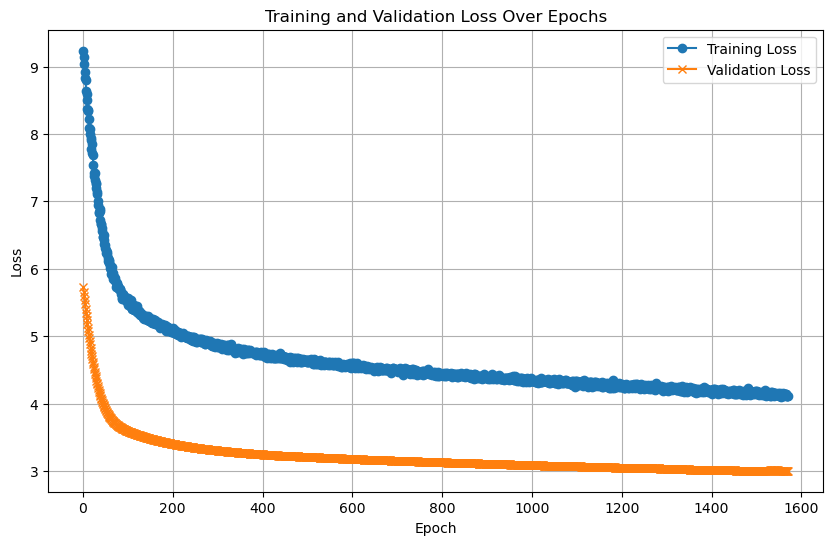

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/39], Loss: 5.3401
Test Batch [20/39], Loss: 5.1854
Test Batch [30/39], Loss: 4.8025

Test Loss: 5.3176


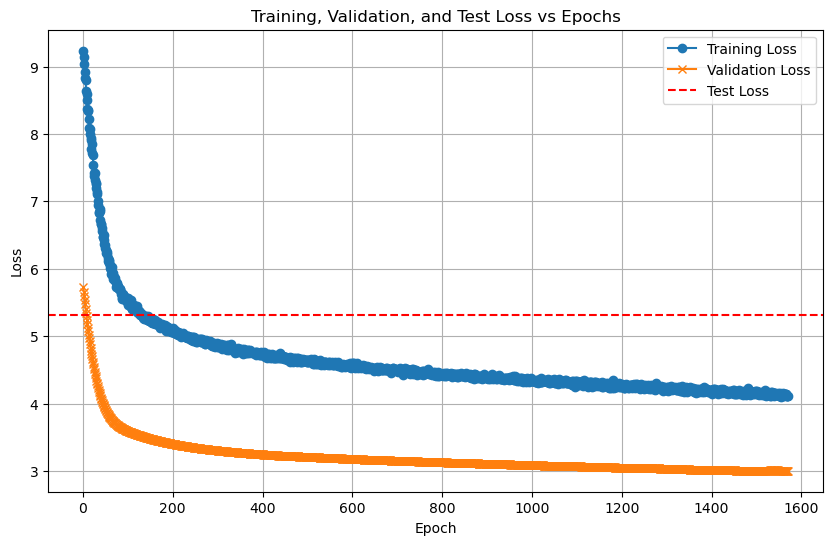

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.33      0.40      0.36         5
           2       0.67      0.40      0.50         5
           3       0.75      0.60      0.67         5
           4       1.00      0.60      0.75         5
           5       0.33      0.40      0.36         5
           6       0.83      1.00      0.91         5
           7       0.80      0.80      0.80         5
           8       0.00      0.00      0.00         0
           9       0.25      0.40      0.31         5
          10       0.50      0.40      0.44         5
          11       0.40      0.40      0.40         5
          12       1.00      1.00      1.00         5
          13       0.6

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8891  |  Val Loss: 2.8911
Validation loss improved from inf to 2.8911.
[Epoch 2/1000] Train Loss: 2.8605  |  Val Loss: 2.8605
Validation loss improved from 2.8911 to 2.8605.
[Epoch 3/1000] Train Loss: 2.8350  |  Val Loss: 2.8344
Validation loss improved from 2.8605 to 2.8344.
[Epoch 4/1000] Train Loss: 2.8107  |  Val Loss: 2.8125
Validation loss improved from 2.8344 to 2.8125.


[Epoch 5/1000] Train Loss: 2.7905  |  Val Loss: 2.7913
Validation loss improved from 2.8125 to 2.7913.
[Epoch 6/1000] Train Loss: 2.7720  |  Val Loss: 2.7713
Validation loss improved from 2.7913 to 2.7713.
[Epoch 7/1000] Train Loss: 2.7537  |  Val Loss: 2.7533
Validation loss improved from 2.7713 to 2.7533.
[Epoch 8/1000] Train Loss: 2.7366  |  Val Loss: 2.7366
Validation loss improved from 2.7533 to 2.7366.
[Epoch 9/1000] Train Loss: 2.7214  |  Val Loss: 2.7208
Validation loss improved from 2.7366 to 2.7208.
[Epoch 10/1000] Train Loss: 2.7055  |  Val Loss: 2.7062
Validation loss improved from 2.7208 to 2.7062.
[Epoch 11/1000] Train Loss: 2.6904  |  Val Loss: 2.6917
Validation loss improved from 2.7062 to 2.6917.
[Epoch 12/1000] Train Loss: 2.6762  |  Val Loss: 2.6763
Validation loss improved from 2.6917 to 2.6763.
[Epoch 13/1000] Train Loss: 2.6606  |  Val Loss: 2.6616
Validation loss improved from 2.6763 to 2.6616.
[Epoch 14/1000] Train Loss: 2.6453  |  Val Loss: 2.6467
Validation lo

[Epoch 17/1000] Train Loss: 2.5998  |  Val Loss: 2.6051
Validation loss improved from 2.6185 to 2.6051.
[Epoch 18/1000] Train Loss: 2.5845  |  Val Loss: 2.5918
Validation loss improved from 2.6051 to 2.5918.
[Epoch 19/1000] Train Loss: 2.5699  |  Val Loss: 2.5792
Validation loss improved from 2.5918 to 2.5792.
[Epoch 20/1000] Train Loss: 2.5562  |  Val Loss: 2.5671
Validation loss improved from 2.5792 to 2.5671.


[Epoch 21/1000] Train Loss: 2.5436  |  Val Loss: 2.5552
Validation loss improved from 2.5671 to 2.5552.
[Epoch 22/1000] Train Loss: 2.5313  |  Val Loss: 2.5441
Validation loss improved from 2.5552 to 2.5441.
[Epoch 23/1000] Train Loss: 2.5199  |  Val Loss: 2.5332
Validation loss improved from 2.5441 to 2.5332.
[Epoch 24/1000] Train Loss: 2.5069  |  Val Loss: 2.5224
Validation loss improved from 2.5332 to 2.5224.


[Epoch 25/1000] Train Loss: 2.4951  |  Val Loss: 2.5113
Validation loss improved from 2.5224 to 2.5113.
[Epoch 26/1000] Train Loss: 2.4827  |  Val Loss: 2.5000
Validation loss improved from 2.5113 to 2.5000.
[Epoch 27/1000] Train Loss: 2.4714  |  Val Loss: 2.4884
Validation loss improved from 2.5000 to 2.4884.
[Epoch 28/1000] Train Loss: 2.4594  |  Val Loss: 2.4764
Validation loss improved from 2.4884 to 2.4764.
[Epoch 29/1000] Train Loss: 2.4474  |  Val Loss: 2.4646
Validation loss improved from 2.4764 to 2.4646.
[Epoch 30/1000] Train Loss: 2.4359  |  Val Loss: 2.4523
Validation loss improved from 2.4646 to 2.4523.
[Epoch 31/1000] Train Loss: 2.4234  |  Val Loss: 2.4409
Validation loss improved from 2.4523 to 2.4409.
[Epoch 32/1000] Train Loss: 2.4112  |  Val Loss: 2.4291
Validation loss improved from 2.4409 to 2.4291.
[Epoch 33/1000] Train Loss: 2.3986  |  Val Loss: 2.4174
Validation loss improved from 2.4291 to 2.4174.
[Epoch 34/1000] Train Loss: 2.3864  |  Val Loss: 2.4049
Validati

[Epoch 35/1000] Train Loss: 2.3735  |  Val Loss: 2.3917
Validation loss improved from 2.4049 to 2.3917.
[Epoch 36/1000] Train Loss: 2.3604  |  Val Loss: 2.3776
Validation loss improved from 2.3917 to 2.3776.
[Epoch 37/1000] Train Loss: 2.3458  |  Val Loss: 2.3633
Validation loss improved from 2.3776 to 2.3633.
[Epoch 38/1000] Train Loss: 2.3314  |  Val Loss: 2.3487
Validation loss improved from 2.3633 to 2.3487.


[Epoch 39/1000] Train Loss: 2.3169  |  Val Loss: 2.3340
Validation loss improved from 2.3487 to 2.3340.
[Epoch 40/1000] Train Loss: 2.3014  |  Val Loss: 2.3200
Validation loss improved from 2.3340 to 2.3200.
[Epoch 41/1000] Train Loss: 2.2871  |  Val Loss: 2.3051
Validation loss improved from 2.3200 to 2.3051.
[Epoch 42/1000] Train Loss: 2.2716  |  Val Loss: 2.2903
Validation loss improved from 2.3051 to 2.2903.


[Epoch 43/1000] Train Loss: 2.2566  |  Val Loss: 2.2745
Validation loss improved from 2.2903 to 2.2745.
[Epoch 44/1000] Train Loss: 2.2404  |  Val Loss: 2.2581
Validation loss improved from 2.2745 to 2.2581.
[Epoch 45/1000] Train Loss: 2.2240  |  Val Loss: 2.2414
Validation loss improved from 2.2581 to 2.2414.
[Epoch 46/1000] Train Loss: 2.2072  |  Val Loss: 2.2239
Validation loss improved from 2.2414 to 2.2239.
[Epoch 47/1000] Train Loss: 2.1900  |  Val Loss: 2.2069
Validation loss improved from 2.2239 to 2.2069.
[Epoch 48/1000] Train Loss: 2.1725  |  Val Loss: 2.1897
Validation loss improved from 2.2069 to 2.1897.
[Epoch 49/1000] Train Loss: 2.1553  |  Val Loss: 2.1718
Validation loss improved from 2.1897 to 2.1718.
[Epoch 50/1000] Train Loss: 2.1379  |  Val Loss: 2.1532
Validation loss improved from 2.1718 to 2.1532.
[Epoch 51/1000] Train Loss: 2.1193  |  Val Loss: 2.1346
Validation loss improved from 2.1532 to 2.1346.
[Epoch 52/1000] Train Loss: 2.1002  |  Val Loss: 2.1164
Validati

[Epoch 53/1000] Train Loss: 2.0815  |  Val Loss: 2.0975
Validation loss improved from 2.1164 to 2.0975.
[Epoch 54/1000] Train Loss: 2.0621  |  Val Loss: 2.0790
Validation loss improved from 2.0975 to 2.0790.
[Epoch 55/1000] Train Loss: 2.0434  |  Val Loss: 2.0605
Validation loss improved from 2.0790 to 2.0605.
[Epoch 56/1000] Train Loss: 2.0246  |  Val Loss: 2.0420
Validation loss improved from 2.0605 to 2.0420.
[Epoch 57/1000] Train Loss: 2.0056  |  Val Loss: 2.0236
Validation loss improved from 2.0420 to 2.0236.


[Epoch 58/1000] Train Loss: 1.9864  |  Val Loss: 2.0054
Validation loss improved from 2.0236 to 2.0054.
[Epoch 59/1000] Train Loss: 1.9682  |  Val Loss: 1.9877
Validation loss improved from 2.0054 to 1.9877.
[Epoch 60/1000] Train Loss: 1.9493  |  Val Loss: 1.9703
Validation loss improved from 1.9877 to 1.9703.
[Epoch 61/1000] Train Loss: 1.9308  |  Val Loss: 1.9532
Validation loss improved from 1.9703 to 1.9532.


[Epoch 62/1000] Train Loss: 1.9123  |  Val Loss: 1.9363
Validation loss improved from 1.9532 to 1.9363.
[Epoch 63/1000] Train Loss: 1.8938  |  Val Loss: 1.9192
Validation loss improved from 1.9363 to 1.9192.
[Epoch 64/1000] Train Loss: 1.8749  |  Val Loss: 1.9024
Validation loss improved from 1.9192 to 1.9024.
[Epoch 65/1000] Train Loss: 1.8568  |  Val Loss: 1.8861
Validation loss improved from 1.9024 to 1.8861.
[Epoch 66/1000] Train Loss: 1.8380  |  Val Loss: 1.8698
Validation loss improved from 1.8861 to 1.8698.
[Epoch 67/1000] Train Loss: 1.8197  |  Val Loss: 1.8540
Validation loss improved from 1.8698 to 1.8540.
[Epoch 68/1000] Train Loss: 1.8020  |  Val Loss: 1.8378
Validation loss improved from 1.8540 to 1.8378.
[Epoch 69/1000] Train Loss: 1.7834  |  Val Loss: 1.8222
Validation loss improved from 1.8378 to 1.8222.


[Epoch 70/1000] Train Loss: 1.7655  |  Val Loss: 1.8052
Validation loss improved from 1.8222 to 1.8052.
[Epoch 71/1000] Train Loss: 1.7476  |  Val Loss: 1.7894
Validation loss improved from 1.8052 to 1.7894.
[Epoch 72/1000] Train Loss: 1.7293  |  Val Loss: 1.7742
Validation loss improved from 1.7894 to 1.7742.
[Epoch 73/1000] Train Loss: 1.7121  |  Val Loss: 1.7595
Validation loss improved from 1.7742 to 1.7595.
[Epoch 74/1000] Train Loss: 1.6942  |  Val Loss: 1.7443
Validation loss improved from 1.7595 to 1.7443.


[Epoch 75/1000] Train Loss: 1.6768  |  Val Loss: 1.7296
Validation loss improved from 1.7443 to 1.7296.
[Epoch 76/1000] Train Loss: 1.6601  |  Val Loss: 1.7152
Validation loss improved from 1.7296 to 1.7152.
[Epoch 77/1000] Train Loss: 1.6427  |  Val Loss: 1.7006
Validation loss improved from 1.7152 to 1.7006.
[Epoch 78/1000] Train Loss: 1.6257  |  Val Loss: 1.6862
Validation loss improved from 1.7006 to 1.6862.


[Epoch 79/1000] Train Loss: 1.6087  |  Val Loss: 1.6718
Validation loss improved from 1.6862 to 1.6718.
[Epoch 80/1000] Train Loss: 1.5918  |  Val Loss: 1.6579
Validation loss improved from 1.6718 to 1.6579.
[Epoch 81/1000] Train Loss: 1.5760  |  Val Loss: 1.6438
Validation loss improved from 1.6579 to 1.6438.
[Epoch 82/1000] Train Loss: 1.5603  |  Val Loss: 1.6307
Validation loss improved from 1.6438 to 1.6307.
[Epoch 83/1000] Train Loss: 1.5432  |  Val Loss: 1.6175
Validation loss improved from 1.6307 to 1.6175.
[Epoch 84/1000] Train Loss: 1.5276  |  Val Loss: 1.6045
Validation loss improved from 1.6175 to 1.6045.
[Epoch 85/1000] Train Loss: 1.5124  |  Val Loss: 1.5916
Validation loss improved from 1.6045 to 1.5916.
[Epoch 86/1000] Train Loss: 1.4966  |  Val Loss: 1.5784
Validation loss improved from 1.5916 to 1.5784.
[Epoch 87/1000] Train Loss: 1.4821  |  Val Loss: 1.5664
Validation loss improved from 1.5784 to 1.5664.


[Epoch 88/1000] Train Loss: 1.4671  |  Val Loss: 1.5545
Validation loss improved from 1.5664 to 1.5545.
[Epoch 89/1000] Train Loss: 1.4519  |  Val Loss: 1.5425
Validation loss improved from 1.5545 to 1.5425.
[Epoch 90/1000] Train Loss: 1.4379  |  Val Loss: 1.5303
Validation loss improved from 1.5425 to 1.5303.
[Epoch 91/1000] Train Loss: 1.4239  |  Val Loss: 1.5196
Validation loss improved from 1.5303 to 1.5196.
[Epoch 92/1000] Train Loss: 1.4098  |  Val Loss: 1.5095
Validation loss improved from 1.5196 to 1.5095.


[Epoch 93/1000] Train Loss: 1.3955  |  Val Loss: 1.4984
Validation loss improved from 1.5095 to 1.4984.
[Epoch 94/1000] Train Loss: 1.3817  |  Val Loss: 1.4873
Validation loss improved from 1.4984 to 1.4873.
[Epoch 95/1000] Train Loss: 1.3682  |  Val Loss: 1.4763
Validation loss improved from 1.4873 to 1.4763.
[Epoch 96/1000] Train Loss: 1.3553  |  Val Loss: 1.4656
Validation loss improved from 1.4763 to 1.4656.


[Epoch 97/1000] Train Loss: 1.3416  |  Val Loss: 1.4549
Validation loss improved from 1.4656 to 1.4549.
[Epoch 98/1000] Train Loss: 1.3288  |  Val Loss: 1.4452
Validation loss improved from 1.4549 to 1.4452.
[Epoch 99/1000] Train Loss: 1.3162  |  Val Loss: 1.4358
Validation loss improved from 1.4452 to 1.4358.
[Epoch 100/1000] Train Loss: 1.3035  |  Val Loss: 1.4264
Validation loss improved from 1.4358 to 1.4264.
[Epoch 101/1000] Train Loss: 1.2908  |  Val Loss: 1.4168
Validation loss improved from 1.4264 to 1.4168.
[Epoch 102/1000] Train Loss: 1.2793  |  Val Loss: 1.4074
Validation loss improved from 1.4168 to 1.4074.
[Epoch 103/1000] Train Loss: 1.2670  |  Val Loss: 1.3983
Validation loss improved from 1.4074 to 1.3983.
[Epoch 104/1000] Train Loss: 1.2548  |  Val Loss: 1.3891
Validation loss improved from 1.3983 to 1.3891.
[Epoch 105/1000] Train Loss: 1.2439  |  Val Loss: 1.3806
Validation loss improved from 1.3891 to 1.3806.
[Epoch 106/1000] Train Loss: 1.2319  |  Val Loss: 1.3719
V

[Epoch 107/1000] Train Loss: 1.2206  |  Val Loss: 1.3644
Validation loss improved from 1.3719 to 1.3644.
[Epoch 108/1000] Train Loss: 1.2100  |  Val Loss: 1.3558
Validation loss improved from 1.3644 to 1.3558.
[Epoch 109/1000] Train Loss: 1.1988  |  Val Loss: 1.3477
Validation loss improved from 1.3558 to 1.3477.
[Epoch 110/1000] Train Loss: 1.1882  |  Val Loss: 1.3405
Validation loss improved from 1.3477 to 1.3405.
[Epoch 111/1000] Train Loss: 1.1780  |  Val Loss: 1.3326
Validation loss improved from 1.3405 to 1.3326.
[Epoch 112/1000] Train Loss: 1.1677  |  Val Loss: 1.3250
Validation loss improved from 1.3326 to 1.3250.
[Epoch 113/1000] Train Loss: 1.1578  |  Val Loss: 1.3177
Validation loss improved from 1.3250 to 1.3177.


[Epoch 114/1000] Train Loss: 1.1478  |  Val Loss: 1.3110
Validation loss improved from 1.3177 to 1.3110.


[Epoch 115/1000] Train Loss: 1.1383  |  Val Loss: 1.3042
Validation loss improved from 1.3110 to 1.3042.
[Epoch 116/1000] Train Loss: 1.1281  |  Val Loss: 1.2975
Validation loss improved from 1.3042 to 1.2975.
[Epoch 117/1000] Train Loss: 1.1190  |  Val Loss: 1.2914
Validation loss improved from 1.2975 to 1.2914.
[Epoch 118/1000] Train Loss: 1.1103  |  Val Loss: 1.2841
Validation loss improved from 1.2914 to 1.2841.
[Epoch 119/1000] Train Loss: 1.1005  |  Val Loss: 1.2778
Validation loss improved from 1.2841 to 1.2778.
[Epoch 120/1000] Train Loss: 1.0917  |  Val Loss: 1.2727
Validation loss improved from 1.2778 to 1.2727.
[Epoch 121/1000] Train Loss: 1.0830  |  Val Loss: 1.2667
Validation loss improved from 1.2727 to 1.2667.
[Epoch 122/1000] Train Loss: 1.0742  |  Val Loss: 1.2614
Validation loss improved from 1.2667 to 1.2614.
[Epoch 123/1000] Train Loss: 1.0668  |  Val Loss: 1.2548
Validation loss improved from 1.2614 to 1.2548.
[Epoch 124/1000] Train Loss: 1.0579  |  Val Loss: 1.249

[Epoch 126/1000] Train Loss: 1.0407  |  Val Loss: 1.2389
Validation loss improved from 1.2438 to 1.2389.
[Epoch 127/1000] Train Loss: 1.0328  |  Val Loss: 1.2340
Validation loss improved from 1.2389 to 1.2340.
[Epoch 128/1000] Train Loss: 1.0245  |  Val Loss: 1.2285
Validation loss improved from 1.2340 to 1.2285.
[Epoch 129/1000] Train Loss: 1.0169  |  Val Loss: 1.2232
Validation loss improved from 1.2285 to 1.2232.
[Epoch 130/1000] Train Loss: 1.0091  |  Val Loss: 1.2187
Validation loss improved from 1.2232 to 1.2187.
[Epoch 131/1000] Train Loss: 1.0010  |  Val Loss: 1.2147
Validation loss improved from 1.2187 to 1.2147.


[Epoch 132/1000] Train Loss: 0.9937  |  Val Loss: 1.2099
Validation loss improved from 1.2147 to 1.2099.
[Epoch 133/1000] Train Loss: 0.9862  |  Val Loss: 1.2056
Validation loss improved from 1.2099 to 1.2056.
[Epoch 134/1000] Train Loss: 0.9788  |  Val Loss: 1.2016
Validation loss improved from 1.2056 to 1.2016.
[Epoch 135/1000] Train Loss: 0.9715  |  Val Loss: 1.1971
Validation loss improved from 1.2016 to 1.1971.
[Epoch 136/1000] Train Loss: 0.9647  |  Val Loss: 1.1923
Validation loss improved from 1.1971 to 1.1923.
[Epoch 137/1000] Train Loss: 0.9569  |  Val Loss: 1.1872
Validation loss improved from 1.1923 to 1.1872.
[Epoch 138/1000] Train Loss: 0.9496  |  Val Loss: 1.1831
Validation loss improved from 1.1872 to 1.1831.
[Epoch 139/1000] Train Loss: 0.9428  |  Val Loss: 1.1794
Validation loss improved from 1.1831 to 1.1794.
[Epoch 140/1000] Train Loss: 0.9360  |  Val Loss: 1.1760
Validation loss improved from 1.1794 to 1.1760.
[Epoch 141/1000] Train Loss: 0.9291  |  Val Loss: 1.172

[Epoch 146/1000] Train Loss: 0.8937  |  Val Loss: 1.1527
Validation loss improved from 1.1552 to 1.1527.
[Epoch 147/1000] Train Loss: 0.8874  |  Val Loss: 1.1495
Validation loss improved from 1.1527 to 1.1495.
[Epoch 148/1000] Train Loss: 0.8811  |  Val Loss: 1.1469
Validation loss improved from 1.1495 to 1.1469.
[Epoch 149/1000] Train Loss: 0.8759  |  Val Loss: 1.1428
Validation loss improved from 1.1469 to 1.1428.
[Epoch 150/1000] Train Loss: 0.8698  |  Val Loss: 1.1395
Validation loss improved from 1.1428 to 1.1395.


[Epoch 151/1000] Train Loss: 0.8641  |  Val Loss: 1.1365
Validation loss improved from 1.1395 to 1.1365.
[Epoch 152/1000] Train Loss: 0.8572  |  Val Loss: 1.1335
Validation loss improved from 1.1365 to 1.1335.
[Epoch 153/1000] Train Loss: 0.8517  |  Val Loss: 1.1309
Validation loss improved from 1.1335 to 1.1309.
[Epoch 154/1000] Train Loss: 0.8461  |  Val Loss: 1.1279
Validation loss improved from 1.1309 to 1.1279.
[Epoch 155/1000] Train Loss: 0.8404  |  Val Loss: 1.1254
Validation loss improved from 1.1279 to 1.1254.
[Epoch 156/1000] Train Loss: 0.8353  |  Val Loss: 1.1227
Validation loss improved from 1.1254 to 1.1227.
[Epoch 157/1000] Train Loss: 0.8310  |  Val Loss: 1.1200
Validation loss improved from 1.1227 to 1.1200.
[Epoch 158/1000] Train Loss: 0.8248  |  Val Loss: 1.1178
Validation loss improved from 1.1200 to 1.1178.
[Epoch 159/1000] Train Loss: 0.8207  |  Val Loss: 1.1165
Validation loss improved from 1.1178 to 1.1165.
[Epoch 160/1000] Train Loss: 0.8143  |  Val Loss: 1.112

[Epoch 165/1000] Train Loss: 0.7899  |  Val Loss: 1.1020
Validation loss improved from 1.1049 to 1.1020.
[Epoch 166/1000] Train Loss: 0.7856  |  Val Loss: 1.0988
Validation loss improved from 1.1020 to 1.0988.
[Epoch 167/1000] Train Loss: 0.7808  |  Val Loss: 1.0970
Validation loss improved from 1.0988 to 1.0970.
[Epoch 168/1000] Train Loss: 0.7754  |  Val Loss: 1.0951
Validation loss improved from 1.0970 to 1.0951.
[Epoch 169/1000] Train Loss: 0.7716  |  Val Loss: 1.0938
Validation loss improved from 1.0951 to 1.0938.


[Epoch 170/1000] Train Loss: 0.7667  |  Val Loss: 1.0918
Validation loss improved from 1.0938 to 1.0918.
[Epoch 171/1000] Train Loss: 0.7631  |  Val Loss: 1.0890
Validation loss improved from 1.0918 to 1.0890.
[Epoch 172/1000] Train Loss: 0.7577  |  Val Loss: 1.0880
Validation loss improved from 1.0890 to 1.0880.
[Epoch 173/1000] Train Loss: 0.7533  |  Val Loss: 1.0858
Validation loss improved from 1.0880 to 1.0858.
[Epoch 174/1000] Train Loss: 0.7490  |  Val Loss: 1.0832
Validation loss improved from 1.0858 to 1.0832.
[Epoch 175/1000] Train Loss: 0.7449  |  Val Loss: 1.0821
Validation loss improved from 1.0832 to 1.0821.
[Epoch 176/1000] Train Loss: 0.7408  |  Val Loss: 1.0804
Validation loss improved from 1.0821 to 1.0804.
[Epoch 177/1000] Train Loss: 0.7366  |  Val Loss: 1.0781
Validation loss improved from 1.0804 to 1.0781.
[Epoch 178/1000] Train Loss: 0.7329  |  Val Loss: 1.0763
Validation loss improved from 1.0781 to 1.0763.
[Epoch 179/1000] Train Loss: 0.7295  |  Val Loss: 1.074

[Epoch 184/1000] Train Loss: 0.7108  |  Val Loss: 1.0685
Validation loss improved from 1.0701 to 1.0685.
[Epoch 185/1000] Train Loss: 0.7071  |  Val Loss: 1.0677
Validation loss improved from 1.0685 to 1.0677.
[Epoch 186/1000] Train Loss: 0.7034  |  Val Loss: 1.0663
Validation loss improved from 1.0677 to 1.0663.
[Epoch 187/1000] Train Loss: 0.7000  |  Val Loss: 1.0649
Validation loss improved from 1.0663 to 1.0649.


[Epoch 188/1000] Train Loss: 0.6974  |  Val Loss: 1.0623
Validation loss improved from 1.0649 to 1.0623.
[Epoch 189/1000] Train Loss: 0.6933  |  Val Loss: 1.0612
Validation loss improved from 1.0623 to 1.0612.
[Epoch 190/1000] Train Loss: 0.6894  |  Val Loss: 1.0610
Validation loss improved from 1.0612 to 1.0610.
[Epoch 191/1000] Train Loss: 0.6861  |  Val Loss: 1.0602
Validation loss improved from 1.0610 to 1.0602.
[Epoch 192/1000] Train Loss: 0.6840  |  Val Loss: 1.0594
Validation loss improved from 1.0602 to 1.0594.
[Epoch 193/1000] Train Loss: 0.6802  |  Val Loss: 1.0578
Validation loss improved from 1.0594 to 1.0578.
[Epoch 194/1000] Train Loss: 0.6765  |  Val Loss: 1.0565
Validation loss improved from 1.0578 to 1.0565.
[Epoch 195/1000] Train Loss: 0.6743  |  Val Loss: 1.0538
Validation loss improved from 1.0565 to 1.0538.
[Epoch 196/1000] Train Loss: 0.6709  |  Val Loss: 1.0539
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 197/1000] Train Loss: 0.6680  |  Val Loss:

[Epoch 203/1000] Train Loss: 0.6510  |  Val Loss: 1.0462
Validation loss improved from 1.0472 to 1.0462.
[Epoch 204/1000] Train Loss: 0.6475  |  Val Loss: 1.0457
Validation loss improved from 1.0462 to 1.0457.
[Epoch 205/1000] Train Loss: 0.6459  |  Val Loss: 1.0468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 206/1000] Train Loss: 0.6425  |  Val Loss: 1.0460
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 207/1000] Train Loss: 0.6400  |  Val Loss: 1.0443
Validation loss improved from 1.0457 to 1.0443.


[Epoch 208/1000] Train Loss: 0.6368  |  Val Loss: 1.0431
Validation loss improved from 1.0443 to 1.0431.
[Epoch 209/1000] Train Loss: 0.6344  |  Val Loss: 1.0434
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 0.6319  |  Val Loss: 1.0429
Validation loss improved from 1.0431 to 1.0429.
[Epoch 211/1000] Train Loss: 0.6302  |  Val Loss: 1.0418
Validation loss improved from 1.0429 to 1.0418.
[Epoch 212/1000] Train Loss: 0.6273  |  Val Loss: 1.0410
Validation loss improved from 1.0418 to 1.0410.
[Epoch 213/1000] Train Loss: 0.6256  |  Val Loss: 1.0404
Validation loss improved from 1.0410 to 1.0404.
[Epoch 214/1000] Train Loss: 0.6225  |  Val Loss: 1.0393
Validation loss improved from 1.0404 to 1.0393.
[Epoch 215/1000] Train Loss: 0.6210  |  Val Loss: 1.0395
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.6177  |  Val Loss: 1.0390
Validation loss improved from 1.0393 to 1.0390.
[Epoch 217/1000] Train Loss: 0.6165  |  Val

[Epoch 222/1000] Train Loss: 0.6054  |  Val Loss: 1.0336
Validation loss improved from 1.0345 to 1.0336.
[Epoch 223/1000] Train Loss: 0.6029  |  Val Loss: 1.0341
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.6000  |  Val Loss: 1.0341
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 0.5986  |  Val Loss: 1.0323
Validation loss improved from 1.0336 to 1.0323.
[Epoch 226/1000] Train Loss: 0.5962  |  Val Loss: 1.0326
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.5941  |  Val Loss: 1.0320
Validation loss improved from 1.0323 to 1.0320.


[Epoch 228/1000] Train Loss: 0.5916  |  Val Loss: 1.0317
Validation loss improved from 1.0320 to 1.0317.
[Epoch 229/1000] Train Loss: 0.5897  |  Val Loss: 1.0310
Validation loss improved from 1.0317 to 1.0310.
[Epoch 230/1000] Train Loss: 0.5880  |  Val Loss: 1.0301
Validation loss improved from 1.0310 to 1.0301.
[Epoch 231/1000] Train Loss: 0.5862  |  Val Loss: 1.0296
Validation loss improved from 1.0301 to 1.0296.
[Epoch 232/1000] Train Loss: 0.5839  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 233/1000] Train Loss: 0.5817  |  Val Loss: 1.0301
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 234/1000] Train Loss: 0.5802  |  Val Loss: 1.0293
Validation loss improved from 1.0296 to 1.0293.
[Epoch 235/1000] Train Loss: 0.5780  |  Val Loss: 1.0288
Validation loss improved from 1.0293 to 1.0288.
[Epoch 236/1000] Train Loss: 0.5767  |  Val Loss: 1.0285
Validation loss improved from 1.0288 to 1.0285.
[Epoch 237/1000] Train Loss: 0.5746  |  Val

[Epoch 240/1000] Train Loss: 0.5696  |  Val Loss: 1.0259
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 241/1000] Train Loss: 0.5672  |  Val Loss: 1.0256
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 242/1000] Train Loss: 0.5658  |  Val Loss: 1.0257
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 243/1000] Train Loss: 0.5640  |  Val Loss: 1.0256
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 244/1000] Train Loss: 0.5631  |  Val Loss: 1.0266
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 245/1000] Train Loss: 0.5603  |  Val Loss: 1.0247
Validation loss improved from 1.0253 to 1.0247.
[Epoch 246/1000] Train Loss: 0.5590  |  Val Loss: 1.0236
Validation loss improved from 1.0247 to 1.0236.
[Epoch 247/1000] Train Loss: 0.5575  |  Val Loss: 1.0249
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.5560  |  Val Loss: 1.0252
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 249/1000] Train Loss: 0.5539  |  Val Loss: 1.0241
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 250/1000] Train Loss: 0.5531  |  Val Loss: 1.0239
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 251/1000] Train Loss: 0.5525  |  Val Loss: 1.0222
Validation loss improved from 1.0236 to 1.0222.
[Epoch 252/1000] Train Loss: 0.5499  |  Val Loss: 1.0238
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 253/1000] Train Loss: 0.5483  |  Val Loss: 1.0224
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 254/1000] Tr

[Epoch 259/1000] Train Loss: 0.5398  |  Val Loss: 1.0198
Validation loss improved from 1.0207 to 1.0198.
[Epoch 260/1000] Train Loss: 0.5374  |  Val Loss: 1.0204
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 261/1000] Train Loss: 0.5360  |  Val Loss: 1.0215
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 262/1000] Train Loss: 0.5357  |  Val Loss: 1.0227
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 263/1000] Train Loss: 0.5344  |  Val Loss: 1.0222
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 264/1000] Train Loss: 0.5322  |  Val Loss: 1.0219
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 265/1000] Train Loss: 0.5304  |  Val Loss: 1.0208
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 266/1000] Train Loss: 0.5296  |  Val Loss: 1.0209
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 267/1000] Train Loss: 0.5281  |  Val Loss: 1.0199
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 268/1000] Train Loss: 0.5266  |  Val Loss: 1.0197
Validation loss improved from 1.0198 to 1.0197.
[Epoch 269/1000] Train Loss: 0.5257  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 0.5240  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 271/1000] Train Loss: 0.5224  |  Val Loss: 1.0214
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 272/1000] Train Loss: 0.5221  |  Val Loss: 1.0210
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 273/1000] Train Loss: 0.5204  |  Val Loss: 1.0198
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 278/1000] Train Loss: 0.5150  |  Val Loss: 1.0202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 279/1000] Train Loss: 0.5134  |  Val Loss: 1.0198
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 0.5115  |  Val Loss: 1.0202
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 281/1000] Train Loss: 0.5110  |  Val Loss: 1.0202
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 282/1000] Train Loss: 0.5092  |  Val Loss: 1.0205
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 283/1000] Train Loss: 0.5088  |  Val Loss: 1.0209
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 284/1000] Train Loss: 0.5068  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 285/1000] Train Loss: 0.5061  |  Val Loss: 1.0199
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 286/1000] Train Loss: 0.5052  |  Val Loss: 1.0201
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 287/1000] Train Loss: 0.5045  |  Val Loss: 1.0194
Validation loss improved from 1.0195 to 1.0194.
[Epoch 288/1000] Train Loss: 0.5041  |  Val Loss: 1.0202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 0.5017  |  Val Loss: 1.0208
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 290/1000] Train Loss: 0.5009  |  Val Loss: 1.0214
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 291/1000] Train Loss: 0.5007  |  Val Loss: 1.0228
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 292/1000] Train Loss: 0.4989  |  Val Loss: 1.0205
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 297/1000] Train Loss: 0.4946  |  Val Loss: 1.0216
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 298/1000] Train Loss: 0.4924  |  Val Loss: 1.0216
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 299/1000] Train Loss: 0.4919  |  Val Loss: 1.0199
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 300/1000] Train Loss: 0.4910  |  Val Loss: 1.0209
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 301/1000] Train Loss: 0.4895  |  Val Loss: 1.0221
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 302/1000] Train Loss: 0.4892  |  Val Loss: 1.0222
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 303/1000] Train Loss: 0.4887  |  Val Loss: 1.0213
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 304/1000] Train Loss: 0.4873  |  Val Loss: 1.0214
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 305/1000] Train Loss: 0.4857  |  Val Loss: 1.0218
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 306/1000] Train Loss: 0.4843  |  Val Loss: 1.0229
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 307/1000] Train Loss: 0.4839  |  Val Loss: 1.0232
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 308/1000] Train Loss: 0.4838  |  Val Loss: 1.0221
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 309/1000] Train Loss: 0.4825  |  Val Loss: 1.0220
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 310/1000] Train Loss: 0.4818  |  Val Loss: 1.0228
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 311/1000] Train Loss: 0.4802  |  Val Loss: 1.0232
!! Validation loss did NOT improve !! Patience: 

[Epoch 317/1000] Train Loss: 0.4753  |  Val Loss: 1.0248
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 318/1000] Train Loss: 0.4750  |  Val Loss: 1.0249
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 319/1000] Train Loss: 0.4739  |  Val Loss: 1.0249
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 320/1000] Train Loss: 0.4737  |  Val Loss: 1.0251
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 321/1000] Train Loss: 0.4721  |  Val Loss: 1.0238
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 322/1000] Train Loss: 0.4718  |  Val Loss: 1.0232
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 323/1000] Train Loss: 0.4703  |  Val Loss: 1.0233
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 324/1000] Train Loss: 0.4698  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 325/1000] Train Loss: 0.4689  |  Val Loss: 1.0269
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 326/1000] Train Loss: 0.4684  |  Val Loss: 1.0287
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 327/1000] Train Loss: 0.4685  |  Val Loss: 1.0276
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 328/1000] Train Loss: 0.4668  |  Val Loss: 1.0256
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 329/1000] Train Loss: 0.4660  |  Val Loss: 1.0255
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 330/1000] Train Loss: 0.4650  |  Val Loss: 1.0271
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 331/1000] Train Loss: 0.4653  |  Val Loss: 1.0272
!! Validation loss did NOT improve !! Patience:

[Epoch 335/1000] Train Loss: 0.4611  |  Val Loss: 1.0285
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 336/1000] Train Loss: 0.4615  |  Val Loss: 1.0287
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 337/1000] Train Loss: 0.4603  |  Val Loss: 1.0285
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 338/1000] Train Loss: 0.4593  |  Val Loss: 1.0286
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 339/1000] Train Loss: 0.4586  |  Val Loss: 1.0296
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 340/1000] Train Loss: 0.4580  |  Val Loss: 1.0295
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 341/1000] Train Loss: 0.4578  |  Val Loss: 1.0287
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 342/1000] Train Loss: 0.4567  |  Val Loss: 1.0295
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 343/1000] Train Loss: 0.4561  |  Val Loss: 1.0301
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 344/1000] Train Loss: 0.4555  |  Val Loss: 1.0309
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 345/1000] Train Loss: 0.4542  |  Val Loss: 1.0298
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 346/1000] Train Loss: 0.4545  |  Val Loss: 1.0300
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 347/1000] Train Loss: 0.4532  |  Val Loss: 1.0306
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 348/1000] Train Loss: 0.4524  |  Val Loss: 1.0303
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 349/1000] Train Loss: 0.4518  |  Val Loss: 1.0302
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 350/1000] Train Loss: 0.4511  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience:

[Epoch 356/1000] Train Loss: 0.4476  |  Val Loss: 1.0320
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 357/1000] Train Loss: 0.4469  |  Val Loss: 1.0340
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 358/1000] Train Loss: 0.4459  |  Val Loss: 1.0347
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 359/1000] Train Loss: 0.4455  |  Val Loss: 1.0328
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 360/1000] Train Loss: 0.4446  |  Val Loss: 1.0342
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 361/1000] Train Loss: 0.4444  |  Val Loss: 1.0351
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 362/1000] Train Loss: 0.4435  |  Val Loss: 1.0348
!! Validation loss did NOT improve !! Patience: 68/100


[Epoch 363/1000] Train Loss: 0.4425  |  Val Loss: 1.0345
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 364/1000] Train Loss: 0.4430  |  Val Loss: 1.0351
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 365/1000] Train Loss: 0.4418  |  Val Loss: 1.0350
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 366/1000] Train Loss: 0.4410  |  Val Loss: 1.0364
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 367/1000] Train Loss: 0.4411  |  Val Loss: 1.0378
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 368/1000] Train Loss: 0.4407  |  Val Loss: 1.0383
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 369/1000] Train Loss: 0.4407  |  Val Loss: 1.0367
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 370/1000] Train Loss: 0.4388  |  Val Loss: 1.0365
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 371/1000] Train Loss: 0.4396  |  Val Loss: 1.0364
!! Validation loss did NOT improve !! Patience:

[Epoch 376/1000] Train Loss: 0.4356  |  Val Loss: 1.0396
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 377/1000] Train Loss: 0.4351  |  Val Loss: 1.0395
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 378/1000] Train Loss: 0.4351  |  Val Loss: 1.0401
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 379/1000] Train Loss: 0.4338  |  Val Loss: 1.0384
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 380/1000] Train Loss: 0.4337  |  Val Loss: 1.0389
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 381/1000] Train Loss: 0.4327  |  Val Loss: 1.0395
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 382/1000] Train Loss: 0.4324  |  Val Loss: 1.0417
!! Validation loss did NOT improve !! Patience: 88/100


[Epoch 383/1000] Train Loss: 0.4314  |  Val Loss: 1.0410
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 384/1000] Train Loss: 0.4312  |  Val Loss: 1.0419
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 385/1000] Train Loss: 0.4301  |  Val Loss: 1.0425
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 386/1000] Train Loss: 0.4304  |  Val Loss: 1.0413
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 387/1000] Train Loss: 0.4290  |  Val Loss: 1.0416
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 388/1000] Train Loss: 0.4293  |  Val Loss: 1.0428
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 389/1000] Train Loss: 0.4291  |  Val Loss: 1.0437
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 390/1000] Train Loss: 0.4282  |  Val Loss: 1.0446
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 391/1000] Train Loss: 0.4278  |  Val Loss: 1.0431
!! Validation loss did NOT improve !! Patience:

[Epoch 393/1000] Train Loss: 0.4262  |  Val Loss: 1.0438
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 394/1000] Train Loss: 0.4267  |  Val Loss: 1.0443
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 394 !!
No improvement for 100 epochs.


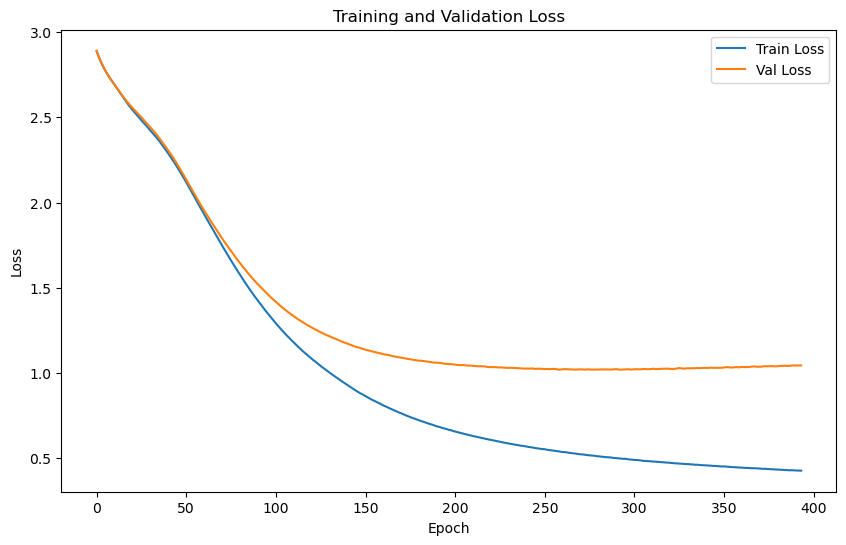

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.6081 | Test Accuracy: 54.03%


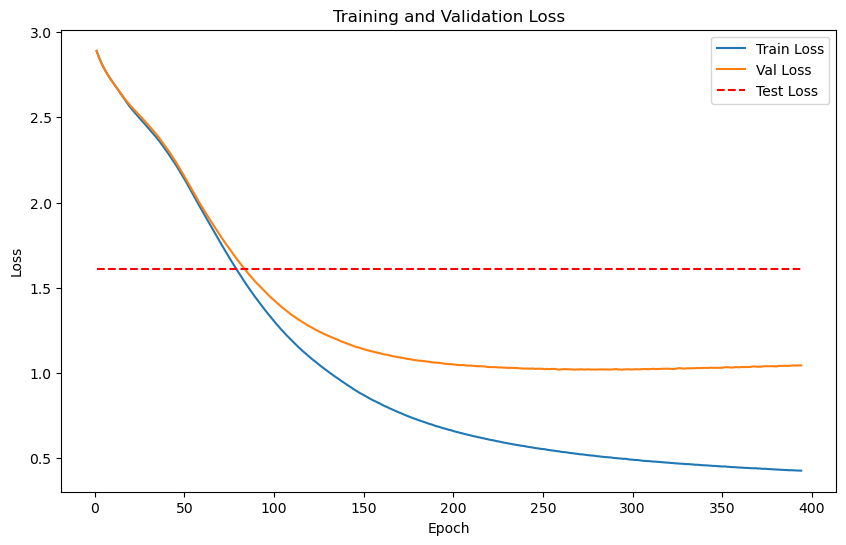

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5405
    Batch [2/2], Val Loss: 0.2544
Epoch [1/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.3974

Validation loss improved from inf to 0.3974. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5391
    Batch [2/2], Val Loss: 0.2566
Epoch [2/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5377
    Batch [2/2], Val Loss: 0.2588
Epoch [3/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.3982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5361
    Batch [2/2], Val Loss: 0.2607
Epoch [4/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.3984

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5347
    Batch [2/2], Val Loss: 0.2627
Epoch [5/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.3987

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5334
    Batch [2/2], Val Loss: 0.2651
Epoch [6/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.3993

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5324
    Batch [2/2], Val Loss: 0.2682
Epoch [7/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.4003

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5315
    Batch [2/2], Val Loss: 0.2710
Epoch [8/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4013

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5307
    Batch [2/2], Val Loss: 0.2736
Epoch [9/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.4021

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.2762
Epoch [10/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.2787
Epoch [11/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4038

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.2810
Epoch [12/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.4046

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.2825
Epoch [13/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4050

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5266
    Batch [2/2], Val Loss: 0.2837
Epoch [14/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4052

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.2851
Epoch [15/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4053

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.2867
Epoch [16/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4056

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.2884
Epoch [17/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4060

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.2901
Epoch [18/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.4064

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.2916
Epoch [19/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4068

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.2930
Epoch [20/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4070

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.2941
Epoch [21/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4071

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.2951
Epoch [22/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4073

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.2960
Epoch [23/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5185
    Batch [2/2], Val Loss: 0.2968
Epoch [24/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4076

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.2975
Epoch [25/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4078

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.2982
Epoch [26/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4079

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.2988
Epoch [27/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4081

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.2997
Epoch [28/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4086

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.3006
Epoch [29/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4090

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.3015
Epoch [30/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4094

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.3023
Epoch [31/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4098

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.3030
Epoch [32/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4101

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.3037
Epoch [33/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4104

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.3043
Epoch [34/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4107

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.3049
Epoch [35/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4110

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.3054
Epoch [36/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4113

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3059
Epoch [37/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4115

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3063
Epoch [38/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4117

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3067
Epoch [39/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4119

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3070
Epoch [40/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4121

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3074
Epoch [41/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4122

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3077
Epoch [42/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4124

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3080
Epoch [43/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4125

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3082
Epoch [44/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3085
Epoch [45/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4128

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.3087
Epoch [46/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.3089
Epoch [47/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.3091
Epoch [48/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4130

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.3092
Epoch [49/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4131

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3094
Epoch [50/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4132

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3095
Epoch [51/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4132

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3096
Epoch [52/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4133

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.3097
Epoch [53/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4133

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3099
Epoch [54/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4134

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3100
Epoch [55/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4134

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3101
Epoch [56/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4135

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3102
Epoch [57/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4135

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3103
Epoch [58/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4136

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3104
Epoch [59/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4136

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3104
Epoch [60/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4137

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3105
Epoch [61/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4137

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3105
Epoch [62/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4137

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3106
Epoch [63/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4137

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3106
Epoch [64/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4138

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3107
Epoch [65/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4138

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3107
Epoch [66/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4138

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3108
Epoch [67/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4138

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3108
Epoch [68/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4138

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3108
Epoch [69/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3108
Epoch [70/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3109
Epoch [71/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3109
Epoch [72/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3109
Epoch [73/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3109
Epoch [74/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3109
Epoch [75/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3109
Epoch [76/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [77/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [78/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [79/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [80/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [81/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [82/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [83/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [84/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [85/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [86/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [87/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [88/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [89/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4139

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [90/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [91/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [92/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [93/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [94/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3110
Epoch [95/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3111
Epoch [96/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3111
Epoch [97/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3111
Epoch [98/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3111
Epoch [99/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3111
Epoch [100/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3111
Epoch [101/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4140

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 101!!
No improvement for 100 epochs


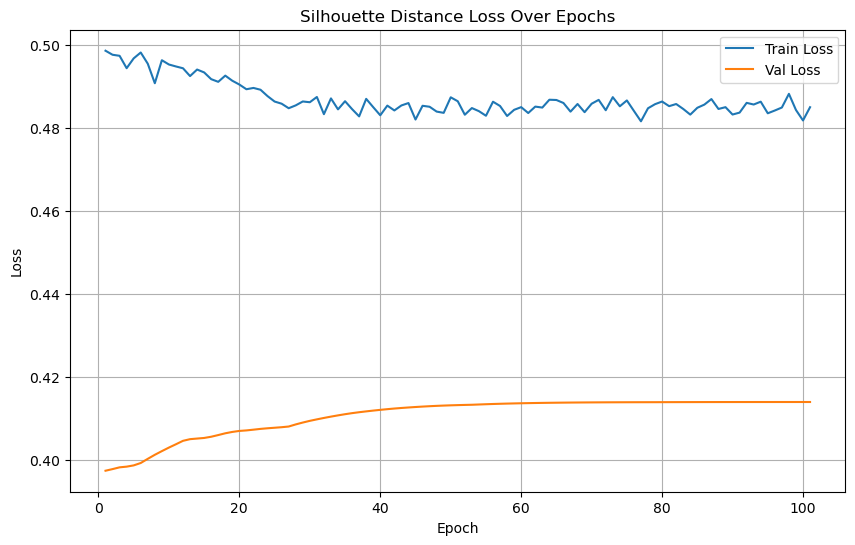

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/154], Loss: 0.2629
Test Batch [20/154], Loss: 0.4199
Test Batch [30/154], Loss: 0.3835
Test Batch [40/154], Loss: 0.2961


Test Batch [50/154], Loss: 0.4248
Test Batch [60/154], Loss: 0.4162
Test Batch [70/154], Loss: 0.2819


Test Batch [80/154], Loss: 0.2619
Test Batch [90/154], Loss: 0.2888
Test Batch [100/154], Loss: 0.2267
Test Batch [110/154], Loss: 0.1711
Test Batch [120/154], Loss: 0.1569


Test Batch [130/154], Loss: 0.2908
Test Batch [140/154], Loss: 0.4172
Test Batch [150/154], Loss: 0.3955

Test Loss: 0.3317


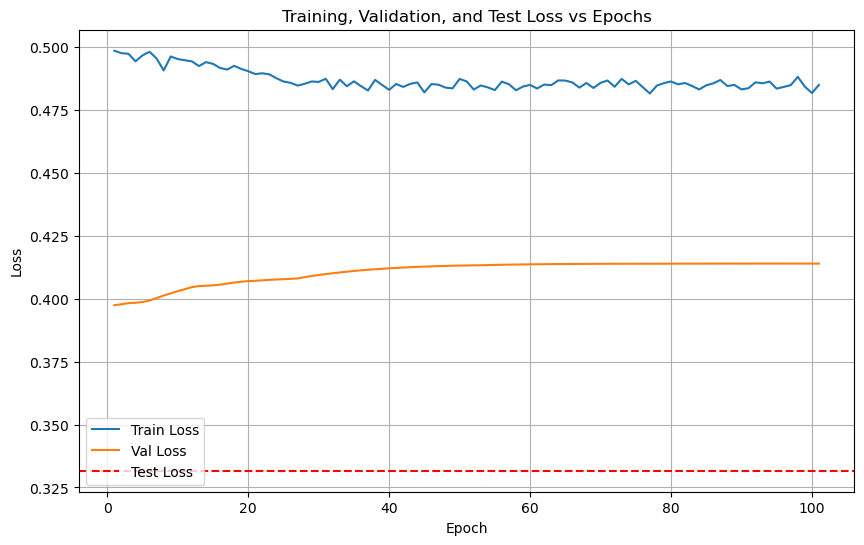

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/154 for test dataset.
  Processed batch 20/154 for test dataset.


  Processed batch 30/154 for test dataset.
  Processed batch 40/154 for test dataset.
  Processed batch 50/154 for test dataset.


  Processed batch 60/154 for test dataset.
  Processed batch 70/154 for test dataset.
  Processed batch 80/154 for test dataset.


  Processed batch 90/154 for test dataset.
  Processed batch 100/154 for test dataset.
  Processed batch 110/154 for test dataset.
  Processed batch 120/154 for test dataset.


  Processed batch 130/154 for test dataset.
  Processed batch 140/154 for test dataset.
  Processed batch 150/154 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.17      0.20      0.18         5
           2       0.67      0.40      0.50         5
           3       0.50      0.40      0.44         5
           4       0.57      0.80      0.67         5
           5       0.33      0.40      0.36         5
           6       1.00      0.80      0.89         5
           7       0.57      0.80      0.67         5
           8       0.00      0.00      0.00         0
           9       0.67      0.40      0.50         5
          10       0.38      0.60      0.46         5
          11       0.40      0.40      0.40         5
          12       1.00      1.00      1.00         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8285  |  Val Loss: 2.7873
Validation loss improved from inf to 2.7873.
[Epoch 2/1000] Train Loss: 2.8119  |  Val Loss: 2.7757
Validation loss improved from 2.7873 to 2.7757.
[Epoch 3/1000] Train Loss: 2.7977  |  Val Loss: 2.7650
Validation loss improved from 2.7757 to 2.7650.
[Epoch 4/1000] Train Loss: 2.7832  |  Val Loss: 2.7550
Validation loss improved from 2.7650 to 2.7550.
[Epoch 5/1000] Train Loss: 2.7705  |  Val Loss: 2.7457
Validation loss improved from 2.7550 to 2.7457.
[Epoch 6/1000] Train Loss: 2.7582  |  Val Loss: 2.7369
Validation loss improved from 2.7457 to 2.7369.
[Epoch 7/1000] Train Loss: 2.7458  |  Val Loss: 2.7283
Validation loss improved from 2.7369 to 2.7283.
[Epoch 8/1000] Train Loss: 2.7335  |  Val Loss: 2.7202
Validation loss improved from 2.7283 to 2.7202.


[Epoch 9/1000] Train Loss: 2.7224  |  Val Loss: 2.7122
Validation loss improved from 2.7202 to 2.7122.
[Epoch 10/1000] Train Loss: 2.7115  |  Val Loss: 2.7045
Validation loss improved from 2.7122 to 2.7045.
[Epoch 11/1000] Train Loss: 2.7015  |  Val Loss: 2.6971
Validation loss improved from 2.7045 to 2.6971.
[Epoch 12/1000] Train Loss: 2.6913  |  Val Loss: 2.6898
Validation loss improved from 2.6971 to 2.6898.
[Epoch 13/1000] Train Loss: 2.6809  |  Val Loss: 2.6824
Validation loss improved from 2.6898 to 2.6824.
[Epoch 14/1000] Train Loss: 2.6707  |  Val Loss: 2.6749
Validation loss improved from 2.6824 to 2.6749.
[Epoch 15/1000] Train Loss: 2.6609  |  Val Loss: 2.6674
Validation loss improved from 2.6749 to 2.6674.
[Epoch 16/1000] Train Loss: 2.6508  |  Val Loss: 2.6600
Validation loss improved from 2.6674 to 2.6600.
[Epoch 17/1000] Train Loss: 2.6411  |  Val Loss: 2.6520
Validation loss improved from 2.6600 to 2.6520.


[Epoch 18/1000] Train Loss: 2.6309  |  Val Loss: 2.6442
Validation loss improved from 2.6520 to 2.6442.


[Epoch 19/1000] Train Loss: 2.6211  |  Val Loss: 2.6363
Validation loss improved from 2.6442 to 2.6363.
[Epoch 20/1000] Train Loss: 2.6108  |  Val Loss: 2.6284
Validation loss improved from 2.6363 to 2.6284.
[Epoch 21/1000] Train Loss: 2.6013  |  Val Loss: 2.6198
Validation loss improved from 2.6284 to 2.6198.
[Epoch 22/1000] Train Loss: 2.5900  |  Val Loss: 2.6118
Validation loss improved from 2.6198 to 2.6118.
[Epoch 23/1000] Train Loss: 2.5801  |  Val Loss: 2.6035
Validation loss improved from 2.6118 to 2.6035.
[Epoch 24/1000] Train Loss: 2.5691  |  Val Loss: 2.5949
Validation loss improved from 2.6035 to 2.5949.
[Epoch 25/1000] Train Loss: 2.5587  |  Val Loss: 2.5864
Validation loss improved from 2.5949 to 2.5864.
[Epoch 26/1000] Train Loss: 2.5478  |  Val Loss: 2.5778
Validation loss improved from 2.5864 to 2.5778.
[Epoch 27/1000] Train Loss: 2.5364  |  Val Loss: 2.5690
Validation loss improved from 2.5778 to 2.5690.
[Epoch 28/1000] Train Loss: 2.5248  |  Val Loss: 2.5602
Validati

[Epoch 30/1000] Train Loss: 2.5010  |  Val Loss: 2.5417
Validation loss improved from 2.5512 to 2.5417.
[Epoch 31/1000] Train Loss: 2.4881  |  Val Loss: 2.5325
Validation loss improved from 2.5417 to 2.5325.
[Epoch 32/1000] Train Loss: 2.4758  |  Val Loss: 2.5231
Validation loss improved from 2.5325 to 2.5231.
[Epoch 33/1000] Train Loss: 2.4626  |  Val Loss: 2.5136
Validation loss improved from 2.5231 to 2.5136.
[Epoch 34/1000] Train Loss: 2.4501  |  Val Loss: 2.5038
Validation loss improved from 2.5136 to 2.5038.
[Epoch 35/1000] Train Loss: 2.4370  |  Val Loss: 2.4938
Validation loss improved from 2.5038 to 2.4938.
[Epoch 36/1000] Train Loss: 2.4229  |  Val Loss: 2.4842
Validation loss improved from 2.4938 to 2.4842.
[Epoch 37/1000] Train Loss: 2.4096  |  Val Loss: 2.4742
Validation loss improved from 2.4842 to 2.4742.
[Epoch 38/1000] Train Loss: 2.3952  |  Val Loss: 2.4641
Validation loss improved from 2.4742 to 2.4641.


[Epoch 39/1000] Train Loss: 2.3810  |  Val Loss: 2.4543
Validation loss improved from 2.4641 to 2.4543.
[Epoch 40/1000] Train Loss: 2.3669  |  Val Loss: 2.4445
Validation loss improved from 2.4543 to 2.4445.
[Epoch 41/1000] Train Loss: 2.3525  |  Val Loss: 2.4347
Validation loss improved from 2.4445 to 2.4347.
[Epoch 42/1000] Train Loss: 2.3393  |  Val Loss: 2.4247
Validation loss improved from 2.4347 to 2.4247.
[Epoch 43/1000] Train Loss: 2.3248  |  Val Loss: 2.4149
Validation loss improved from 2.4247 to 2.4149.
[Epoch 44/1000] Train Loss: 2.3109  |  Val Loss: 2.4051
Validation loss improved from 2.4149 to 2.4051.
[Epoch 45/1000] Train Loss: 2.2972  |  Val Loss: 2.3948
Validation loss improved from 2.4051 to 2.3948.
[Epoch 46/1000] Train Loss: 2.2832  |  Val Loss: 2.3846
Validation loss improved from 2.3948 to 2.3846.
[Epoch 47/1000] Train Loss: 2.2697  |  Val Loss: 2.3747
Validation loss improved from 2.3846 to 2.3747.
[Epoch 48/1000] Train Loss: 2.2558  |  Val Loss: 2.3644
Validati

[Epoch 49/1000] Train Loss: 2.2429  |  Val Loss: 2.3541
Validation loss improved from 2.3644 to 2.3541.
[Epoch 50/1000] Train Loss: 2.2290  |  Val Loss: 2.3437
Validation loss improved from 2.3541 to 2.3437.
[Epoch 51/1000] Train Loss: 2.2154  |  Val Loss: 2.3334
Validation loss improved from 2.3437 to 2.3334.
[Epoch 52/1000] Train Loss: 2.2019  |  Val Loss: 2.3229
Validation loss improved from 2.3334 to 2.3229.
[Epoch 53/1000] Train Loss: 2.1883  |  Val Loss: 2.3120
Validation loss improved from 2.3229 to 2.3120.
[Epoch 54/1000] Train Loss: 2.1753  |  Val Loss: 2.3012
Validation loss improved from 2.3120 to 2.3012.
[Epoch 55/1000] Train Loss: 2.1620  |  Val Loss: 2.2900
Validation loss improved from 2.3012 to 2.2900.
[Epoch 56/1000] Train Loss: 2.1481  |  Val Loss: 2.2788
Validation loss improved from 2.2900 to 2.2788.
[Epoch 57/1000] Train Loss: 2.1347  |  Val Loss: 2.2677
Validation loss improved from 2.2788 to 2.2677.


[Epoch 58/1000] Train Loss: 2.1213  |  Val Loss: 2.2562
Validation loss improved from 2.2677 to 2.2562.
[Epoch 59/1000] Train Loss: 2.1080  |  Val Loss: 2.2446
Validation loss improved from 2.2562 to 2.2446.
[Epoch 60/1000] Train Loss: 2.0943  |  Val Loss: 2.2330
Validation loss improved from 2.2446 to 2.2330.
[Epoch 61/1000] Train Loss: 2.0809  |  Val Loss: 2.2218
Validation loss improved from 2.2330 to 2.2218.
[Epoch 62/1000] Train Loss: 2.0671  |  Val Loss: 2.2098
Validation loss improved from 2.2218 to 2.2098.
[Epoch 63/1000] Train Loss: 2.0533  |  Val Loss: 2.1983
Validation loss improved from 2.2098 to 2.1983.
[Epoch 64/1000] Train Loss: 2.0396  |  Val Loss: 2.1866
Validation loss improved from 2.1983 to 2.1866.
[Epoch 65/1000] Train Loss: 2.0258  |  Val Loss: 2.1745
Validation loss improved from 2.1866 to 2.1745.
[Epoch 66/1000] Train Loss: 2.0117  |  Val Loss: 2.1625
Validation loss improved from 2.1745 to 2.1625.
[Epoch 67/1000] Train Loss: 1.9978  |  Val Loss: 2.1504
Validati

[Epoch 68/1000] Train Loss: 1.9833  |  Val Loss: 2.1383
Validation loss improved from 2.1504 to 2.1383.
[Epoch 69/1000] Train Loss: 1.9695  |  Val Loss: 2.1261
Validation loss improved from 2.1383 to 2.1261.
[Epoch 70/1000] Train Loss: 1.9551  |  Val Loss: 2.1139
Validation loss improved from 2.1261 to 2.1139.
[Epoch 71/1000] Train Loss: 1.9411  |  Val Loss: 2.1015
Validation loss improved from 2.1139 to 2.1015.
[Epoch 72/1000] Train Loss: 1.9265  |  Val Loss: 2.0896
Validation loss improved from 2.1015 to 2.0896.
[Epoch 73/1000] Train Loss: 1.9126  |  Val Loss: 2.0773
Validation loss improved from 2.0896 to 2.0773.
[Epoch 74/1000] Train Loss: 1.8981  |  Val Loss: 2.0651
Validation loss improved from 2.0773 to 2.0651.
[Epoch 75/1000] Train Loss: 1.8838  |  Val Loss: 2.0528
Validation loss improved from 2.0651 to 2.0528.
[Epoch 76/1000] Train Loss: 1.8696  |  Val Loss: 2.0403
Validation loss improved from 2.0528 to 2.0403.


[Epoch 77/1000] Train Loss: 1.8548  |  Val Loss: 2.0278
Validation loss improved from 2.0403 to 2.0278.
[Epoch 78/1000] Train Loss: 1.8403  |  Val Loss: 2.0156
Validation loss improved from 2.0278 to 2.0156.
[Epoch 79/1000] Train Loss: 1.8261  |  Val Loss: 2.0030
Validation loss improved from 2.0156 to 2.0030.
[Epoch 80/1000] Train Loss: 1.8115  |  Val Loss: 1.9906
Validation loss improved from 2.0030 to 1.9906.
[Epoch 81/1000] Train Loss: 1.7972  |  Val Loss: 1.9780
Validation loss improved from 1.9906 to 1.9780.
[Epoch 82/1000] Train Loss: 1.7827  |  Val Loss: 1.9656
Validation loss improved from 1.9780 to 1.9656.
[Epoch 83/1000] Train Loss: 1.7683  |  Val Loss: 1.9535
Validation loss improved from 1.9656 to 1.9535.
[Epoch 84/1000] Train Loss: 1.7538  |  Val Loss: 1.9412
Validation loss improved from 1.9535 to 1.9412.
[Epoch 85/1000] Train Loss: 1.7400  |  Val Loss: 1.9289
Validation loss improved from 1.9412 to 1.9289.
[Epoch 86/1000] Train Loss: 1.7256  |  Val Loss: 1.9170
Validati

[Epoch 88/1000] Train Loss: 1.6967  |  Val Loss: 1.8934
Validation loss improved from 1.9053 to 1.8934.
[Epoch 89/1000] Train Loss: 1.6827  |  Val Loss: 1.8813
Validation loss improved from 1.8934 to 1.8813.
[Epoch 90/1000] Train Loss: 1.6687  |  Val Loss: 1.8699
Validation loss improved from 1.8813 to 1.8699.
[Epoch 91/1000] Train Loss: 1.6542  |  Val Loss: 1.8577
Validation loss improved from 1.8699 to 1.8577.
[Epoch 92/1000] Train Loss: 1.6398  |  Val Loss: 1.8456
Validation loss improved from 1.8577 to 1.8456.
[Epoch 93/1000] Train Loss: 1.6261  |  Val Loss: 1.8333
Validation loss improved from 1.8456 to 1.8333.
[Epoch 94/1000] Train Loss: 1.6119  |  Val Loss: 1.8213
Validation loss improved from 1.8333 to 1.8213.
[Epoch 95/1000] Train Loss: 1.5979  |  Val Loss: 1.8097
Validation loss improved from 1.8213 to 1.8097.


[Epoch 96/1000] Train Loss: 1.5842  |  Val Loss: 1.7980
Validation loss improved from 1.8097 to 1.7980.
[Epoch 97/1000] Train Loss: 1.5707  |  Val Loss: 1.7869
Validation loss improved from 1.7980 to 1.7869.
[Epoch 98/1000] Train Loss: 1.5567  |  Val Loss: 1.7760
Validation loss improved from 1.7869 to 1.7760.
[Epoch 99/1000] Train Loss: 1.5429  |  Val Loss: 1.7652
Validation loss improved from 1.7760 to 1.7652.
[Epoch 100/1000] Train Loss: 1.5300  |  Val Loss: 1.7542
Validation loss improved from 1.7652 to 1.7542.
[Epoch 101/1000] Train Loss: 1.5163  |  Val Loss: 1.7427
Validation loss improved from 1.7542 to 1.7427.
[Epoch 102/1000] Train Loss: 1.5031  |  Val Loss: 1.7317
Validation loss improved from 1.7427 to 1.7317.
[Epoch 103/1000] Train Loss: 1.4902  |  Val Loss: 1.7208
Validation loss improved from 1.7317 to 1.7208.
[Epoch 104/1000] Train Loss: 1.4769  |  Val Loss: 1.7106
Validation loss improved from 1.7208 to 1.7106.
[Epoch 105/1000] Train Loss: 1.4639  |  Val Loss: 1.7000
Va

[Epoch 109/1000] Train Loss: 1.4138  |  Val Loss: 1.6604
Validation loss improved from 1.6701 to 1.6604.
[Epoch 110/1000] Train Loss: 1.4017  |  Val Loss: 1.6508
Validation loss improved from 1.6604 to 1.6508.
[Epoch 111/1000] Train Loss: 1.3899  |  Val Loss: 1.6411
Validation loss improved from 1.6508 to 1.6411.
[Epoch 112/1000] Train Loss: 1.3782  |  Val Loss: 1.6318
Validation loss improved from 1.6411 to 1.6318.
[Epoch 113/1000] Train Loss: 1.3657  |  Val Loss: 1.6225
Validation loss improved from 1.6318 to 1.6225.
[Epoch 114/1000] Train Loss: 1.3543  |  Val Loss: 1.6136
Validation loss improved from 1.6225 to 1.6136.
[Epoch 115/1000] Train Loss: 1.3426  |  Val Loss: 1.6051
Validation loss improved from 1.6136 to 1.6051.
[Epoch 116/1000] Train Loss: 1.3317  |  Val Loss: 1.5966
Validation loss improved from 1.6051 to 1.5966.


[Epoch 117/1000] Train Loss: 1.3203  |  Val Loss: 1.5877
Validation loss improved from 1.5966 to 1.5877.
[Epoch 118/1000] Train Loss: 1.3096  |  Val Loss: 1.5786
Validation loss improved from 1.5877 to 1.5786.
[Epoch 119/1000] Train Loss: 1.2988  |  Val Loss: 1.5705
Validation loss improved from 1.5786 to 1.5705.
[Epoch 120/1000] Train Loss: 1.2875  |  Val Loss: 1.5620
Validation loss improved from 1.5705 to 1.5620.
[Epoch 121/1000] Train Loss: 1.2771  |  Val Loss: 1.5538
Validation loss improved from 1.5620 to 1.5538.
[Epoch 122/1000] Train Loss: 1.2668  |  Val Loss: 1.5456
Validation loss improved from 1.5538 to 1.5456.
[Epoch 123/1000] Train Loss: 1.2568  |  Val Loss: 1.5371
Validation loss improved from 1.5456 to 1.5371.
[Epoch 124/1000] Train Loss: 1.2467  |  Val Loss: 1.5292
Validation loss improved from 1.5371 to 1.5292.
[Epoch 125/1000] Train Loss: 1.2362  |  Val Loss: 1.5219
Validation loss improved from 1.5292 to 1.5219.
[Epoch 126/1000] Train Loss: 1.2267  |  Val Loss: 1.514

[Epoch 129/1000] Train Loss: 1.1983  |  Val Loss: 1.4932
Validation loss improved from 1.5000 to 1.4932.
[Epoch 130/1000] Train Loss: 1.1893  |  Val Loss: 1.4864
Validation loss improved from 1.4932 to 1.4864.
[Epoch 131/1000] Train Loss: 1.1798  |  Val Loss: 1.4796
Validation loss improved from 1.4864 to 1.4796.
[Epoch 132/1000] Train Loss: 1.1714  |  Val Loss: 1.4728
Validation loss improved from 1.4796 to 1.4728.
[Epoch 133/1000] Train Loss: 1.1623  |  Val Loss: 1.4666
Validation loss improved from 1.4728 to 1.4666.
[Epoch 134/1000] Train Loss: 1.1537  |  Val Loss: 1.4602
Validation loss improved from 1.4666 to 1.4602.
[Epoch 135/1000] Train Loss: 1.1456  |  Val Loss: 1.4545
Validation loss improved from 1.4602 to 1.4545.


[Epoch 136/1000] Train Loss: 1.1369  |  Val Loss: 1.4480
Validation loss improved from 1.4545 to 1.4480.
[Epoch 137/1000] Train Loss: 1.1283  |  Val Loss: 1.4423
Validation loss improved from 1.4480 to 1.4423.
[Epoch 138/1000] Train Loss: 1.1200  |  Val Loss: 1.4358
Validation loss improved from 1.4423 to 1.4358.
[Epoch 139/1000] Train Loss: 1.1122  |  Val Loss: 1.4300
Validation loss improved from 1.4358 to 1.4300.
[Epoch 140/1000] Train Loss: 1.1038  |  Val Loss: 1.4242
Validation loss improved from 1.4300 to 1.4242.
[Epoch 141/1000] Train Loss: 1.0970  |  Val Loss: 1.4195
Validation loss improved from 1.4242 to 1.4195.
[Epoch 142/1000] Train Loss: 1.0885  |  Val Loss: 1.4138
Validation loss improved from 1.4195 to 1.4138.
[Epoch 143/1000] Train Loss: 1.0809  |  Val Loss: 1.4086
Validation loss improved from 1.4138 to 1.4086.
[Epoch 144/1000] Train Loss: 1.0735  |  Val Loss: 1.4039
Validation loss improved from 1.4086 to 1.4039.
[Epoch 145/1000] Train Loss: 1.0663  |  Val Loss: 1.399

[Epoch 149/1000] Train Loss: 1.0375  |  Val Loss: 1.3809
Validation loss improved from 1.3857 to 1.3809.
[Epoch 150/1000] Train Loss: 1.0311  |  Val Loss: 1.3768
Validation loss improved from 1.3809 to 1.3768.
[Epoch 151/1000] Train Loss: 1.0244  |  Val Loss: 1.3720
Validation loss improved from 1.3768 to 1.3720.
[Epoch 152/1000] Train Loss: 1.0176  |  Val Loss: 1.3683
Validation loss improved from 1.3720 to 1.3683.
[Epoch 153/1000] Train Loss: 1.0114  |  Val Loss: 1.3637
Validation loss improved from 1.3683 to 1.3637.


[Epoch 154/1000] Train Loss: 1.0048  |  Val Loss: 1.3603
Validation loss improved from 1.3637 to 1.3603.
[Epoch 155/1000] Train Loss: 0.9982  |  Val Loss: 1.3566
Validation loss improved from 1.3603 to 1.3566.
[Epoch 156/1000] Train Loss: 0.9920  |  Val Loss: 1.3531
Validation loss improved from 1.3566 to 1.3531.
[Epoch 157/1000] Train Loss: 0.9863  |  Val Loss: 1.3485
Validation loss improved from 1.3531 to 1.3485.
[Epoch 158/1000] Train Loss: 0.9801  |  Val Loss: 1.3447
Validation loss improved from 1.3485 to 1.3447.
[Epoch 159/1000] Train Loss: 0.9738  |  Val Loss: 1.3411
Validation loss improved from 1.3447 to 1.3411.
[Epoch 160/1000] Train Loss: 0.9679  |  Val Loss: 1.3375
Validation loss improved from 1.3411 to 1.3375.
[Epoch 161/1000] Train Loss: 0.9620  |  Val Loss: 1.3341
Validation loss improved from 1.3375 to 1.3341.
[Epoch 162/1000] Train Loss: 0.9562  |  Val Loss: 1.3312
Validation loss improved from 1.3341 to 1.3312.
[Epoch 163/1000] Train Loss: 0.9507  |  Val Loss: 1.328

[Epoch 167/1000] Train Loss: 0.9297  |  Val Loss: 1.3152
Validation loss improved from 1.3193 to 1.3152.
[Epoch 168/1000] Train Loss: 0.9239  |  Val Loss: 1.3117
Validation loss improved from 1.3152 to 1.3117.
[Epoch 169/1000] Train Loss: 0.9187  |  Val Loss: 1.3088
Validation loss improved from 1.3117 to 1.3088.
[Epoch 170/1000] Train Loss: 0.9133  |  Val Loss: 1.3062
Validation loss improved from 1.3088 to 1.3062.


[Epoch 171/1000] Train Loss: 0.9086  |  Val Loss: 1.3035
Validation loss improved from 1.3062 to 1.3035.
[Epoch 172/1000] Train Loss: 0.9036  |  Val Loss: 1.3007
Validation loss improved from 1.3035 to 1.3007.
[Epoch 173/1000] Train Loss: 0.8984  |  Val Loss: 1.2976
Validation loss improved from 1.3007 to 1.2976.
[Epoch 174/1000] Train Loss: 0.8935  |  Val Loss: 1.2956
Validation loss improved from 1.2976 to 1.2956.
[Epoch 175/1000] Train Loss: 0.8893  |  Val Loss: 1.2926
Validation loss improved from 1.2956 to 1.2926.
[Epoch 176/1000] Train Loss: 0.8846  |  Val Loss: 1.2906
Validation loss improved from 1.2926 to 1.2906.
[Epoch 177/1000] Train Loss: 0.8798  |  Val Loss: 1.2879
Validation loss improved from 1.2906 to 1.2879.
[Epoch 178/1000] Train Loss: 0.8751  |  Val Loss: 1.2853
Validation loss improved from 1.2879 to 1.2853.
[Epoch 179/1000] Train Loss: 0.8707  |  Val Loss: 1.2826
Validation loss improved from 1.2853 to 1.2826.
[Epoch 180/1000] Train Loss: 0.8670  |  Val Loss: 1.281

[Epoch 185/1000] Train Loss: 0.8447  |  Val Loss: 1.2694
Validation loss improved from 1.2713 to 1.2694.
[Epoch 186/1000] Train Loss: 0.8411  |  Val Loss: 1.2677
Validation loss improved from 1.2694 to 1.2677.
[Epoch 187/1000] Train Loss: 0.8368  |  Val Loss: 1.2648
Validation loss improved from 1.2677 to 1.2648.
[Epoch 188/1000] Train Loss: 0.8333  |  Val Loss: 1.2632
Validation loss improved from 1.2648 to 1.2632.
[Epoch 189/1000] Train Loss: 0.8291  |  Val Loss: 1.2608
Validation loss improved from 1.2632 to 1.2608.
[Epoch 190/1000] Train Loss: 0.8254  |  Val Loss: 1.2594
Validation loss improved from 1.2608 to 1.2594.


[Epoch 191/1000] Train Loss: 0.8212  |  Val Loss: 1.2570
Validation loss improved from 1.2594 to 1.2570.
[Epoch 192/1000] Train Loss: 0.8176  |  Val Loss: 1.2563
Validation loss improved from 1.2570 to 1.2563.
[Epoch 193/1000] Train Loss: 0.8137  |  Val Loss: 1.2533
Validation loss improved from 1.2563 to 1.2533.
[Epoch 194/1000] Train Loss: 0.8100  |  Val Loss: 1.2515
Validation loss improved from 1.2533 to 1.2515.
[Epoch 195/1000] Train Loss: 0.8065  |  Val Loss: 1.2499
Validation loss improved from 1.2515 to 1.2499.
[Epoch 196/1000] Train Loss: 0.8028  |  Val Loss: 1.2492
Validation loss improved from 1.2499 to 1.2492.
[Epoch 197/1000] Train Loss: 0.7995  |  Val Loss: 1.2475
Validation loss improved from 1.2492 to 1.2475.
[Epoch 198/1000] Train Loss: 0.7957  |  Val Loss: 1.2463
Validation loss improved from 1.2475 to 1.2463.
[Epoch 199/1000] Train Loss: 0.7927  |  Val Loss: 1.2448
Validation loss improved from 1.2463 to 1.2448.
[Epoch 200/1000] Train Loss: 0.7886  |  Val Loss: 1.243

[Epoch 206/1000] Train Loss: 0.7692  |  Val Loss: 1.2358
Validation loss improved from 1.2366 to 1.2358.
[Epoch 207/1000] Train Loss: 0.7656  |  Val Loss: 1.2349
Validation loss improved from 1.2358 to 1.2349.
[Epoch 208/1000] Train Loss: 0.7623  |  Val Loss: 1.2323
Validation loss improved from 1.2349 to 1.2323.
[Epoch 209/1000] Train Loss: 0.7590  |  Val Loss: 1.2305
Validation loss improved from 1.2323 to 1.2305.
[Epoch 210/1000] Train Loss: 0.7562  |  Val Loss: 1.2292
Validation loss improved from 1.2305 to 1.2292.


[Epoch 211/1000] Train Loss: 0.7530  |  Val Loss: 1.2284
Validation loss improved from 1.2292 to 1.2284.
[Epoch 212/1000] Train Loss: 0.7495  |  Val Loss: 1.2276
Validation loss improved from 1.2284 to 1.2276.
[Epoch 213/1000] Train Loss: 0.7466  |  Val Loss: 1.2264
Validation loss improved from 1.2276 to 1.2264.
[Epoch 214/1000] Train Loss: 0.7436  |  Val Loss: 1.2254
Validation loss improved from 1.2264 to 1.2254.
[Epoch 215/1000] Train Loss: 0.7407  |  Val Loss: 1.2245
Validation loss improved from 1.2254 to 1.2245.
[Epoch 216/1000] Train Loss: 0.7378  |  Val Loss: 1.2235
Validation loss improved from 1.2245 to 1.2235.
[Epoch 217/1000] Train Loss: 0.7348  |  Val Loss: 1.2235
Validation loss improved from 1.2235 to 1.2235.
[Epoch 218/1000] Train Loss: 0.7319  |  Val Loss: 1.2223
Validation loss improved from 1.2235 to 1.2223.
[Epoch 219/1000] Train Loss: 0.7289  |  Val Loss: 1.2208
Validation loss improved from 1.2223 to 1.2208.
[Epoch 220/1000] Train Loss: 0.7265  |  Val Loss: 1.218

[Epoch 226/1000] Train Loss: 0.7098  |  Val Loss: 1.2137
Validation loss improved from 1.2143 to 1.2137.
[Epoch 227/1000] Train Loss: 0.7075  |  Val Loss: 1.2126
Validation loss improved from 1.2137 to 1.2126.
[Epoch 228/1000] Train Loss: 0.7049  |  Val Loss: 1.2111
Validation loss improved from 1.2126 to 1.2111.
[Epoch 229/1000] Train Loss: 0.7021  |  Val Loss: 1.2103
Validation loss improved from 1.2111 to 1.2103.


[Epoch 230/1000] Train Loss: 0.6995  |  Val Loss: 1.2098
Validation loss improved from 1.2103 to 1.2098.
[Epoch 231/1000] Train Loss: 0.6971  |  Val Loss: 1.2082
Validation loss improved from 1.2098 to 1.2082.
[Epoch 232/1000] Train Loss: 0.6951  |  Val Loss: 1.2063
Validation loss improved from 1.2082 to 1.2063.
[Epoch 233/1000] Train Loss: 0.6923  |  Val Loss: 1.2061
Validation loss improved from 1.2063 to 1.2061.
[Epoch 234/1000] Train Loss: 0.6897  |  Val Loss: 1.2064
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 0.6872  |  Val Loss: 1.2057
Validation loss improved from 1.2061 to 1.2057.
[Epoch 236/1000] Train Loss: 0.6848  |  Val Loss: 1.2050
Validation loss improved from 1.2057 to 1.2050.
[Epoch 237/1000] Train Loss: 0.6826  |  Val Loss: 1.2046
Validation loss improved from 1.2050 to 1.2046.
[Epoch 238/1000] Train Loss: 0.6799  |  Val Loss: 1.2032
Validation loss improved from 1.2046 to 1.2032.
[Epoch 239/1000] Train Loss: 0.6779  |  Val Loss:

[Epoch 247/1000] Train Loss: 0.6599  |  Val Loss: 1.1970
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 248/1000] Train Loss: 0.6574  |  Val Loss: 1.1964
Validation loss improved from 1.1967 to 1.1964.
[Epoch 249/1000] Train Loss: 0.6556  |  Val Loss: 1.1967
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 0.6534  |  Val Loss: 1.1959
Validation loss improved from 1.1964 to 1.1959.
[Epoch 251/1000] Train Loss: 0.6509  |  Val Loss: 1.1944
Validation loss improved from 1.1959 to 1.1944.
[Epoch 252/1000] Train Loss: 0.6491  |  Val Loss: 1.1937
Validation loss improved from 1.1944 to 1.1937.
[Epoch 253/1000] Train Loss: 0.6469  |  Val Loss: 1.1943
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 254/1000] Train Loss: 0.6444  |  Val Loss: 1.1943
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 255/1000] Train Loss: 0.6425  |  Val Loss: 1.1938
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 256/1000] Train Loss: 0.6404  |  Val Loss: 1.1928
Validation loss improved from 1.1937 to 1.1928.
[Epoch 257/1000] Train Loss: 0.

[Epoch 265/1000] Train Loss: 0.6221  |  Val Loss: 1.1886
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.6200  |  Val Loss: 1.1874
Validation loss improved from 1.1886 to 1.1874.
[Epoch 267/1000] Train Loss: 0.6180  |  Val Loss: 1.1866
Validation loss improved from 1.1874 to 1.1866.
[Epoch 268/1000] Train Loss: 0.6163  |  Val Loss: 1.1854
Validation loss improved from 1.1866 to 1.1854.
[Epoch 269/1000] Train Loss: 0.6144  |  Val Loss: 1.1846
Validation loss improved from 1.1854 to 1.1846.
[Epoch 270/1000] Train Loss: 0.6128  |  Val Loss: 1.1856
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 0.6102  |  Val Loss: 1.1856
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 272/1000] Train Loss: 0.6088  |  Val Loss: 1.1855
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 273/1000] Train Loss: 0.6066  |  Val Loss: 1.1850
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 274/1000] Train Lo

[Epoch 285/1000] Train Loss: 0.5855  |  Val Loss: 1.1798
Validation loss improved from 1.1814 to 1.1798.
[Epoch 286/1000] Train Loss: 0.5840  |  Val Loss: 1.1797
Validation loss improved from 1.1798 to 1.1797.
[Epoch 287/1000] Train Loss: 0.5820  |  Val Loss: 1.1806
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 0.5810  |  Val Loss: 1.1807
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 0.5788  |  Val Loss: 1.1809
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 0.5777  |  Val Loss: 1.1812
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 291/1000] Train Loss: 0.5753  |  Val Loss: 1.1798
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 292/1000] Train Loss: 0.5739  |  Val Loss: 1.1787
Validation loss improved from 1.1797 to 1.1787.
[Epoch 293/1000] Train Loss: 0.5727  |  Val Loss: 1.1806
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 294/1000] Tr

[Epoch 306/1000] Train Loss: 0.5518  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 307/1000] Train Loss: 0.5503  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 308/1000] Train Loss: 0.5490  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 309/1000] Train Loss: 0.5476  |  Val Loss: 1.1786
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 310/1000] Train Loss: 0.5457  |  Val Loss: 1.1785
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 311/1000] Train Loss: 0.5445  |  Val Loss: 1.1771
Validation loss improved from 1.1776 to 1.1771.
[Epoch 312/1000] Train Loss: 0.5434  |  Val Loss: 1.1763
Validation loss improved from 1.1771 to 1.1763.
[Epoch 313/1000] Train Loss: 0.5425  |  Val Loss: 1.1774
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 314/1000] Train Loss: 0.5403  |  Val Loss: 1.1780
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 3

[Epoch 325/1000] Train Loss: 0.5246  |  Val Loss: 1.1770
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 326/1000] Train Loss: 0.5234  |  Val Loss: 1.1768
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 327/1000] Train Loss: 0.5220  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 328/1000] Train Loss: 0.5207  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 329/1000] Train Loss: 0.5195  |  Val Loss: 1.1753
Validation loss improved from 1.1757 to 1.1753.
[Epoch 330/1000] Train Loss: 0.5182  |  Val Loss: 1.1766
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 331/1000] Train Loss: 0.5171  |  Val Loss: 1.1774
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 332/1000] Train Loss: 0.5160  |  Val Loss: 1.1764
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 333/1000] Train Loss: 0.5141  |  Val Loss: 1.1756
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 345/1000] Train Loss: 0.4989  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 346/1000] Train Loss: 0.4973  |  Val Loss: 1.1764
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 347/1000] Train Loss: 0.4958  |  Val Loss: 1.1764
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 348/1000] Train Loss: 0.4952  |  Val Loss: 1.1759
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 349/1000] Train Loss: 0.4935  |  Val Loss: 1.1753
Validation loss improved from 1.1753 to 1.1753.
[Epoch 350/1000] Train Loss: 0.4924  |  Val Loss: 1.1748
Validation loss improved from 1.1753 to 1.1748.
[Epoch 351/1000] Train Loss: 0.4912  |  Val Loss: 1.1762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 352/1000] Train Loss: 0.4901  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 353/1000] Train Loss: 0.4892  |  Val Loss: 1.1773
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 35

[Epoch 365/1000] Train Loss: 0.4748  |  Val Loss: 1.1753
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 366/1000] Train Loss: 0.4734  |  Val Loss: 1.1772
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 367/1000] Train Loss: 0.4723  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 368/1000] Train Loss: 0.4711  |  Val Loss: 1.1764
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 369/1000] Train Loss: 0.4697  |  Val Loss: 1.1761
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 370/1000] Train Loss: 0.4691  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 371/1000] Train Loss: 0.4676  |  Val Loss: 1.1757
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 372/1000] Train Loss: 0.4665  |  Val Loss: 1.1761
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 373/1000] Train Loss: 0.4652  |  Val Loss: 1.1760
!! Validation loss did NOT improve !! Patience:

[Epoch 384/1000] Train Loss: 0.4532  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 385/1000] Train Loss: 0.4524  |  Val Loss: 1.1770
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 386/1000] Train Loss: 0.4520  |  Val Loss: 1.1755
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 387/1000] Train Loss: 0.4503  |  Val Loss: 1.1771
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 388/1000] Train Loss: 0.4494  |  Val Loss: 1.1763
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 389/1000] Train Loss: 0.4478  |  Val Loss: 1.1777
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 390/1000] Train Loss: 0.4468  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 391/1000] Train Loss: 0.4457  |  Val Loss: 1.1775
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 392/1000] Train Loss: 0.4445  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience:

[Epoch 403/1000] Train Loss: 0.4333  |  Val Loss: 1.1766
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 404/1000] Train Loss: 0.4324  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 405/1000] Train Loss: 0.4312  |  Val Loss: 1.1757
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 406/1000] Train Loss: 0.4304  |  Val Loss: 1.1749
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 407/1000] Train Loss: 0.4294  |  Val Loss: 1.1757
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 408/1000] Train Loss: 0.4281  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 409/1000] Train Loss: 0.4273  |  Val Loss: 1.1775
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 410/1000] Train Loss: 0.4266  |  Val Loss: 1.1782
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 411/1000] Train Loss: 0.4253  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience:

[Epoch 422/1000] Train Loss: 0.4145  |  Val Loss: 1.1754
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 423/1000] Train Loss: 0.4140  |  Val Loss: 1.1772
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 424/1000] Train Loss: 0.4127  |  Val Loss: 1.1773
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 425/1000] Train Loss: 0.4118  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 426/1000] Train Loss: 0.4111  |  Val Loss: 1.1758
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 427/1000] Train Loss: 0.4099  |  Val Loss: 1.1745
Validation loss improved from 1.1748 to 1.1745.
[Epoch 428/1000] Train Loss: 0.4092  |  Val Loss: 1.1754
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 429/1000] Train Loss: 0.4079  |  Val Loss: 1.1763
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 430/1000] Train Loss: 0.4071  |  Val Loss: 1.1770
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 440/1000] Train Loss: 0.3979  |  Val Loss: 1.1768
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 441/1000] Train Loss: 0.3972  |  Val Loss: 1.1770
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 442/1000] Train Loss: 0.3963  |  Val Loss: 1.1761
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 443/1000] Train Loss: 0.3954  |  Val Loss: 1.1760
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 444/1000] Train Loss: 0.3945  |  Val Loss: 1.1753
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 445/1000] Train Loss: 0.3942  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 446/1000] Train Loss: 0.3929  |  Val Loss: 1.1776
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 447/1000] Train Loss: 0.3922  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 448/1000] Train Loss: 0.3912  |  Val Loss: 1.1759
!! Validation loss did NOT improve !! Patience:

[Epoch 459/1000] Train Loss: 0.3817  |  Val Loss: 1.1765
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 460/1000] Train Loss: 0.3807  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 461/1000] Train Loss: 0.3798  |  Val Loss: 1.1766
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 462/1000] Train Loss: 0.3794  |  Val Loss: 1.1780
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 463/1000] Train Loss: 0.3786  |  Val Loss: 1.1758
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 464/1000] Train Loss: 0.3776  |  Val Loss: 1.1751
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 465/1000] Train Loss: 0.3765  |  Val Loss: 1.1764
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 466/1000] Train Loss: 0.3758  |  Val Loss: 1.1780
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 467/1000] Train Loss: 0.3749  |  Val Loss: 1.1780
!! Validation loss did NOT improve !! Patience:

[Epoch 479/1000] Train Loss: 0.3654  |  Val Loss: 1.1775
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 480/1000] Train Loss: 0.3646  |  Val Loss: 1.1778
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 481/1000] Train Loss: 0.3643  |  Val Loss: 1.1794
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 482/1000] Train Loss: 0.3631  |  Val Loss: 1.1801
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 483/1000] Train Loss: 0.3620  |  Val Loss: 1.1797
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 484/1000] Train Loss: 0.3614  |  Val Loss: 1.1789
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 485/1000] Train Loss: 0.3612  |  Val Loss: 1.1799
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 486/1000] Train Loss: 0.3599  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 487/1000] Train Loss: 0.3592  |  Val Loss: 1.1793
!! Validation loss did NOT improve !! Patience:

[Epoch 498/1000] Train Loss: 0.3508  |  Val Loss: 1.1831
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 499/1000] Train Loss: 0.3502  |  Val Loss: 1.1838
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 500/1000] Train Loss: 0.3495  |  Val Loss: 1.1814
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 501/1000] Train Loss: 0.3488  |  Val Loss: 1.1811
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 502/1000] Train Loss: 0.3481  |  Val Loss: 1.1799
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 503/1000] Train Loss: 0.3476  |  Val Loss: 1.1833
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 504/1000] Train Loss: 0.3467  |  Val Loss: 1.1835
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 505/1000] Train Loss: 0.3457  |  Val Loss: 1.1838
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 506/1000] Train Loss: 0.3452  |  Val Loss: 1.1844
!! Validation loss did NOT improve !! Patience:

[Epoch 516/1000] Train Loss: 0.3378  |  Val Loss: 1.1857
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 517/1000] Train Loss: 0.3372  |  Val Loss: 1.1860
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 518/1000] Train Loss: 0.3367  |  Val Loss: 1.1868
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 519/1000] Train Loss: 0.3357  |  Val Loss: 1.1866
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 520/1000] Train Loss: 0.3353  |  Val Loss: 1.1880
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 521/1000] Train Loss: 0.3344  |  Val Loss: 1.1868
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 522/1000] Train Loss: 0.3340  |  Val Loss: 1.1872
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 523/1000] Train Loss: 0.3336  |  Val Loss: 1.1850
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 524/1000] Train Loss: 0.3325  |  Val Loss: 1.1858
!! Validation loss did NOT improve !! Patience:

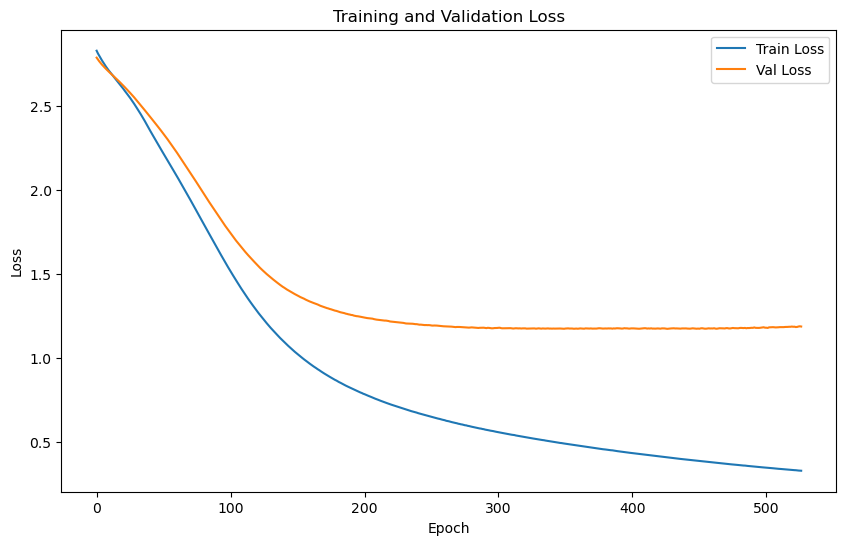

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.6448 | Test Accuracy: 50.54%


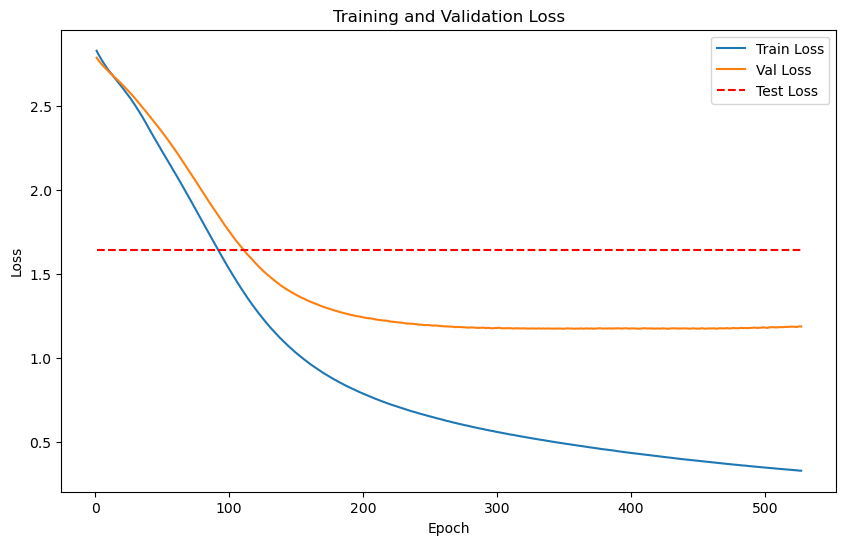

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


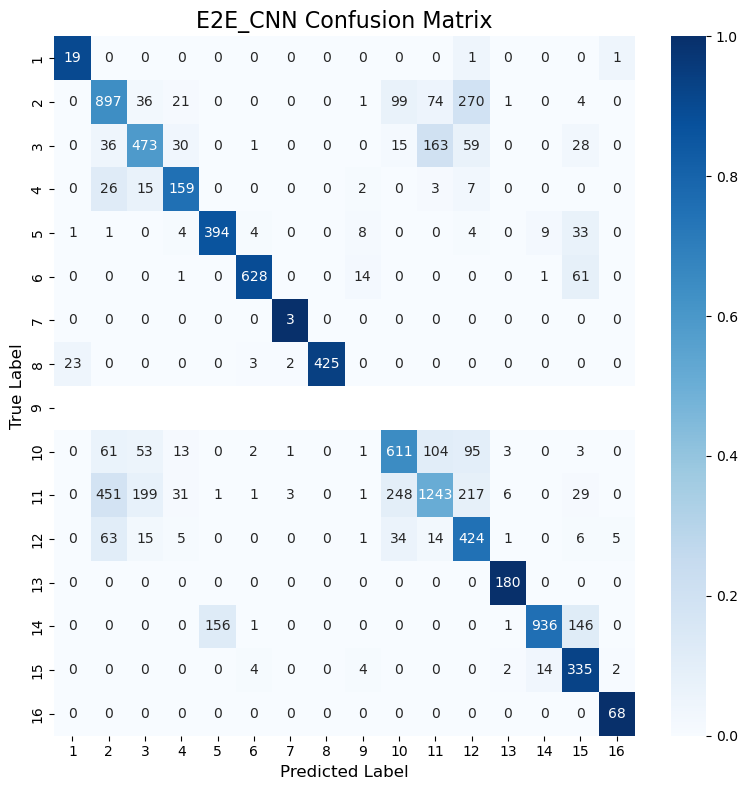

Classification Accuracy: 68.96%


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


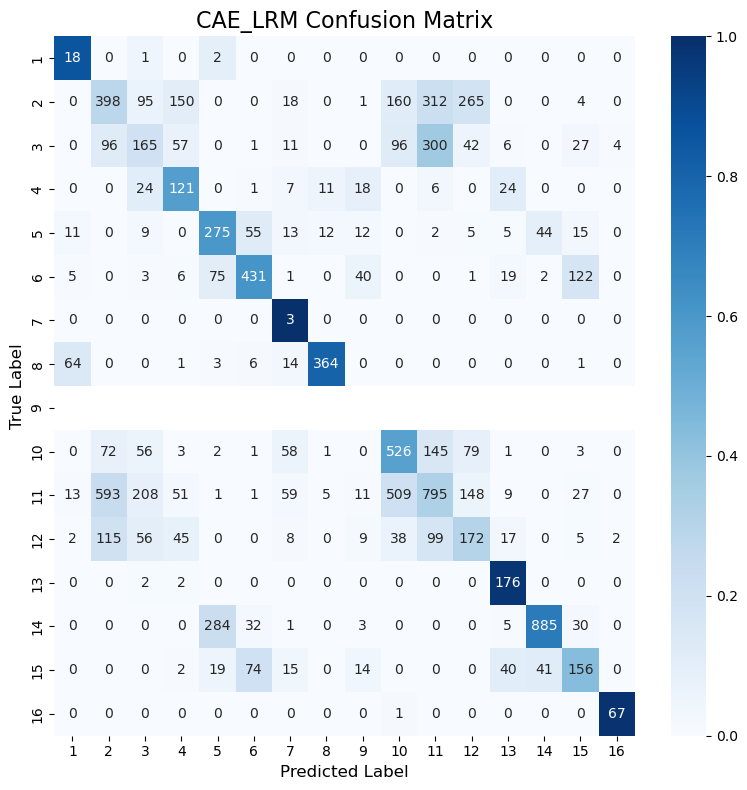

Classification Accuracy: 46.19%


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


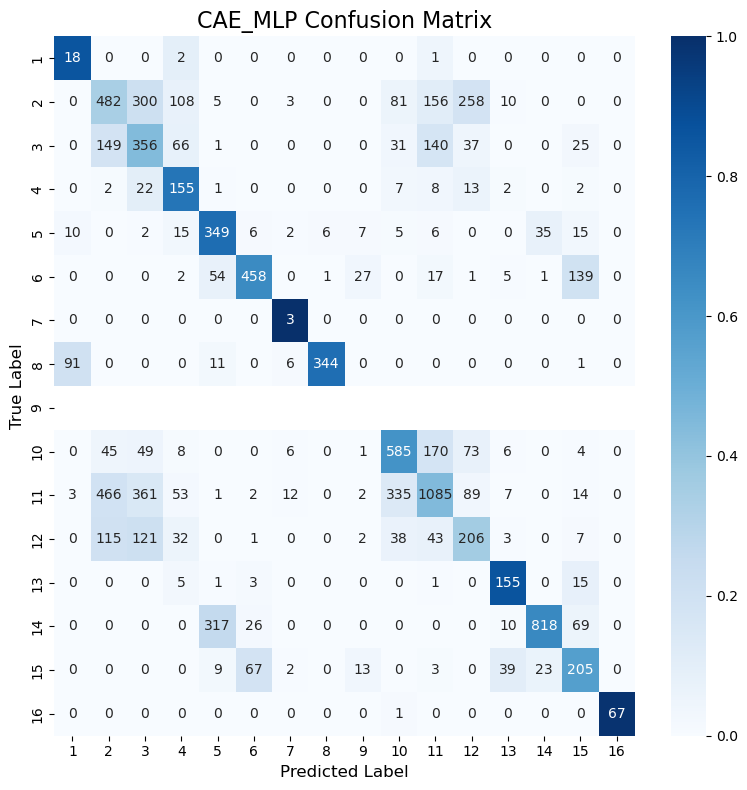

Classification Accuracy: 53.64%


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


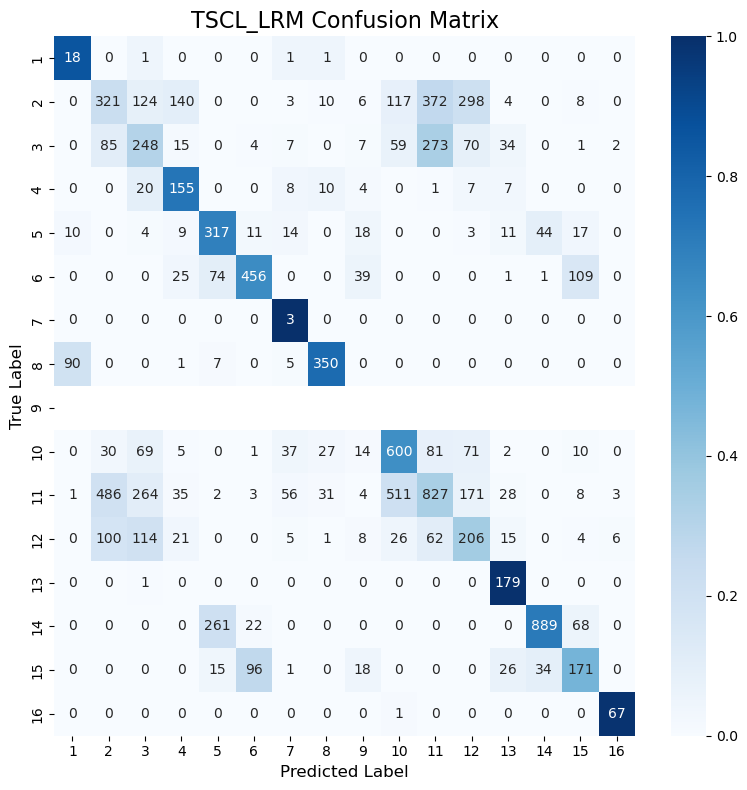

Classification Accuracy: 48.78%


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


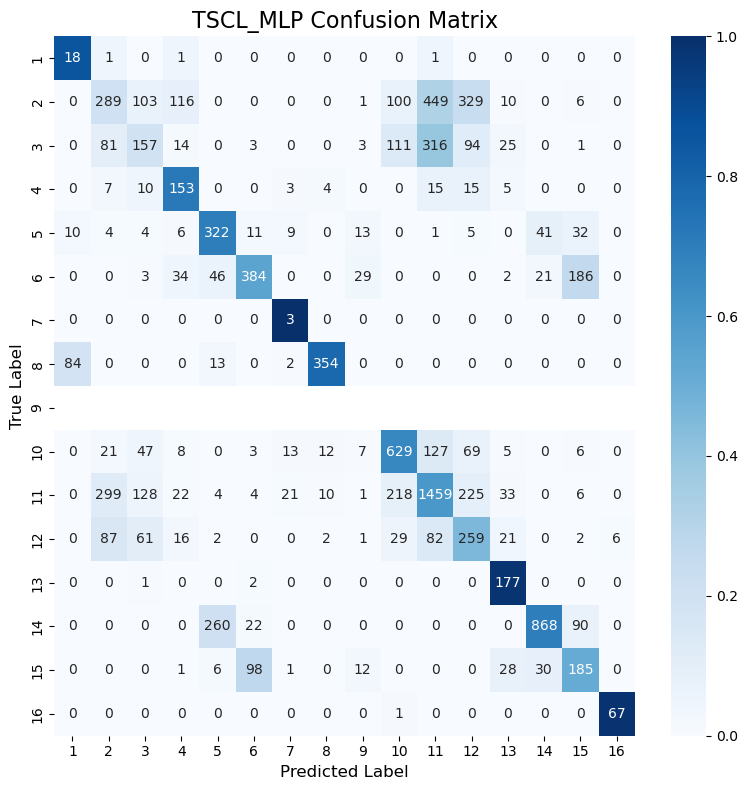

Classification Accuracy: 54.03%


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


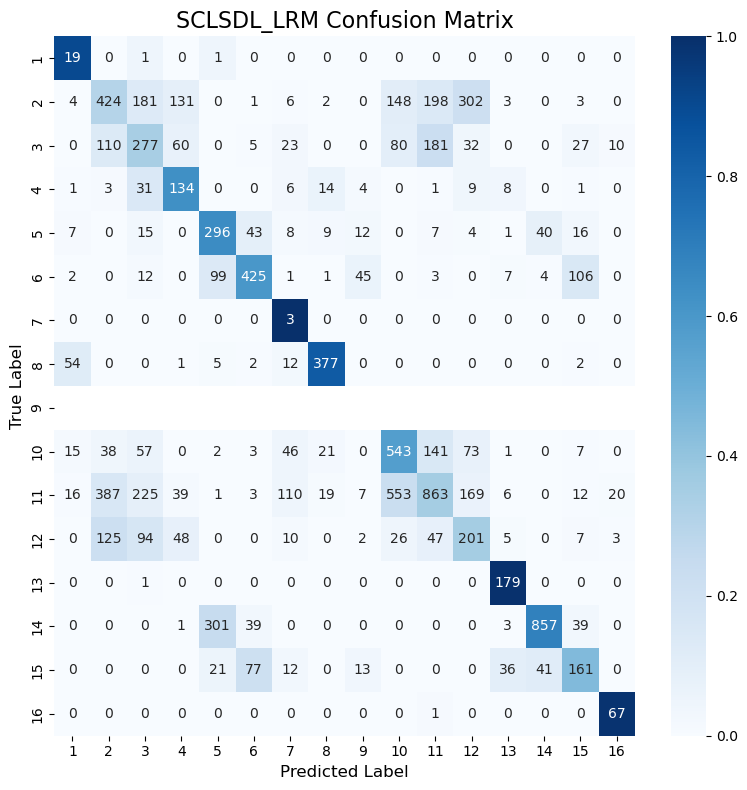

Classification Accuracy: 48.98%


C:\Users\vella\AppData\Local\Temp\ipykernel_13324\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


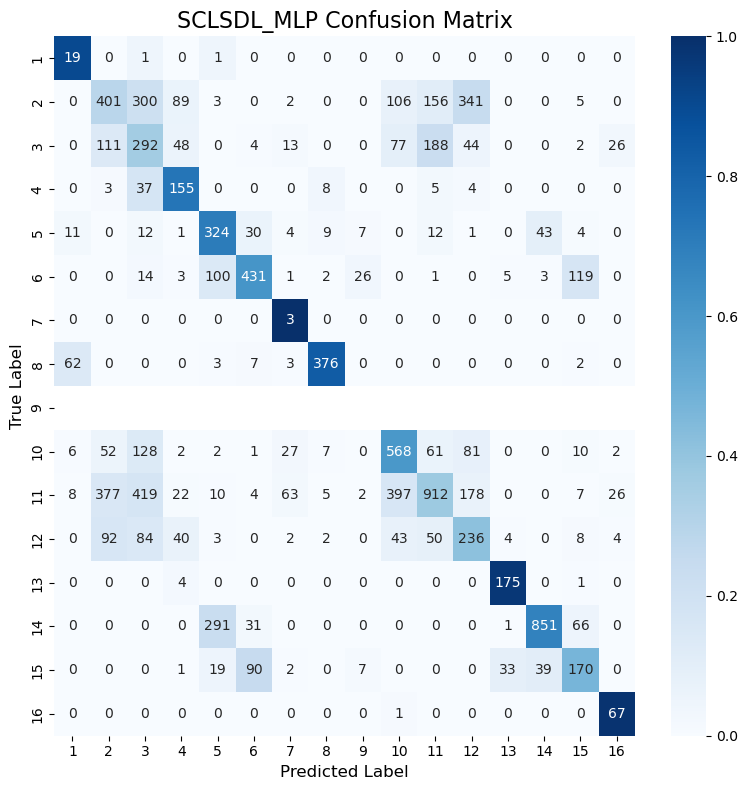

Classification Accuracy: 50.54%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          68.96
1    LRM (CAE)          46.19
2    MLP (CAE)          53.64
3     TSCL LRM          48.78
4     TSCL MLP          54.03
5  SCL_SDL LRM          48.98
6  SCL_SDL MLP          50.54

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          68.96
4     TSCL MLP          54.03
2    MLP (CAE)          53.64
6  SCL_SDL MLP          50.54
5  SCL_SDL LRM          48.98
3     TSCL LRM          48.78
1    LRM (CAE)          46.19
